<a href="https://colab.research.google.com/github/GuacamoleKoala/EuropeanaTeapots/blob/main/ManualEuropeanaTeapots_Chapter4_IIIF_GITHUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A Cup of Tea? Teapots, metadata and AI on Europeana**
Author: Jenske Verhamme,
Date: 01/05/2025



## Table of Contents:



---






# CHAPTER FOUR: IIIF AND GITHUB



# 4.1 Image extraction and/or IIIF

I got the idea of wanting to use the images related to the teapots. I want to be able to make a website to show them or use a viewer to watch my collection. This can also be interesting to clean the data in a different way as this visualisation will immediatly make clear to the naked eye what is a teapot and what is not. This also forms a pinnacle of this project, as we will finally be able to scroll through a digital collection of teapots from all around Europe (and the world).

In a future part I want to look more into IIIF and how to use it.

https://pro.europeana.eu/page/europeana-and-iiif?__cf_chl_tk=OrgAEC9QcJcfIdLu.002GWeOc.dI92enoC9lDSIBtIk-1746138695-1.0.1.1-XSNUVEXwmLQvg7kdm7MF_OSlK_vu_x38.4.s6GQbvDU

I asked Gemini 2,5 to look into the matter as well with this prompt:

> prompt: i want to use images from europeana to view in a iiif viewer. How do i do this?
I have an api key. I also already wrote a script that extracts a dataset of teapots. I cleaned this dataset in excel and openrefine and have it visualised in tableau.
Now I want to use the api to extract data about the images and how to view them in a viewer. Can you help me?

It responded with a plan to get the IIIF manifests of the records of my. This can be done by analyzing the JSON structure and retrieve the appropriate field. If we also extract the Europeana ID, we can then join the extracted data with our original dataset. We can also adjust our original script to also retrieve this field. In this case the difference does not matter much any longer, because we already almost finished with the cleaning and further processing of the data. At this point, we can just match the extracted data with our original dataset.

## 4.1.1 Thumbnail Images: Low Quality

An idea I had that can be a simple solution is to download all preview/ thumbnail images in a local folder via a script. Then I can watch them in a folder on my computer. In a later instance I can look up the HD image and watch those via separate records on Europeana.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving allteapotallmetadatacleanedv14.csv to allteapotallmetadatacleanedv14 (1).csv


In [51]:
import pandas as pd
import requests
import os
from urllib.parse import urlparse
import hashlib # For creating a hash from the URL to ensure uniqueness
import time    # For adding delays if needed
import re      # For sanitizing filenames
import zipfile # For creating zip archives
from google.colab import files # Import for Colab-specific file operations

def download_images_from_dataframe(dataframe_path, image_url_column, output_folder="downloaded_images"):
    """
    Downloads images from URLs specified in a DataFrame column, generates more readable filenames,
    and creates a log file mapping original URLs/records to downloaded filenames.

    Args:
        dataframe_path (str): The path to your dataset file (e.g., 'teapots.csv').
        image_url_column (str): The name of the column containing image URLs.
        output_folder (str): The name of the folder where images will be saved.
                              Defaults to 'downloaded_images'.
    """

    # --- 1. Create Output Folder ---
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output folder: '{output_folder}'")
    else:
        print(f"Output folder '{output_folder}' already exists.")

    # --- 2. Load the Dataset ---
    try:
        # Added dtype specification as suggested by the DtypeWarning
        df = pd.read_csv(dataframe_path, dtype={'Column19': str, 'Column24': str}, low_memory=False)
        print(f"Successfully loaded dataset from: '{dataframe_path}'")
    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{dataframe_path}'. Please check the path.")
        return
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    # --- 3. Initialize Log Data ---
    download_log = []
    download_count = 0
    skipped_count = 0
    error_count = 0

    if image_url_column not in df.columns:
        print(f"Error: Column '{image_url_column}' not found in the dataset.")
        print(f"Available columns are: {df.columns.tolist()}")
        return

    print("Starting image download process...")
    for index, row in df.iterrows():
        image_url = row[image_url_column]
        generated_filename = None # Initialize for each iteration
        status = "Processing" # Initialize status for logging
        error_message = None # Initialize error message

        if pd.isna(image_url) or not isinstance(image_url, str) or not image_url.strip():
            status = "Skipped (Invalid URL)"
            skipped_count += 1
            error_message = "Empty or invalid URL found."
            # Log this skipped entry
            download_log.append({
                'dataframe_index': index,
                'original_url': image_url,
                'generated_filename': None,
                'download_status': status,
                'error_message': error_message
            })
            continue

        try:
            # --- Smarter Filename Generation ---
            parsed_url = urlparse(image_url)
            path_segments = [s for s in parsed_url.path.split('/') if s] # Split path and remove empty strings

            suggested_name = ""
            if path_segments:
                # If the last segment is 'manifest', try to get the segment before it
                if path_segments[-1].lower() == 'manifest' and len(path_segments) >= 2:
                    suggested_name = path_segments[-2]
                else:
                    # Otherwise, take the last segment (e.g., image.jpg or unique_id)
                    suggested_name = path_segments[-1]

            # Sanitize the suggested name to be filesystem-friendly
            # Keep alphanumeric, underscore, hyphen, and period (for extensions if present)
            suggested_name = re.sub(r'[^\w\-\.]', '', suggested_name).strip()

            # Generate a short hash from the full URL to append for uniqueness
            # This is crucial to prevent collisions if different URLs yield the same suggested_name
            url_short_hash = hashlib.md5(image_url.encode('utf-8')).hexdigest()[:8] # First 8 chars of hash

            # Determine the file extension
            # Try to get extension from the URL if it's a common image type, otherwise default to .jpg
            ext = '.jpg' # Default extension
            if '.' in parsed_url.path:
                potential_ext = os.path.splitext(parsed_url.path)[1].lower()
                if potential_ext in ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp', '.tiff']:
                    ext = potential_ext

            # Construct the final filename
            if suggested_name:
                # Combine suggested name with short hash for uniqueness
                generated_filename = f"{suggested_name}_{url_short_hash}{ext}"
            else:
                # Fallback to full hash if no meaningful name could be extracted
                generated_filename = f"{url_short_hash}{ext}"

            # Ensure the filename is not excessively long for some file systems
            # Max filename length on many systems is 255 characters.
            if len(generated_filename) > 200: # Keep it under 200 chars to be safe
                generated_filename = f"{url_short_hash}{ext}" # Fallback to short hash if name too long

            # Construct the full path for saving the image
            image_path = os.path.join(output_folder, generated_filename)

            # Check if image already exists to avoid re-downloading
            if os.path.exists(image_path):
                status = "Skipped (Exists)"
                skipped_count += 1
                # Log this skipped entry
                download_log.append({
                    'dataframe_index': index,
                    'original_url': image_url,
                    'generated_filename': generated_filename,
                    'download_status': status,
                    'error_message': None
                })
                continue

            print(f"Downloading image {download_count + 1}: '{image_url}' to '{generated_filename}'")
            response = requests.get(image_url, stream=True, timeout=15) # Increased timeout
            response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)

            with open(image_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

            status = "Downloaded"
            download_count += 1
            # Add a small delay to be polite to servers and avoid being blocked
            time.sleep(0.1) # 100 milliseconds delay

        except requests.exceptions.RequestException as req_err:
            status = "Error"
            error_count += 1
            print(f"Error downloading '{image_url}': {req_err}")
            error_message = str(req_err)
        except Exception as e:
            status = "Error"
            error_count += 1
            print(f"An unexpected error occurred for '{image_url}': {e}")
            error_message = str(e)

        # Log the result of the current download attempt
        download_log.append({
            'dataframe_index': index,
            'original_url': image_url,
            'generated_filename': generated_filename,
            'download_status': status,
            'error_message': error_message
        })

    print("\n--- Download Summary ---")
    print(f"Total images downloaded: {download_count}")
    print(f"Total images skipped (due to existing files or invalid URLs): {skipped_count}")
    print(f"Total images failed (due to download errors): {error_count}")
    print(f"Images saved in: '{os.path.abspath(output_folder)}'")

    # --- 4. Save the Download Log to CSV ---
    log_df = pd.DataFrame(download_log)
    log_filepath = os.path.join(output_folder, "image_download_log.csv")
    try:
        log_df.to_csv(log_filepath, index=False, encoding='utf-8')
        print(f"\nDownload log saved to: '{log_filepath}'")
    except Exception as e:
        print(f"Error saving download log: {e}")

    return output_folder # Return the output folder name for zipping


def zip_folder(folder_path, zip_name):
    """
    Compresses a specified folder into a zip archive.
    Useful in Colab for downloading generated content.

    Args:
        folder_path (str): The path to the folder to be zipped.
        zip_name (str): The desired name for the zip file (e.g., 'my_archive.zip').
    """
    try:
        with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Add file to zip, preserving directory structure relative to folder_path
                    zipf.write(file_path, os.path.relpath(file_path, folder_path))
        print(f"\nSuccessfully created zip archive: '{os.path.abspath(zip_name)}'")
    except Exception as e:
        print(f"Error creating zip archive for '{folder_path}': {e}")


# --- Script Execution ---
if __name__ == "__main__":
    # --- Configuration ---
    # IMPORTANT: Ensure your file is accessible (upload to Colab or mount Google Drive)
    # Example for Google Drive: '/content/drive/My Drive/your_folder/allteapotallmetadatacleanedv14.csv'
    your_dataframe_file = 'allteapotallmetadatacleanedv14.csv'
    your_image_url_column_name = 'ImagePreview'
    your_output_folder_name = 'teapot_thumbnails2' # This will be the folder containing your images
    your_zip_file_name = f"{your_output_folder_name}.zip" # Name for the zip file

    # 1. Run the download process to populate the folder
    downloaded_folder = download_images_from_dataframe(
        dataframe_path=your_dataframe_file,
        image_url_column=your_image_url_column_name,
        output_folder=your_output_folder_name
    )

    # 2. After downloading, zip the folder if the download process was successful
    if downloaded_folder:
        zip_folder(downloaded_folder, your_zip_file_name)

        # 3. Trigger the download of the created zip file in Colab
        # This line will cause a download prompt in your browser
        print(f"\nAttempting to download '{your_zip_file_name}'...")
        files.download(your_zip_file_name)


Output folder 'teapot_thumbnails2' already exists.
Successfully loaded dataset from: 'allteapotallmetadatacleanedv14.csv'
Starting image download process...

--- Download Summary ---
Total images downloaded: 0
Total images skipped (due to existing files or invalid URLs): 8694
Total images failed (due to download errors): 0
Images saved in: '/content/teapot_thumbnails2'

Download log saved to: 'teapot_thumbnails2/image_download_log.csv'

Successfully created zip archive: '/content/teapot_thumbnails2.zip'

Attempting to download 'teapot_thumbnails2.zip'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4.1.2.1 IIIF Manifest URL's: High Quality

The thumbnail/preview was not completely satisfactory, so I looked in how to visualize the high quality images. This can be done via iiif API's of Europeana. If I first get the iiif manifest urls, I can use them to visualise the images witht the help of the Mirador or Universal Viewer.
To do this I needed to develop a html script, so I could integrate these viewers (and manifests) onto a local of web-based server (a website).

To do this, I first scripted a way to get all the iiif manifest urls from the dataset we created from chapter one to chapter three. I took my final script from chapter one and adjust it with the help of Gemini to download the Europeana id and iiif url and save them in a separate document (csv). I open it in Openrefine and crossreference it with my original dataset I ended up with at the end of chapter three to get the iiif manifests for all 3582 records in my cleaned dataset.



In [ ]:
# Script to fetch Europeana ID and IIIF URL with Record API validation
# generated by Gemini 2.0 on 15/04/2025
# authorized by Jenske Verhamme
# Validation step re-added on 02/05/2025

# Import necessary libraries
import requests  # Used for making HTTP requests
import csv  # Used for writing data to CSV files
import os  # Used for creating directories and handling file paths
import time  # Used for adding delays between requests
from urllib.parse import quote_plus  # Used for encoding special characters in URLs
try:
    from google.colab import files  # Used for downloading files from Google Colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False # Not running in Colab
import json  # Used for handling JSON data

# <<< --- PASTE YOUR ACTUAL EUROPEANA API KEY HERE --- >>>
API_KEY = "reeditaccif"

# Define a function to send requests with retries (same as before)
def send_request(url, retries=3, backoff_factor=1.5): # Reduced retries slightly for validation calls
    attempt = 0
    response = None  # Initialize response outside the try block
    while attempt < retries:
        try:
            # Add a timeout to the request to prevent hanging indefinitely
            response = requests.get(url, timeout=15) # 15 second timeout
            response.raise_for_status()
            # Check for explicit API error messages even on 200 OK for Record API
            if "/record/" in url: # Only apply this check to record API calls
                try:
                    data = response.json()
                    if not data.get('success', True):
                        print(f"Record API returned error: {data.get('error', 'Unknown error')}")
                        return None # Treat API error as failure
                except json.JSONDecodeError:
                    print(f"Record API response not valid JSON: {response.text[:100]}")
                    return None # Treat invalid JSON as failure
            return response
        except requests.exceptions.Timeout:
            print(f"Attempt {attempt + 1} timed out after 15 seconds.")
            attempt += 1
        except requests.exceptions.RequestException as e:
            # Be less verbose for 404 errors during validation as they are expected
            if isinstance(e, requests.exceptions.HTTPError) and e.response.status_code == 404:
                # print(f"Validation failed: Record not found (404) for {url.split('/')[-1].split('.')[0]}") # Optional: log 404s
                return None # Treat 404 as validation failure immediately
            else:
                print(f"Attempt {attempt + 1} failed: {e}")
                attempt += 1

        if attempt < retries and response is None: # Check if response is still None
            wait_time = backoff_factor ** attempt
            # print(f"Retrying in {wait_time:.2f} seconds...") # Less verbose retry logging
            time.sleep(wait_time)

    # print("Max retries reached or validation failed.") # Less verbose failure logging
    return response

# Main function to fetch IDs and construct IIIF Manifest URLs with validation
def fetch_europeana_manifests_validated(api_key, queries, rows=100, limit=10000):
    directory = f'downloads_manifests_validated/{int(time.time())}/'  # New directory name
    os.makedirs(directory, exist_ok=True)

    validated_records_count = 0 # Count records that pass validation
    processed_search_results = 0 # Count total search results processed
    cursor = '*'
    all_manifest_data = [] # List to store dicts of {'europeana_id': id, 'iiif_manifest_url': url}
    csv_file_path = os.path.join(directory, 'europeana_manifest_urls_validated.csv') # New CSV file name

    fieldnames = ['europeana_id', 'iiif_manifest_url']

    combined_query = ' OR '.join(queries)

    # Estimate total records (optional) - based on search index, not validated count
    estimated_total_records = None
    search_url_estimate = f'https://api.europeana.eu/api/v2/search.json?wskey={api_key}&query={quote_plus(combined_query)}&rows=0'
    estimate_response = send_request(search_url_estimate, retries=2) # Lower retries for estimate
    if estimate_response:
        try:
            estimate_data = estimate_response.json()
            estimated_total_records = estimate_data.get('totalResults')
            print(f"Estimated total search results for '{combined_query}': {estimated_total_records}")
        except json.JSONDecodeError:
            print("Could not estimate total results.")

    print(f"Starting fetch for query: {combined_query}. Aiming for up to {limit} validated records.")


    # Fetch records loop - continues until limit of *validated* records is met or no more search results
    while validated_records_count < limit:
        # Fetch a batch of search results
        search_url = f'https://api.europeana.eu/api/v2/search.json?wskey={api_key}&query={quote_plus(combined_query)}&rows={rows}&profile=minimal&cursor={quote_plus(cursor)}'
        print(f"\nFetching search batch using cursor: {cursor}")

        search_response = send_request(search_url, retries=5, backoff_factor=2) # Use higher retries for search batches
        if search_response is None:
            print("Failed to fetch search batch, stopping.")
            break

        try:
            search_data = search_response.json()
        except json.JSONDecodeError as e:
            print(f"JSON decode error for search batch: {e}")
            print(f"Response text: {search_response.text[:200]}")
            break # Stop if search results are invalid

        if not search_data.get('success', True):
            print(f"Search API Error: {search_data.get('error', 'Unknown error')}")
            break

        items = search_data.get('items')
        if not items:
            print("No more items found in search results.")
            break

        print(f"Processing {len(items)} items from search batch...")
        items_validated_in_batch = 0

        # Loop through each item found in the search batch
        for item in items:
            if validated_records_count >= limit:
                print("Target limit reached.")
                break # Stop processing this batch if limit hit

            processed_search_results += 1
            record_id = item.get('id')

            if record_id and isinstance(record_id, str):
                cleaned_record_id_for_url = record_id.lstrip('/')

                # --- !!! Add Validation Step !!! ---
                record_url = f'https://api.europeana.eu/api/v2/record/{cleaned_record_id_for_url}.json?wskey={api_key}'
                record_response = send_request(record_url) # Uses lower retries configured in function

                # --- Only proceed if the Record API call was successful ---
                if record_response:
                    # Construct IIIF Manifest URL
                    iiif_manifest_url = f"https://iiif.europeana.eu/presentation/{cleaned_record_id_for_url}/manifest?wskey={api_key}"

                    manifest_data = {
                        'europeana_id': record_id,
                        'iiif_manifest_url': iiif_manifest_url
                    }
                    all_manifest_data.append(manifest_data)
                    validated_records_count += 1 # Increment count only for validated records
                    items_validated_in_batch += 1

                    # Print progress periodically
                    if validated_records_count % 50 == 0 or validated_records_count == limit :
                        print(f"Validated record {validated_records_count}/{limit}: {record_id}")

                # else: # Optional: Log skipped items
                #     # print(f"Skipped item {record_id} - Failed Record API validation.")
                #     pass

                # --- Add a small delay within the loop to avoid overwhelming the Record API ---
                # Adjust sleep time as needed. Start small. Remove if not necessary.
                time.sleep(0.05) # 50 milliseconds delay between record checks

            else:
                print(f"Skipping item due to missing/invalid ID in search result: {item.get('id', 'N/A')}")

        # --- End of loop for items in batch ---
        print(f"Validated {items_validated_in_batch} items in this batch.")

        if validated_records_count >= limit:
            print("Target limit reached after processing batch.")
            break # Exit outer loop if limit hit

        if 'nextCursor' in search_data:
            cursor = search_data['nextCursor']
        else:
            print("No nextCursor found in search results. Assuming end.")
            break # Exit outer loop if no more search results

        # Optional: slightly longer sleep between batches
        # time.sleep(0.5)

    # --- End of while validated_records_count < limit loop ---

    print(f"\nWriting {len(all_manifest_data)} validated ID/Manifest URL pairs to CSV...")
    print(f"(Processed {processed_search_results} total search results to find these)")

    try:
        with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(all_manifest_data)

        print(f"Process completed. {len(all_manifest_data)} validated records saved.")
        print(f"CSV file saved at: {csv_file_path}")

        if IN_COLAB:
            print("Attempting to download file in Colab...")
            files.download(csv_file_path)
        else:
            print(f"File saved locally at: {csv_file_path}")

    except IOError as e:
        print(f"Error writing CSV file: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during CSV writing: {e}")

    return all_manifest_data # Return the list of validated data


# --- Define search terms (same as before) ---
teapot_translations = {
    'en': ['teapot', 'tea?pot'],
    'nl': ['theepot', 'tee?pot'],
    'de': ['teekanne', '?eekanne'],
    'fr': ['théière', 'th?i?re', 'bouilloire'],
    'es': ['tetera'],
    'it': ['teiera'],
    'sl': ['čajnik'],
    'sv': ['teekanne'],
    'ca': ['tetera'],
    'pt': ['teiera', 'te?iera'],
    'ro': ['teiera'],
    'lt': ['teiera'],
    'uk': ['чайник'],
    'no': ['kettle'],
    'sr': ['čajnik', '?ajnik'],
    'fi': ['teekanne', 'te?kanne'],
    'da': ['teiere', 't?eiere'],
    'is': ['kettle'],
    'lv': ['teiera'],
    'pl': ['czajnik', 'cajnik'],
}
queries = list(set([term for terms in teapot_translations.values() for term in terms]))
print(f"Using {len(queries)} unique search terms.")

# --- Set desired limit for VALIDATED records ---
# This should now result in a count closer to your original ~4500
desired_limit = 15000 # Aim for up to 15000 validated records

# --- Run the validated function and store the result ---
if API_KEY == "YourapiKey":
    print("\n--- WARNING: Please replace 'reeditaccif' with your actual Europeana API key! ---\n")
else:
    validated_data = fetch_europeana_manifests_validated(API_KEY, queries, limit=desired_limit, rows=100)

# --- Print statement of estimated results ---
# The estimated total search results are printed within the `fetch_europeana_manifests_validated` function.
# Now we can access the returned `validated_data` list.
print(f"\n--- Estimated and Final Results ---")
# The estimated total number of records based on the initial search query is printed during the process.
# The final number of validated records is now accessed from the returned list.
if 'estimated_total_records' in locals() and estimated_total_records is not None:
    print(f"Estimated total matching records (before validation): {estimated_total_records}")
else:
    print("Estimated total matching records (before validation): Could not be determined.")

# The actual number of validated records is the length of the returned list.
if 'validated_data' in locals():
    print(f"Number of validated records with IIIF Manifest URLs: {len(validated_data)}")
else:
    print("Number of validated records with IIIF Manifest URLs: Could not be determined.")

Using 21 unique search terms.
Estimated total search results for 'te?kanne OR tea?pot OR teekanne OR čajnik OR чайник OR th?i?re OR teiere OR tee?pot OR kettle OR theepot OR teapot OR tetera OR ?eekanne OR théière OR te?iera OR t?eiere OR cajnik OR bouilloire OR ?ajnik OR czajnik OR teiera': 8465
Starting fetch for query: te?kanne OR tea?pot OR teekanne OR čajnik OR чайник OR th?i?re OR teiere OR tee?pot OR kettle OR theepot OR teapot OR tetera OR ?eekanne OR théière OR te?iera OR t?eiere OR cajnik OR bouilloire OR ?ajnik OR czajnik OR teiera. Aiming for up to 15000 validated records.

Fetching search batch using cursor: *
Processing 100 items from search batch...
Validated record 50/15000: /376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055953
Validated record 100/15000: /376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056234
Validated 100 items in this batch.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Estimated and Final Results ---
Estimated total matching records (before validation): Could not be determined.
Number of validated records with IIIF Manifest URLs: 8465


Next I matched this database with 8465 records to my original dataset and was able to retrieve the manifest for my 3542 records. I added them to my original dataset in Openrefine. To do this I opened my original dataset and the dataset above. I made sure to name the Europeana id to EID for both projects. Then I created a new column on the basis of the EID column in my original project and linked the iiif url's from project B. This is the same process as we did in chapter two with cross reference.

code:



After the crossreference we have our original dataset with added IIIF manifest url's. These urls can be used in Mirador or Universal viewer to get the image and metadata of a record.

example:

remark: these urls might need to be cleaned up as they may still contain your Europeana API key. This can easily be done with the replace function in OpenRefine.

## 4.1.2.2 HTML: Mirador

Next I wanted to write a html script to look at the images behind the iiif manifests. I ask Gemini to help me write a basic script to load in some iiif urls into mirador and show it as a viewer.



```
# <!DOCTYPE html>
<html>
<head>
  <title>Mirador Viewer</title>
  <script src="https://unpkg.com/mirador@latest/dist/mirador.min.js"></script>
</head>
<body>
  <div id="viewer" style="width: 100%; height: 800px;"></div>
  <script>
    const config = {
      id: "viewer",
      windows: [
        {
          manifestId: "https://iiif.europeana.eu/presentation/815/item_3280669/manifest?wskey=reeditaccif"
        },
        {
          manifestId: "https://iiif.europeana.eu/presentation/2048053/MUO_039005/manifest?wskey=reeditaccif"
        },
        {
          manifestId: "https://iiif.europeana.eu/presentation/2064930/https___www_searchculture_gr_aggregator_edm_TositsasFoundation_000040_63551/manifest?wskey=reeditaccif"
        }
      ]
    };

    Mirador.viewer(config);
  </script>
</body>
</html>
```




This code shows the results for 3 iiif manifests. To run this I copy the code that gemini produces into notepad and save it as 'MiradorViewer.html', and make sure to click the 'all file types/all files' below it to not save it as a text, but as a html document. If I now click on the document in my document folder, it wil open the script in my browser and I will see the mirador viewer with three images related to teapots.

Next I wanted to add strategy to load up all the urls of my iif images. If I added more, for example 90. This would mean I open up 90 canvasses at the same time. This seemed to be unwanted and overload the browser/system. I had to find another solution to solve this.

First I tried a strategy to copy the html script into the notepad to create a html. I did this by saving the document with the name 'MiradorViewer.html' and clicked 'all file types' beneath the name. If we click on this file under documents and run it, it wil open in the browser and show the Mirador interface with 3 ifff manifests. Yet, I could not load many images and they would all open as canvasses.
I could also not load in an entire file via json, whatever I tried.

next I thought it was because i need to host a server, because a file cannot be accesed via browser testing. I found a strategy to first open the windows command prompt and create a folder 'MiradorProject' and put the script in it. I then ran a python server in the folder. how to do this: first open the command prompt, go to folder by pressing 'cd' and then the file location 'C:\Users\Jenske Sampson\Downloads\mirador-project', then press enter to go to that location. Next you can start the server (if python is installed properly). to do this you can enter 'python -m http.server 8000' and it should start a server at http://localhost:8000. To acces the server one could go that link.

I succesfully made a server but was not able to load properly. Even when I put the script in a new folder 'MiradorProject' and put the scriptfile 'MiradorViewer' into it. And also the Json to which it referred. To make the Json I extracted the iiif urls from my OpenRefine file via export 'custom tabular' and choose the 'iiif manifests' column. I exported it as csv and used a online converter (https://www.convertcsv.com/csv-to-json.htm) to convert the document to an JSON array.

example:

I saved this document and also put it in the 'MiradorProject'. This should be used by the new script to load the images. This partly worked but also crashes the system, because it opens all urls at the same time as new canvasses (all 3500+!).
I had to find another solution. I did, partly.

I went back to the original script and pasted all links of the json manually in the file. This worked but also crashed constantly. Mirador was not suited to do this. I did notice you can add one url at a time. I wanted to find a way to upload all urls at the same time. That is how I came to the solution to create my own IIIF manifest that serves as a collection for all these records.





## 4.1.2.3 IIIF collection manifest

 I thought I could maybe combine all the urls under one new link. I looked further into this matter **and** came onto the idea of a iiif collection manifest url. this combines all the manifest urls into one collection url.

 https://pro.europeana.eu/discover-the-data/apis
 https://pro.europeana.eu/post/building-a-rich-media-experience-with-the-europeana-api-and-iiif


in the code that follows, generated by gemini, on a prompt to get insight in how to make a collection manifest iiif. this file contains all the diffrent iiif manifest urls and combines them into one file and a separate link to load all the records in one go. This is important because otherwise you can only load in one manifest or url at a time in Mirador. As i do not want to load in +- 3500 records by hand, I tried to construct them via a script.

I tried other things as well, such as generating the proper json structure for these iiif manifest urls and their tags. This was tedious and resulted in much error.

another problem was that i still have to add the iiif manifest urls to the script below. To do this I had to extract these urls from Openrefine. There I exported the column with the urls as a csv, and converted it online to a Json. That list got copied below here into the script.

In [ ]:
#code to change iiif manifest urls to a json that can serve as a iiif collection url.
import json
import requests # Required only for fetching labels automatically
import time     # Used for a small delay when fetching

# --- Configuration ---
COLLECTION_ID = "https://your-username.github.io/my-iiif-data/collection.json" # Replace with your Collection ID URL
COLLECTION_LABEL = "My Awesome IIIF Collection" # Replace with your Collection Label
OUTPUT_FILENAME = "my-collection.json" # Name of the output file
FETCH_LABELS = True # Set to False if you don't want to fetch labels automatically
REQUEST_TIMEOUT = 10 # Seconds to wait for each manifest request
REQUEST_DELAY = 0.1 # Seconds to wait between requests (politeness)

# List of manifest URLs (replace with your actual URLs)
# Option 1: Define list directly in the script
manifest_urls = [
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_bbea2cab_8706_468e_bec9_424661f764eb/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100940/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100941/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100946/manifest",
"https://iiif.europeana.eu/presentation/952/Culturalia_96b96296_f6c3_4071_b808_df4c45be28a2/manifest",
"https://iiif.europeana.eu/presentation/952/Culturalia_e201128c_3e74_4856_924a_6a9e5a996cc6/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045761/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045762/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045764/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11048916/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11048917/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055481/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055482/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055487/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055519/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055536/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055559/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055585/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055586/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055953/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056141/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056142/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056143/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056144/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056145/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056146/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056147/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056148/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056149/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056150/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056151/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056152/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056153/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056154/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056155/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056156/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056158/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056159/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056160/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056161/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056162/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056163/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056181/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056184/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056185/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056187/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056188/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056189/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056191/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056192/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056193/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056194/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056195/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056197/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056207/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056208/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056209/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056210/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056212/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056214/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056215/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056216/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056218/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056220/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056221/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056227/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056228/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056229/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056230/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056234/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056235/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056236/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056237/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056239/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056241/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056243/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056245/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056246/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056247/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056248/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056250/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056251/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056252/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061357/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061359/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061460/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061461/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061462/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061463/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061464/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061465/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061466/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061467/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061468/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061471/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061473/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061476/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061481/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061490/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061491/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061492/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11064313/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__112790/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__115372/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132811/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132828/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132840/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132849/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132850/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132863/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132875/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132880/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132882/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132905/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132932/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132935/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132936/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132938/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132939/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132981/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132982/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132983/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132984/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132985/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132986/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132987/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132988/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__133033/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__133040/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151602/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20013004/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014386/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014388/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014408/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014409/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014411/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014416/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014439/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014442/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014468/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014469/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014470/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014472/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014473/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014478/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014482/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014487/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014489/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014508/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014529/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016766/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016767/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016768/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016791/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016792/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016793/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016794/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017040/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017076/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017077/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017078/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017082/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017083/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017084/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017085/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017088/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017091/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017092/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017093/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017094/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017099/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017113/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017116/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017123/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017124/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017125/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017126/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017127/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017234/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017235/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017236/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017237/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017238/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017239/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017242/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017243/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017244/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017245/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017246/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017248/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017249/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017251/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017253/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017258/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017259/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017260/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017261/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017264/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017269/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017271/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017272/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017274/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017275/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017938/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017944/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017955/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017956/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017957/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017959/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017960/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_001/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_003/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_004/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_732_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_750_004/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_001/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_003/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_004/manifest",
"https://iiif.europeana.eu/presentation/957/GML_10489_000/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_550f39f2_c51e_6742_a785_2a12065739db/manifest",
"https://iiif.europeana.eu/presentation/1236/item_22G3PTPCIR4C6HFZBG4JM6ECVKX3DUDH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_23OQ4QMWDX6VP6NOIJNVZG6BFMOTUNRD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_26TJJPNFQTNA43LV3PG6XBP7IQMMH3DU/manifest",
"https://iiif.europeana.eu/presentation/1236/item_33CMNHRNSPSP4ON2NEZ6SRYGN5BVTLW6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_3W2WHFP7CFOA4AHSPZ7MQVWZ36IDHSQ4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4EFY4R2OCZROGYVGIQ6X5R5FJVR4PZ7S/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4FAIOKYXIA2UE3CYHU7FT5LOEM33CNH3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4LANF6V2H6CRDNNR33SVK3OVRAZJARMH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4PDEXJIDDS4U5WKDMJUHQ77H4S75P2PH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5A36Z3ZS4ABVHHT3J4KB77BRQ6ZYXYS5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5F4OARJUY4IGUR7733NZMVZHIQFYB6PH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6IYO7J62JDLXADXY7SIZVSGZNQLVVHLD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6KM3YFCJETAJFHZNS3CXJNNBAOWDCZZD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6NLZ7NBIAZU5D5ECXZGNP3BRA3BTC73B/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6UF4ID6O6A2I3AOI6VHPREBJRFW3UJ5A/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6WKJIJCJQTGPXAPACN7SN7ZHAVVBQYCJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6ZC3APXOIEFRLUUHW4USQ64UZJ2I2T5Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7DSYGMLLRR4OS32EIKVP4SJKF2VUX5FZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7UCOI5H4D54LP3V7CJYCFYOF22KBNDTB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7YQ3W3LDB7DLFIRZE4EFB6NXVZBM4EBA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_A5AWJXVR335X7DSFHQY4UJPVPIBP664P/manifest",
"https://iiif.europeana.eu/presentation/1236/item_A6XUOB662N3J3Y4HAM4TL465RMAWCRLO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_AI3IUBWCPYLJ7K4OFNH57NYDBTH7JO76/manifest",
"https://iiif.europeana.eu/presentation/1236/item_AMY5DBYYFMKOAAEB22LD3NGS3UEGLCBX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ARNDUSCGCHPPXZZZXNIN2KYJKMKIFQ2V/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BG66V4R6WSWRWZ4CZHEC3BOCQSVA3XLO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BVX6U77AJ4ALEHW2GTPMOYFYUJA3OLSL/manifest",
"https://iiif.europeana.eu/presentation/1236/item_C44GHCKWUOGTUYAAGEYNH4RFXEM2RF43/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CC3EVLILQUQCMX3EDNPFWYTPW24CAFMP/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CM2CMDWJ4AUYIOGM5W35Y5GGJQK7FI72/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CS4KWBZOCPJT3NS2ZUBIXMXCYPWOLUGQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DFENZVJKOLE45GUL4WJCNXGAQYHVEWTP/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DH72KRWULMX5DXXGMVXQHHOUHB2DZEOJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DMGB2DXVC562IY7DRESSZJYJHH2A5KKF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DVXSUE6TPKNROWZJUFHWHHEOTZKMPDR3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ETIYVMJNLHMXL4ANP3RPPPBCDVQAIGDY/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EVOO4NZKYXTUASC4VVNGI63XKN2BB3AB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EZBDQYDTF7BROGXBP6Q6CEP7AE3XC3Y5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_F7ZLSR3TEIGBORE6L75VT7X33PVF4QGD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FOA4SOYXDC3OYNAPW6QM46JFTQZWHSZJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FOCHWN7EGF7BXBLTYCHMXZPXOIAQGMWR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FZPKWORBGP6TSFCHT5PXT2NQMMXUHUOS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GHQMGAQTQ45X6XOHCFWM2D3CMRLEOM2H/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GSVQWNFSDMW5UTAODBJF23ROQSG7WP3W/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GSXKV6NJPJVMMFMCSK3LEPFHZA4EWUTI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_HOT7SA3F34IRXMYPTV7H77INPPY55MAE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_HRFS5UJPEV4EINAZJGQ2ZUIN22R6S2KE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I22N2KDHBVXGHLMLEQ3AL6NWV3UBCTEY/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I36Q7VDBNTXVZ3CDBVCDHWLBMHULV5VS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I3LFRZAGKWJ7ABCUXK5OFBNNTAGSVFQR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I5YKIQAYDGVN737Z2HPLDHMQBL6KN2E7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I7U3XMSO64X3TKQ3XS74CVHT3J75PM7D/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IFGVIT7EUI64TLZY5RD7CO7E4JY677P7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IPPG4RSSXQDDF3EFQMX4DSLRFJE3IBAS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IT7NVKRBAXBVTMXLOQOODP2ZWHS4MT2R/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JAUTQKAH5PJLCV5WFBO3HDQBTRDUIBCO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JD4QXNFG5NAV4QLPRQRRICQJCCWB6CLH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JHQALPB5KWVW2YMBLT5A53YQKI5AOZEI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JQZSHIOJLELUQRPDIBINKZQ2W32ERS5L/manifest",
"https://iiif.europeana.eu/presentation/1236/item_K4GIDVVVTC5FG3FFLP53YTHDJKY3VWWA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_K66S52MDOV3BINCOK7CXWV6MBLECOLE3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KE755P5TRJXDFV5MFQP5N4W3PPCE3RZ5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KFRDXMKYPCZPCGXO25HSA5ASVMMUOWR3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KGQAK73N73Q5XEFFQDWU2YVJW5J3QZBT/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KHHJOG6EXDDQVKERCEKFF6HJKJTCVN3N/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KJCLTAIK2IBUTCVOETLFDHMGJ3VDXNTQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KRHRO34BT6GEXSQA2YHY5JLXKRVC4CRA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KTRQYV3LL5IMUFD3DNCPRDXPSKYT7XGB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KV2I3SCNXVWKIME7NC236DKB4OILKPRH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KZOSPWZDJ2DPD6NGSDYPLDM7YZR7ZKLI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L5QBLZU6HTJ5ZWWEMCJUI524QDPLVU44/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L62Z23GMHKZTTZAQC26QHTDX5V7LEUP4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L7QLG6CH6XTAV26PJ2RNIO5G6JY2RMSS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LDIY6ZVKDPEM5I2L5DMUT2KODWH3RZHV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LE6FVADOOSNWGMZOGXN6JQRE63MCA42C/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LXGA2WSOCXNIIQTQPL6BWFPPMYK5UHUO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MD2KZHC7CSQTTTGZ5GWD4IX33BGYSSYV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MIH3E6YMD6VDZZ2IZHZHA3A7AG56ZVP7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MWARZKB7D4KIXNJH7EVC72CQZMUJK7BQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MWUFCYS775G7PNUDLMVISZJQXCMZNQ6G/manifest",
"https://iiif.europeana.eu/presentation/1236/item_NXGWZ2O7XJMYYSYTPOWXQ3XAPSVHAPFF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ORQTYFUBHFL5LTKXIQNJMRRIXAMYYWK4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_OZ3LTCDIPH6OKOJZASL4TLN35RKC6O3L/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PHGB4L6J57K2CYAKM3G3KIHCIA3ATXYK/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PLK7UPLF334YVZTZH4BDYNVED2W426AG/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PNAQIAGDDLPYDLIP44ON6D6B2WPYAYKS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PWJREGUOAYDMQKYFHDTVHP4OATURZODF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PYX2R5GJFNDYAJ5RCZ47DYKWSPSPOUGB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Q37POQZTYWTOZWAE6EWHSSNGN3DFBDBD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QBAY5TS76IWY3TL2T456GBH3XXBRX6P3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QCTGZ36MG62AVC6MOTXFBYGBJWNO7UWM/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QH3YCPKVCWWKL367JIRGXY2TOVMG45II/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QH6ZKWEBLX3MQKQGFUEKOAF5LGLDD266/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QWCGEOFIWSWIUC5O5K66M7GPPZPQ7SEI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RBLSOFTDFLZ7RJBBZ4AW5JNO2KJHEWYX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RMODH4XFTNCRFDSTJFMAAM3S5IBWP3ZS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ROXQXFJYLVROELILGFWBXQPE3GHYTY2Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_T6QGI3LWSZ4KJTCXQA7B42PJHCJQ3SZW/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TRKVXC7BO3FG54U42BMROITN5UBORNAS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TVGJ636KRGAG5MKKKTJ5KQJ3FRH3STLF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TZATNTNSQM4TKYMIYCGN35YC4IMNRHIN/manifest",
"https://iiif.europeana.eu/presentation/1236/item_UMK4ZRVFQKV3MTSOUNPMZJWNYSQR72I5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VG42MTAOJYBDIQMKZPHTN322AO6YYCJS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VLLPQNCRTYO3M6UGDF6XS43PFN2YOX2A/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VP6HVLUYPEPLKSVVI7VU2R3SSHWUWVK7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_WLWOACKWOFL2IB4B22QQBHKMWPU4OWU6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XL3IBKI4OC2QETIJKEJQICLTON2HF34Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XU5DONIJWST6BOZJYQUTYOBEJU3Q6CWL/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XVSVVGVDTMNTAFVXELWSNLDWQERJ35KO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Y5R7AGRMOZBNZAP4G4M4GKFF65I73YKE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Z7VWFDG5NSVT6OKRTWVFECBOPYLUFEL5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZBELDIIJMSNDBIAYCHOPRGDJNROXW2UV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZCMX3KAIXK46TTOFKNDCB4UM65KFKRCX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZIP5CFSE74EFC57H4CWF2LN4FAHO2GQZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZNLYNESYX6OVNXXQ6VUCPQ3JXGROMJIB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZQXFKJZFSZZHETJ5IXNFGGDO23WMRLSH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZWE3HVLDYRZ5ZFHYNLLGCP244WG27ZGX/manifest",
"https://iiif.europeana.eu/presentation/1228/item_YWQUDKSPSIDPM5QJ3ET7Q6M4SAF7RKUC/manifest",
"https://iiif.europeana.eu/presentation/1220/item_ATWNOC4QNWA5ETFTBAD5PBMPYILPKM3I/manifest",
"https://iiif.europeana.eu/presentation/1220/item_TEA47DTIF6F5GEBN6JOVNSDVCCZ3ZAIS/manifest",
"https://iiif.europeana.eu/presentation/1176/item_54QIGQVCAXVTB2UBNSF6QBFSJJIZ4MWJ/manifest",
"https://iiif.europeana.eu/presentation/1176/item_6XJEAHF64CHZ3AFBQH3SCPC2TSOCBPYM/manifest",
"https://iiif.europeana.eu/presentation/1176/item_AR4BCWBHFAI7UPRSL45UU77RHCUVL4SU/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ATGF6BEIHCHLVZKAUFHV6CKN4ZMQPEAA/manifest",
"https://iiif.europeana.eu/presentation/1176/item_BOLDWUNOJILKWW2GGGICW5C47EYSMM4I/manifest",
"https://iiif.europeana.eu/presentation/1176/item_DIOYGL6IQMHJEB6AHSN5EIZ2KACL33WF/manifest",
"https://iiif.europeana.eu/presentation/1176/item_IZVJEAXQ3FBH2TJNZUV7NCUHFXGUQYTB/manifest",
"https://iiif.europeana.eu/presentation/1176/item_QQOJFCIUKW7JOO4OAKQ5TJPKR7H4KHZH/manifest",
"https://iiif.europeana.eu/presentation/1176/item_TMJMJNQNNLHJGRPDVEVTRGODN42VM2SK/manifest",
"https://iiif.europeana.eu/presentation/1176/item_WNLB47UWRSMBQDLCAI27RJBTTKXHH3HN/manifest",
"https://iiif.europeana.eu/presentation/1176/item_WQ2VR7VZF6CXXEHX3JGPQ4FES7WQL4JA/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZGLS5PJMXGBWLQXEYWGANV3UJWLIYGZQ/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZIIB6WVHTHH4O7FDM4FMFQL35TXWLUYG/manifest",
"https://iiif.europeana.eu/presentation/1088/item_A4WJF2RZEWP6F2G763E7IOI5LJ43PG3P/manifest",
"https://iiif.europeana.eu/presentation/1088/item_OUUPC5DC3HRGLLKA2VFEDLYX33BSFAR7/manifest",
"https://iiif.europeana.eu/presentation/1029/E00683165/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280744/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280746/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280747/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280756/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280769/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280771/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280772/manifest",
"https://iiif.europeana.eu/presentation/1028/E01152748/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280743/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280745/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280758/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280762/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280763/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280764/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280770/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280774/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280775/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280776/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280777/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280778/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280742/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280752/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280753/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280755/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280757/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280760/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280761/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280768/manifest",
"https://iiif.europeana.eu/presentation/1026/E00683166/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280741/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280748/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280749/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280750/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280751/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280754/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280759/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280765/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280766/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280767/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280773/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280779/manifest",
"https://iiif.europeana.eu/presentation/2058632/416e4ed0_909a_66db_dad9_e1e69d45658f_media_864f90d1_e0f0_3b2c_c0be_459c9f8c4f41/manifest",
"https://iiif.europeana.eu/presentation/2058632/ab9e2094_033a_befb_4e60_851c0243f394_media_2ffafc02_d065_edf5_9e70_4d614a8c3831/manifest",
"https://iiif.europeana.eu/presentation/2058632/d2319725_28cf_acd2_ed16_8bec41ec59f6_media_e148581f_c5fb_f424_c686_7e658318873f/manifest",
"https://iiif.europeana.eu/presentation/92085/4406/manifest",
"https://iiif.europeana.eu/presentation/92085/50364/manifest",
"https://iiif.europeana.eu/presentation/92085/50642/manifest",
"https://iiif.europeana.eu/presentation/872/NHMUKXBOTXBM013722608/manifest",
"https://iiif.europeana.eu/presentation/840/NHMUKXBOTXBM013722611/manifest",
"https://iiif.europeana.eu/presentation/343/https___hispana_mcu_es_lod_oai_bivaldi_gva_es_7619_ent0/manifest",
"https://iiif.europeana.eu/presentation/15508/DG2003_2105/manifest",
"https://iiif.europeana.eu/presentation/803/item_3FSRIVSOD4EFD6Y64ACZGFME5HFPLULS/manifest",
"https://iiif.europeana.eu/presentation/803/item_BLRE6NBM6LOU46SFAV5D3FBB5J3YPLAI/manifest",
"https://iiif.europeana.eu/presentation/803/item_GNPFZBD5H3HQ3YS6L7AO23OITGCQCOEP/manifest",
"https://iiif.europeana.eu/presentation/803/item_ICUIRGEDOVQWEP6JJ3G5YMCWVSRTKWRV/manifest",
"https://iiif.europeana.eu/presentation/803/item_OXUYST6M45AJYF6IYJABZL42ZE7QFQMI/manifest",
"https://iiif.europeana.eu/presentation/803/item_QNKQ2G5W24YAOAGED32Z4PH2WXXFGV3N/manifest",
"https://iiif.europeana.eu/presentation/803/item_RLSKC64YWIPZPQNQ64YJXRZZY6PNCGYZ/manifest",
"https://iiif.europeana.eu/presentation/168/item_2GMMY6QV4F4S2IAOZQI5Z3OHY5UX5M3S/manifest",
"https://iiif.europeana.eu/presentation/168/item_5NJ64CSFKHVMYLRVSLL2ZJB2GAWYGOMJ/manifest",
"https://iiif.europeana.eu/presentation/168/item_MWRJLQ5HRHVFW2LPTI6KETJM2IPD2FCU/manifest",
"https://iiif.europeana.eu/presentation/168/item_PIDMF3ZSGLMLZHMHTOIAVQ33MSR2YCE7/manifest",
"https://iiif.europeana.eu/presentation/648/item_TU2OLANWHVWMVBSP2H5FP3RWD7ZEHRPN/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_1206627/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140660/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140667/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140669/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056182/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151289/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151291/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151292/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151306/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151309/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151403/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151404/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151405/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151526/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151528/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151585/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151597/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151598/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151599/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151601/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010010488/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013267/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013304/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013335/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013380/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013403/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013434/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013441/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013496/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013502/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013670/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010014097/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010014592/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010015001/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000012436200/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000012591299/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000015229229V/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000024982337/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000006840228/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000006841249/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013236/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013281/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013373/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013632/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013694/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013717/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013908/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014653/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014837/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014899/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000012574605/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000022428967/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000024986960/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000027724590V/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010010075/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013229/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013311/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013342/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013359/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013410/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013649/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013663/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013809/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013816/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010014776/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010014868/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010015094/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000011151210/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000012388370/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000012574926/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000026185484V/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000027724613V/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013212/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013274/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013298/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013328/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013366/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013397/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013526/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013571/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013588/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013618/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014509/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014745/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014790/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010441282/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000012072750/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000022413802/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000025362428V/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006220846/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006841140/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006898748/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013182/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013243/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013427/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013465/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013489/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013557/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013748/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013779/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013786/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014493/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014530/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014912/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014998/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010015117/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000011151562/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000012494132/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000022413819/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000027724583V/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000005076932/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000006841225/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010010044/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013168/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013175/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013199/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013205/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013250/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013458/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013472/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013533/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013601/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013755/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014110/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014561/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014622/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014714/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014882/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014943/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014974/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010015032/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000012576289/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000024882484/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000027724606V/manifest",
"https://iiif.europeana.eu/presentation/225/19780466/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1910_1783A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1910_1783/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_NM_13202/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1991_8_2/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1980_27_H_1509/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_VBR_462_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17420_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6580/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6574/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6573/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6568_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6567/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6561_A/manifest",
"https://iiif.europeana.eu/presentation/11629/HERBARXBGBMXGERMANYXBX10X0356271/manifest",
"https://iiif.europeana.eu/presentation/206/item_A4SN2M2BVXO62PHC2O7ATMEIOYNPOCAI/manifest",
"https://iiif.europeana.eu/presentation/206/item_BVL37GTXJ6QZAQ2CTKQRV5MX4CWQYH4V/manifest",
"https://iiif.europeana.eu/presentation/206/item_CNQ66EGQIXLK2CUSC2UCK52RYVCZNFA7/manifest",
"https://iiif.europeana.eu/presentation/206/item_EGBGT44UKAOEITF25ILMVZUSYW4Q7KU7/manifest",
"https://iiif.europeana.eu/presentation/206/item_EPUKXXJE7G4UI2UN4JMTTJISEU6QHVM3/manifest",
"https://iiif.europeana.eu/presentation/206/item_F3W27QY5GU57BAIL4XCWROZW43FFPU6C/manifest",
"https://iiif.europeana.eu/presentation/206/item_HOLUCNTSAB5LKLCJNYQXADCL2KSIIQBW/manifest",
"https://iiif.europeana.eu/presentation/206/item_HZ2F3A5DFIBUT7TUV32BGKMDSJOY3V5L/manifest",
"https://iiif.europeana.eu/presentation/206/item_N7TGC44JE3FTRCLHPVEU2TMO6MIPMBVR/manifest",
"https://iiif.europeana.eu/presentation/206/item_NENVF5LBAQ2ZR2LOL77GXAML5JZRGIVK/manifest",
"https://iiif.europeana.eu/presentation/206/item_NXSSKDFQZWNWIUG36MVGJOZE5E7RYPAK/manifest",
"https://iiif.europeana.eu/presentation/206/item_OK46S2HDWOZSGCG2Z4U4CUUNJKVAREC4/manifest",
"https://iiif.europeana.eu/presentation/206/item_SKY3AYQEHFZPT6JJUW6WTY4LPS3OMP4D/manifest",
"https://iiif.europeana.eu/presentation/206/item_THO4WVOVMRXROBCJFGOWVNYRCFFNZJT6/manifest",
"https://iiif.europeana.eu/presentation/206/item_WKDNYL4ZQUIBXIAL3GEYBCFA3H4TRY5A/manifest",
"https://iiif.europeana.eu/presentation/206/item_XV7MBYPJ3UJZEP2PRAXEOKCKF257L4A4/manifest",
"https://iiif.europeana.eu/presentation/206/item_YTVGETD7XM6NITQDLE7KOBMBWYYQSWPW/manifest",
"https://iiif.europeana.eu/presentation/206/item_ZIUYK5FZKCLBWA4AKHR6ZCCQDGF4R7C5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_YV565OXQGMD5ZP3LK6VB5DP7EFWFVKY7/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZFHAPAXEFSLLD565O6DKYXESJGHFPMZ7/manifest",
"https://iiif.europeana.eu/presentation/1014/item_4UTO2IBSGVDCXMJVLSTBZPMLCQP37VWA/manifest",
"https://iiif.europeana.eu/presentation/1014/item_72VEMD5O3OAI4KOZA56ZKHIVDFS6URFK/manifest",
"https://iiif.europeana.eu/presentation/1014/item_S4J7H5ML6UE54XKLJXE6IT5BG7RRTNXG/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_545495/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_545508/manifest",
"https://iiif.europeana.eu/presentation/168/item_2MDUHBL3R6FT5RGRCWDYDFN4E22CRV3T/manifest",
"https://iiif.europeana.eu/presentation/257/https___hetutrechtsarchief_nl_beeld_5BB69A133BA354FEBD00B40A6E7F2744/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_7179_2a/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_02_862/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_1905_109/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_1905_110/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_3313_3/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_4284_4/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_4284_6/manifest",
"https://iiif.europeana.eu/presentation/10/id_gvn_KONB14Borms0466/manifest",
"https://iiif.europeana.eu/presentation/90402/SK_A_3355/manifest",
"https://iiif.europeana.eu/presentation/90402/SK_A_1563/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_46_15/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_41_401/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_32_82/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1998_70_B/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1998_61_63_V_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1994_23_9_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1983_483/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1976_101_5/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1969_342_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1963_21/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1955_229_35_V_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1950_355/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1897_A_3320_37_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_85_021A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_67_425/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_52_394/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_47_105/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_110/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_109/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_108/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2014_64_15/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2013_9_11/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2013_9_12/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2000_211/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1997_24/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1994_31_80/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1994_31_50/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1991_566/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1991_480/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_609/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_610/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_3882/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1963_620/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1907_4779/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1890_A_15890/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1889_A_14363/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_F_F00835_A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_F_00_5412_1/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1981_12_C/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1979_12/manifest",
"https://iiif.europeana.eu/presentation/90402/HA_0012305/manifest",
"https://iiif.europeana.eu/presentation/90402/HA_0010698/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_6991/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_6570/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5888_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_91_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_73_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_72_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_23_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_3985/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2692_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_D_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2620_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2596/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2594_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2566_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2566_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14249/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14238_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14238_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14192/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14181/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14048/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13862/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13320_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13320_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13203/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12556/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_332/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_265/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_211/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12236/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11860_119_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11746/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_319/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_158_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_158/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_142/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_142_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_123/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10971_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10888/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10321_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_B_1_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_1715/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_321/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_314/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_312/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_311_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2007_8_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2007_22/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2003_1_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2003_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1999_86_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1991_34_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1991_34/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_265_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_161_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_64_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1981_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1978_3_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_37/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_9/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_7/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_4/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_11/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_9/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_7/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_4/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_11/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_240/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_240_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_20_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_20/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_73/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_30/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_124_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1974_80_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1974_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1972_81_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1972_132_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1970_34/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1970_33/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_50/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_184_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_108_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_61/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_149_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_132_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_132/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_188_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_188/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_145/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_142_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_136_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_154_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_154/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_105_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_105_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_93_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_93/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_45/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_102_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1961_42/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_172/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_133/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_133_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_Z/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_Q/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_K/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_J/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_E/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_F/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_122_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1958_1_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1958_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57_II/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57_I/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17511/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17421_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17402_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17402_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17387/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17333/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_16535/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_16394_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15783_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15766/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15564/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15563_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15552/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15541/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14617/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_E_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_E_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14559_M_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BI_1926_0324B_5/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_TN_2361/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1963_50/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1961_91_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1956_1_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_C/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15893/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15828/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14942_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14942_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14744/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14743/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14742/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14723/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2005_1_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2005_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2003_3/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6608/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6566/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_3/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6549/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6545/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6480/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6365_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_4088/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2627/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2611/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2625_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2625/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13713/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13681/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13682/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13267/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_12405/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_11511_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_633/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_632/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_562/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_1481/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197580040/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197580004/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_121074596/manifest",
"https://iiif.europeana.eu/presentation/2021633/AtlantisPubliek_detail_aspx_xmldescid_14750405/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_007529/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_007636/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_WH_1/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10234_09/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10323_14/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10583_08/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10631_05/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_1522_01/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_14/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_3171_12/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_4799_09/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_5429_07/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9106_03/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9175_01/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9336_02/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9515_05/manifest",
"https://iiif.europeana.eu/presentation/11628/_FOTO_AM_UNITS_ITALY_766/manifest",
"https://iiif.europeana.eu/presentation/11628/_FOTO_AM_UNITS_ITALY_764/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_VLRTNXJKLHN3Q6H5RMF5F6AX7VPIKEOC/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_SYRJU3K2333IMK2G6P53MO7EALXNMEKC/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_N4D3PDFKC3AWT3Y7A7A5QNUUWZS6KEKB/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_4J2TXVUAZ2SC2PGQLLECMLCBB3P7CJEO/manifest",
"https://iiif.europeana.eu/presentation/11603/ZOBODAT_LANDOOE_AUSTRIA_100292806/manifest",
"https://iiif.europeana.eu/presentation/11603/ZOBODAT_LANDOOE_AUSTRIA_100111130/manifest",
"https://iiif.europeana.eu/presentation/15512/https___id_kulturpool_at_eb490c50_c1d2_4bf2_89d0_3792e351d183_cho/manifest",
"https://iiif.europeana.eu/presentation/957/GML_9263_002/manifest",
"https://iiif.europeana.eu/presentation/09403/https___gams_uni_graz_at_o_arch_4623_CHO/manifest",
"https://iiif.europeana.eu/presentation/1256/item_3WKAKA3XKCNNKPS2IHHAGYJMBWW6X7LC/manifest",
"https://iiif.europeana.eu/presentation/1256/item_DPGWC6AFVUJGRN3GFYQZJ3MJGDKWJPMQ/manifest",
"https://iiif.europeana.eu/presentation/1256/item_FRQY2J6FFCDHGYZUKAGH27JXRG2SIKDO/manifest",
"https://iiif.europeana.eu/presentation/1256/item_GKRNUESAXBKXZB4SMQZ4NNINPL3P6EZC/manifest",
"https://iiif.europeana.eu/presentation/1256/item_KZC3QPDNFA6YRSN6R2P4M6TFT7QVRTYI/manifest",
"https://iiif.europeana.eu/presentation/1204/item_AJ5G25NEW3BULRONKASYEWEH7N42EKU7/manifest",
"https://iiif.europeana.eu/presentation/1204/item_IJW4IVCAI4N56PRZC4KVX5KVUQV74N7Y/manifest",
"https://iiif.europeana.eu/presentation/1204/item_YY74LBMZHW5HAGBFGGVI33I7W5EJPKTS/manifest",
"https://iiif.europeana.eu/presentation/1203/item_5JQB5VEBXVVZBVER2IBATLQOL33GBBGN/manifest",
"https://iiif.europeana.eu/presentation/1203/item_K3UAHX32I7BWKSIAAILO2NM3WA42KSZK/manifest",
"https://iiif.europeana.eu/presentation/824/item_S5RJKTCAM3ELXHVSBDCVCBN3FFDYWH3M/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_110542/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_163840/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176336/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176409_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176410_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_98214/manifest",
"https://iiif.europeana.eu/presentation/15502/KK_1207/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_143937/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_148600/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_148602/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_150122/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_500100/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92180/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92215/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92216/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92217/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92221/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92222/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92242/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92340/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92341/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0046561/manifest",
"https://iiif.europeana.eu/presentation/723/item_D6EOJYDX4D4V77TNHE4JGAGJ3CUHRVCL/manifest",
"https://iiif.europeana.eu/presentation/89/item_4XUJPWFMMZFREFRUJPQLZUEKKBU3UKFZ/manifest",
"https://iiif.europeana.eu/presentation/89/item_5LZDEJXFPHOVWLJD3VJKQFCNJL4MB3IK/manifest",
"https://iiif.europeana.eu/presentation/89/item_CLZAOJ5PINNGNWCHC7Y75QNMKBD6KJAA/manifest",
"https://iiif.europeana.eu/presentation/89/item_E55ZSID2ICQW5RV3QCJ7HK3ZGHIEDH6P/manifest",
"https://iiif.europeana.eu/presentation/89/item_GHVKNWN3MUM2EXZLL6LTJNYX5IHDTDVE/manifest",
"https://iiif.europeana.eu/presentation/89/item_GR7SOTEBOVFYTL62MV4K3PBLATM5UXRI/manifest",
"https://iiif.europeana.eu/presentation/89/item_HSNHORGR3U6BGEXSPVBE7WOXH3QOZKGK/manifest",
"https://iiif.europeana.eu/presentation/89/item_J2GDODYGQVCCAW4OPLGDJ5DG2GMLJ4EB/manifest",
"https://iiif.europeana.eu/presentation/89/item_KIRQR7VPDOZOJHQW7R2SSAWEH5QHI2Z4/manifest",
"https://iiif.europeana.eu/presentation/89/item_L2CNCWSJF3PIHDQYNDDFIJV6TYF2TXZZ/manifest",
"https://iiif.europeana.eu/presentation/89/item_M5VWQ7FMMNIANDFXDOFXWYDYSCIVWAPA/manifest",
"https://iiif.europeana.eu/presentation/89/item_S7MOXHDUMBJAINCU4PJLMCZNRDN2M3BT/manifest",
"https://iiif.europeana.eu/presentation/89/item_TFKPVK5GVAZRSPAAQLBKHSF55IZ7IXMY/manifest",
"https://iiif.europeana.eu/presentation/89/item_UYHSK76CGYDOEXEI2JMOD6TVWGVHEZO2/manifest",
"https://iiif.europeana.eu/presentation/89/item_VAQI752EE2Z5HNAV74GRYZXMSWVIDBKF/manifest",
"https://iiif.europeana.eu/presentation/89/item_XGTPP277R5PO2QV2ZH6E5PNQ7VTTN2G3/manifest",
"https://iiif.europeana.eu/presentation/89/item_YSE2373AKT2AZP2DQZGHAK3SGHVBEVBV/manifest",
"https://iiif.europeana.eu/presentation/446/MI0285_C2215004/manifest",
"https://iiif.europeana.eu/presentation/446/MI0285_C2218058/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_6865/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_6866/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_13950_186/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13509/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13510/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13890/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13891/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13892/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13893/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13914/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13919/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13953/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13955/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13956/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13959/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14010/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14037/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14050/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14056/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14068/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14098/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14912/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_2905/manifest",
"https://iiif.europeana.eu/presentation/1317/https___id_kulturpool_at_998e235a_e096_4d79_ba5a_1e74f5a9ef6f_cho/manifest",
"https://iiif.europeana.eu/presentation/1317/https___id_kulturpool_at_e009a504_7856_405a_989f_9e3f1033888f_cho/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095612/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095613/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095614/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095615/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095616/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095617/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095618/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095619/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095620/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095621/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095622/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095623/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095624/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095625/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095626/manifest",
"https://iiif.europeana.eu/presentation/1230/item_6H23JYPABTDN4LNKJJDQT7MVULUPPHSU/manifest",
"https://iiif.europeana.eu/presentation/1230/item_H3AODBFI3NBIT6I7QDLZSSJQSRKDRAQQ/manifest",
"https://iiif.europeana.eu/presentation/1230/item_HI2XPMNHRN4YP7WLW6BUYQGVG4HXRXQJ/manifest",
"https://iiif.europeana.eu/presentation/1230/item_L7YBTMYQRQ7OPKOUKJG4QGYMFTXIOCQN/manifest",
"https://iiif.europeana.eu/presentation/1230/item_LP7JVSCD3SMNHQ2TQUBKK6NFMTO3GGRV/manifest",
"https://iiif.europeana.eu/presentation/1230/item_PFDOXTJRNAHDWNZFMMU3YTCEUY7N4PDF/manifest",
"https://iiif.europeana.eu/presentation/1230/item_QUBLE7GQ7VOQUDFUTDB7DY26V5MJ2S3J/manifest",
"https://iiif.europeana.eu/presentation/1230/item_SOH6IRQJJPQB2ZESCXS77LSWK3MW5NVC/manifest",
"https://iiif.europeana.eu/presentation/1230/item_VRQRW4VZGJUODCVKQZVTKCKUXXQL3SL3/manifest",
"https://iiif.europeana.eu/presentation/1230/item_WBQSEZJUPFNASOIDVH7IZUY3T4G3YYUI/manifest",
"https://iiif.europeana.eu/presentation/1230/item_WH7FGB4DL6XJBQYYEWY37CBYBSIEN76L/manifest",
"https://iiif.europeana.eu/presentation/1230/item_XROOQQS3KVOJGJXP4AZDKGEERVZCYVKR/manifest",
"https://iiif.europeana.eu/presentation/1230/item_YM2IXJBZMK4I6RFAHMAFVPNFO77YVPKL/manifest",
"https://iiif.europeana.eu/presentation/1230/item_Z33TG5TD5W74YAGFHQGMPO7DQALC5W2O/manifest",
"https://iiif.europeana.eu/presentation/2048128/777636/manifest",
"https://iiif.europeana.eu/presentation/2048128/777654/manifest",
"https://iiif.europeana.eu/presentation/2048128/777668/manifest",
"https://iiif.europeana.eu/presentation/2048128/777673/manifest",
"https://iiif.europeana.eu/presentation/2048128/777677/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_149639_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_188639/manifest",
"https://iiif.europeana.eu/presentation/15502/KK_3175/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0007783/manifest",
"https://iiif.europeana.eu/presentation/89/item_OU6AL2XLE7SLYS7NVCFDHOH6MOK7YG2D/manifest",
"https://iiif.europeana.eu/presentation/463/item_NNSUCQQA6K7PUGF3GYOII6ZCT5SPH2PE/manifest",
"https://iiif.europeana.eu/presentation/463/item_NU4LWOQTGXRB3ZMMUSYK6GQSCP2JTYGW/manifest",
"https://iiif.europeana.eu/presentation/463/item_OCZTMRUSABADKIUUYNV3XQ7Y52D4I5ML/manifest",
"https://iiif.europeana.eu/presentation/463/item_OPNI6OUJKSIYRLQXQP3XG2DRDJN4DOTT/manifest",
"https://iiif.europeana.eu/presentation/463/item_TGWAHEZATP37ALLSZYOKM5UUW65J4QH6/manifest",
"https://iiif.europeana.eu/presentation/463/item_XR6SBZJ73JX7GD2LNGZT4STJYNZ5S6SI/manifest",
"https://iiif.europeana.eu/presentation/440/item_M5I4CSNOLX2N377KLKVINXCGTFPCZEUA/manifest",
"https://iiif.europeana.eu/presentation/440/item_NMFHZTNIYYGUTDG3LVJ34GDYSLX66DKO/manifest",
"https://iiif.europeana.eu/presentation/440/item_OMP5KQL2UXPEJO6VCIDHRYHOFWZ77KWA/manifest",
"https://iiif.europeana.eu/presentation/440/item_PBTPYDSUY2E7MPFQP6T6BAEHMPWJ62QW/manifest",
"https://iiif.europeana.eu/presentation/440/item_PQWPOHTWFY4DRU6ODUQUNWCE5E5DC3GD/manifest",
"https://iiif.europeana.eu/presentation/440/item_QGDR7DN227EULDJZDFROOXUEVEFDGRFI/manifest",
"https://iiif.europeana.eu/presentation/440/item_SAGCJ463VSAZQ54AXAXHJLO776KWP2MU/manifest",
"https://iiif.europeana.eu/presentation/440/item_SB3M2GZKLYDY6IEZODA5WCA7KPCMS2CO/manifest",
"https://iiif.europeana.eu/presentation/440/item_U3ROEBO4TRNCKJDVS6Y5HYTXYNKKXJSG/manifest",
"https://iiif.europeana.eu/presentation/440/item_ULZSHD6X6CPRFKPSR4VRTDVOUXJERLXY/manifest",
"https://iiif.europeana.eu/presentation/440/item_VHI6VMAZTNTNIIJUPSK5O6NERYLM66LL/manifest",
"https://iiif.europeana.eu/presentation/440/item_VKC6UMXJTTJTOB2W6BN5US57Z7NS3KHD/manifest",
"https://iiif.europeana.eu/presentation/440/item_YYU5JMQ4KIZZ4TLA52DRHUEV4UUMCNUG/manifest",
"https://iiif.europeana.eu/presentation/440/item_ZQZE6XHVSLKW5NFWUSKDZ7G4VUWFXSPV/manifest",
"https://iiif.europeana.eu/presentation/437/item_BNB43CJEOCSKM3AY3ZJAWNPAGXAI6T3T/manifest",
"https://iiif.europeana.eu/presentation/437/item_BXXYIZFTBDK36N7CL26SKOIZFGIKLEIJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_CHQOTWP7T33FKRYA6ACRQBLNLABL7IDE/manifest",
"https://iiif.europeana.eu/presentation/437/item_CYH5SLKWIFK4BTDROF42EGNJIHNWE5DI/manifest",
"https://iiif.europeana.eu/presentation/437/item_E5QYYB7ZDRP2TZPZ5YNTTV7NCTB3MVOY/manifest",
"https://iiif.europeana.eu/presentation/437/item_FCGB2S77BOLAP7M5ZJOYXDMEDE5WEXCY/manifest",
"https://iiif.europeana.eu/presentation/437/item_FUHUUGE2JMNPPZ22KW7EIXTIXKIPUNLO/manifest",
"https://iiif.europeana.eu/presentation/437/item_FVYZSC4J4KEWNGFO2LOZYOCJAPIT2NPJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_G5NULPYOECJ3ROJQJJ42RV4VTIJCD72A/manifest",
"https://iiif.europeana.eu/presentation/437/item_HM2ZJ75G7RN3XEX2GL53UP5SQFULZ5JJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_HVQ6CHW4ECAH3Z52L43YMSDVOCKQPL5H/manifest",
"https://iiif.europeana.eu/presentation/437/item_JJW246G3UJKYLJJ53VTRPZK4GZGSTTTB/manifest",
"https://iiif.europeana.eu/presentation/437/item_JQUXAQZSOS3N5QLTCUXGRBFG4LQX575V/manifest",
"https://iiif.europeana.eu/presentation/437/item_LBUPFD3AUXO55NEEGYRTMWZFGVKARP5R/manifest",
"https://iiif.europeana.eu/presentation/437/item_MYK6VVJ63SDK52QSLQ25UKGWQ3GNSEYC/manifest",
"https://iiif.europeana.eu/presentation/437/item_N5KLCD63UFIU4J4JY3ZI2LPE4O7KBFEG/manifest",
"https://iiif.europeana.eu/presentation/188/item_3ZN6QEUGL7GRQOVZRDTEJSAPUIW4HFZW/manifest",
"https://iiif.europeana.eu/presentation/188/item_4JXYTQ5UVCDPQWZ6Y44GQXROGZDDZOEF/manifest",
"https://iiif.europeana.eu/presentation/188/item_5ABDFT4IC6WB6YW4VW2OEPGPX6WNQNLU/manifest",
"https://iiif.europeana.eu/presentation/188/item_5QB5LGIVMLXGQXUCYVLZH6L6H3Z7X6Z5/manifest",
"https://iiif.europeana.eu/presentation/188/item_6CLNZFSHSP2WV3C7M5G5MLSW3RRD4BSM/manifest",
"https://iiif.europeana.eu/presentation/188/item_6W4RTPJ6CWOCMXE56UBFNWBZAMACPMDO/manifest",
"https://iiif.europeana.eu/presentation/188/item_6Y7QIDSLHP27FBNTEI5FSDNVQQS42SFW/manifest",
"https://iiif.europeana.eu/presentation/188/item_7HN3LMLIVY4HG22UIZCKF5R3I4HU6PTE/manifest",
"https://iiif.europeana.eu/presentation/188/item_7PIDSUNKRCYHHJLEQ7XVD574UCGZUF3D/manifest",
"https://iiif.europeana.eu/presentation/188/item_7Q3Z6VHXT6DD5DUAMQQ4ABHI2W5KPQBV/manifest",
"https://iiif.europeana.eu/presentation/188/item_7SKERDLNKJW5UVADWYJMQXUJPZZR43MP/manifest",
"https://iiif.europeana.eu/presentation/188/item_A55SKMXFXQQKZ4JD5VRKN6M5YICUWAD2/manifest",
"https://iiif.europeana.eu/presentation/188/item_ACON66NMCNCMJZOJZD3LBKZ6YEKOFSAJ/manifest",
"https://iiif.europeana.eu/presentation/188/item_AHEOKJNGNA42ZLAKHU2FWXXF5IN4RZ7U/manifest",
"https://iiif.europeana.eu/presentation/188/item_AOUTDCNZXXDXSQ23HPZWT7BDCY3LALND/manifest",
"https://iiif.europeana.eu/presentation/188/item_B6TPJXMZ6O6TGCAPWBJH6FQG6LEMJWCR/manifest",
"https://iiif.europeana.eu/presentation/188/item_BEOXKR5ZOAMW4ZEII3N7NFQH5NUUSFST/manifest",
"https://iiif.europeana.eu/presentation/188/item_BUL6OKUUXKMDSFTGUHED3NS6DGXDJBSX/manifest",
"https://iiif.europeana.eu/presentation/188/item_GKG7THDWGDWUX5UAUEOYO7RTF754I7B6/manifest",
"https://iiif.europeana.eu/presentation/188/item_HG6QHVIFLFA6AEIUIOZPER24XSIIZG5P/manifest",
"https://iiif.europeana.eu/presentation/446/RM0255_DIG_1094/manifest",
"https://iiif.europeana.eu/presentation/581/SD_192/manifest",
"https://iiif.europeana.eu/presentation/581/km_23/manifest",
"https://iiif.europeana.eu/presentation/2064138/Museu_ProvidedCHO_museum_digital_19365__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4241__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_165113/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_166387/manifest",
"https://iiif.europeana.eu/presentation/2022717/bnesearch_detalle_bdh0000025323/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80036_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2021612/collectie_fotos_detail_id_35599384_dc46_11df_a9e7_7590f0316edd/manifest",
"https://iiif.europeana.eu/presentation/2048208/europeana_fashion_OBJ31580/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_149/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_226/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_84/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_12966_41/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_17431_12/manifest",
"https://iiif.europeana.eu/presentation/15514/BR_1449/manifest",
"https://iiif.europeana.eu/presentation/15514/EM_206/manifest",
"https://iiif.europeana.eu/presentation/15514/EM_480/manifest",
"https://iiif.europeana.eu/presentation/15514/F_39_11/manifest",
"https://iiif.europeana.eu/presentation/15514/F_39_12/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_1953_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_3867_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_3867_2/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_1145_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_1370/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2005_2/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2008_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2148/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2263_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_308/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_54/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_599/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_11511/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_1306/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_1307/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_14509/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10168/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10170/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10412_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10443_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1090/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11103_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11103_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11201/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11202/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11247/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11248/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11249/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11262/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11267_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11267_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11351/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11352/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11353/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11354/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11355/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11356/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11358/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11359/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11360/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11361/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11362/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11363/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11364/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11366/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11468/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11469/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11501/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11504/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11506/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11509/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11510/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11511/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11512/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11513/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11514/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11515/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11516/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11517/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11518/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11519/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11520/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11522/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11523/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11524/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11525/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11526/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11527/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11528/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11529/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11530/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11531/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11532/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11533/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11534/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11535/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11536/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11537/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11538/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11539/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11540/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11541/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11542/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11545/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11575/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11576/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11577/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11630/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11679/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11774_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11774_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11851/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1552_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1552_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1605_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1605_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1973/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2545/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2703_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2703_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3344_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3344_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3610/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3788/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3909/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4232/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4571/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4716_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4886/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4945_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6001_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6001_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6139/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6183_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6311_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6312/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6523_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6523_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6524/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6532_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7050_35/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7050_36/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8092/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8109/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_830_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8374/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8476/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8554/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8571/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8722/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8929/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9219_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9655_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9955_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9964_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9964_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_421_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10075/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10906/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11525_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11525_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11562_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11570_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11582/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11836/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12015_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12016_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12016_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_17_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_17_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12050_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12050_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_11_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_11_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_31/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_38/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_23_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_24_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_24_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_12_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_12_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_26_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_26_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_27/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_3_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_3_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_4_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_4_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_7_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_17_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_17_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_5_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_5_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_32_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_32_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_33/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_42/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_43/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_20_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_2_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_2_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12088_3_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_12_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_12_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_31_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_33_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_38_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12678_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12790_7_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13261_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13282_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13285_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13380_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_143/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_175/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_176/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_177/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_183/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_196/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_37/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_57/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14284_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14636_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14636_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14644_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14654_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_158_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_162_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_162_43/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_132/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_135/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_157/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_169/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_171/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_182/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_194/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_200/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_209/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_234/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_239/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_64/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_76/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_94/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_803_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_816_47/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_816_53/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_56/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_58/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_64/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_65/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_80/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_2594_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_3023_128/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7319_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7319_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7355_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7404_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7410_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7486_32/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7577_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_121/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_216/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_217/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7704_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7704_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7854_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7920_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8119_498/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8135_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8344/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8845/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8846/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_9438/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_1529/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_401/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_402/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_403/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_404/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_846_1/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_941/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_987_1/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1023/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1198/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1591/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1596/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2545/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2569/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2603/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2612/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2614/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_375/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_528/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_543/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_563/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_620/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_621/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_622/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_623/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_627/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_712/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_750/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_751/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_753/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_756/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_762/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_951/manifest",
"https://iiif.europeana.eu/presentation/15514/PI_2862/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_1001/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_1020/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_417/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1102_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1115_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_149/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1538_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_844_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_927_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_968_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_168_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_27_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_4/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287682/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289140/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289931/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10334817/manifest",
"https://iiif.europeana.eu/presentation/199/item_44QHENEG637PFKZGMEO5EXTMVRLZKONH/manifest",
"https://iiif.europeana.eu/presentation/199/item_GHDSWDBDTKVEFXITTGGYKVEISAYUJ2TP/manifest",
"https://iiif.europeana.eu/presentation/199/item_IQHP4C3PWAMI5H3GJ2Q3UIQUBQSGBWBK/manifest",
"https://iiif.europeana.eu/presentation/199/item_NBXVCUJM3UVVUUS6SOTIEKLW7ZFJC5S5/manifest",
"https://iiif.europeana.eu/presentation/199/item_TVCZOWUGGFYIY3EYXP3GSDDEQNMIXUVH/manifest",
"https://iiif.europeana.eu/presentation/199/item_VQWLZ54OXIPY6C6TTRKFM4HMNKIWJHJY/manifest",
"https://iiif.europeana.eu/presentation/199/item_VRWFD6XC7WZT3BYSZLXPGVBCVTENQHPN/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11063953/manifest",
"https://iiif.europeana.eu/presentation/2058207/10970_objects_H500186/manifest",
"https://iiif.europeana.eu/presentation/823/item_7FBJYQCFHNW6OVGX7H6RAUDKT7SFRPSZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4GGSDEXV36X43RTCFQWPFIDTKDKQXXV4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BRTOTWT43X5SKMXNCTVEYJMGSWKF3XVO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CAYCW6TASFIP4PHKLHMKEVSD7IVDBOU6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CFMPBCSRBTVEYTP4CBZP5W56YSAWH3JS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CMKEUW4DEOS4QJ3Z754WFTTRXGNBLP62/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EVBKNHHFXUVTK6LPMXSKTLBFIBI5E7ZR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JQR7KTLPC5HTWWV63DFSESXCX4Z3YMT7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KGAKPKG346J4A33UC2IVYMPMWSAXY4NS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_NHTDJLJWI4EOW6MJOY6UNKG77H6FPHR7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VI5YV5JLSWQBHVDV4EOMYNSGXHTOIJUC/manifest",
"https://iiif.europeana.eu/presentation/1236/item_WP235YQ7WZI773XKGWKULAQGNWDMU5DF/manifest",
"https://iiif.europeana.eu/presentation/1176/item_TFISXO5WBRFFWDTNNNBCT3W2RRR34LJD/manifest",
"https://iiif.europeana.eu/presentation/92085/50641/manifest",
"https://iiif.europeana.eu/presentation/2023817/10966/manifest",
"https://iiif.europeana.eu/presentation/2023817/126955/manifest",
"https://iiif.europeana.eu/presentation/2023817/127304/manifest",
"https://iiif.europeana.eu/presentation/2023817/130201/manifest",
"https://iiif.europeana.eu/presentation/2023817/130805/manifest",
"https://iiif.europeana.eu/presentation/2023817/166114/manifest",
"https://iiif.europeana.eu/presentation/2023817/166116/manifest",
"https://iiif.europeana.eu/presentation/2023817/58152/manifest",
"https://iiif.europeana.eu/presentation/2023817/71022/manifest",
"https://iiif.europeana.eu/presentation/966/europeana_fashion_500012772/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10059_81/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10059_82/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_1_426_9/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_3925_7969/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_108_42_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_110_14_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_110_15_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_23_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_39_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_91_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_11_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_13_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_1_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_2_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_3_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_4_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_11_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_13_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_15_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_1_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_20_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_2_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_2_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_4_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_5_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_116_21_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_116_6_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_126_26_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_137_73_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_160_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_160_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_19/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_30/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_54/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_59/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_89_3_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_12_8/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_13_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_14_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_17_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_18_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_26_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_26_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_27_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_33_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_33_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_34_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_34_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_35_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_39_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_42_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_47_10/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_48_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_105_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_118_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_61_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_87_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_88_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_95_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_121_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_135_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_140_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_145_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_150_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_154_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_157_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_189_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_189_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_205_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_221_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_222_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_224_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_227_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_228_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_228_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_231_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_235_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_236_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_236_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_237_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_238_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_27_7/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_37_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_37_8/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_98_64_3/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009322/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009331/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009463/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10018834/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10018843/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10019052/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026029/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026033/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026061/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10091749/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10091750/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10102846/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10102847/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10107306/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10124753/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10126818/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131142/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131159/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131171/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131180/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131181/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131194/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131206/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131211/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131263/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131266/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131267/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131269/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131270/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131312/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131313/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131314/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131315/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131317/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131318/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131364/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131371/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131436/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131439/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131449/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131450/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10136057/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146958/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146960/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146962/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10148078/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10148242/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149413/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149416/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149431/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149717/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149722/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275131/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275139/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275189/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275190/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275192/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275943/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10276988/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10280103/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10281539/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10286253/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287873/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287937/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287938/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287944/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287962/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288082/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288096/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288260/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288502/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288505/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288702/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289119/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295062/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295139/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295410/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295519/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295749/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295785/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10296117/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10296118/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324977/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10325764/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10346433/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351228/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351919/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351925/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10352649/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10353230/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10355688/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000139/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000147/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0043819/manifest",
"https://iiif.europeana.eu/presentation/199/item_2NSR5RND7DR52Q6XUPLZZODRPD7MX47W/manifest",
"https://iiif.europeana.eu/presentation/199/item_2RMLKRUUJAFHYANSIYTWGXUS3QUAOYP4/manifest",
"https://iiif.europeana.eu/presentation/199/item_2T6ZZ6RVLPEM5S35EJXQ6T7CAITZH7RK/manifest",
"https://iiif.europeana.eu/presentation/199/item_2THT7ASNR64AJJ6VFWUUYI4BD6FC2R6P/manifest",
"https://iiif.europeana.eu/presentation/199/item_2WNHJ4U664CRY7PUVCTECVEGY6C5SEQ6/manifest",
"https://iiif.europeana.eu/presentation/199/item_3PT4FMPUFZPRLH5Y2YLS6N5PECYU6QPJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_44MNXSXJPE6PVTEFDJLESRS3AMPRZYUQ/manifest",
"https://iiif.europeana.eu/presentation/199/item_47MY5BFFCNAMLAWJKCVQN4XLFMAVO4F3/manifest",
"https://iiif.europeana.eu/presentation/199/item_4ZBSF6CDYPYWFMWRIVP3GNNGZVR4X3I7/manifest",
"https://iiif.europeana.eu/presentation/199/item_5JGB2G4T6GUAPBY6TTDCYCBO52L4PSTW/manifest",
"https://iiif.europeana.eu/presentation/199/item_73VDNNOWDAIKOWA3CQFUGE3JSWZQDCTI/manifest",
"https://iiif.europeana.eu/presentation/199/item_7IRCSPL76YQRMFWCTSKQZUGDO6C7KBAJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_A2NA4JU3A2FTHA7N37LXETTNNKHSV7LT/manifest",
"https://iiif.europeana.eu/presentation/199/item_AB7BKNX6BZMCFLDYGZQBLEUZS2RGIC2K/manifest",
"https://iiif.europeana.eu/presentation/199/item_ABNX6DRLONTOGJGWAXPJS7DCQKJ45QBE/manifest",
"https://iiif.europeana.eu/presentation/199/item_AE7DODXAQKFHYCJOKQ3NTCYQGZZ5JFQG/manifest",
"https://iiif.europeana.eu/presentation/199/item_BQ2AHN2ARJ745JJ7J6M7N2A3NM4MFBIJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_C3PX6QZIFM7COFFFR467YEU3L6I6KTJX/manifest",
"https://iiif.europeana.eu/presentation/199/item_CZYEFOJWKCPVR24ZZSVGCZGZZG4KWFDY/manifest",
"https://iiif.europeana.eu/presentation/199/item_E77SC4GBGZABKJOT7GC2DDRXYREIDVKV/manifest",
"https://iiif.europeana.eu/presentation/199/item_EJU4A237MUOD666IBU4CRZWJVQIX2KTT/manifest",
"https://iiif.europeana.eu/presentation/199/item_FTPOMZUQZKP5GC4JOAL5AC7H7IZ2GDGB/manifest",
"https://iiif.europeana.eu/presentation/199/item_GIYR7UL625CUKVAG4PEXEYKDU4HMLTVN/manifest",
"https://iiif.europeana.eu/presentation/199/item_GWZRHGE5NREEDP2NWZSXCOVAFF7YUJIX/manifest",
"https://iiif.europeana.eu/presentation/199/item_HA45G527RRFOGD4IZAIHGBTUWGTETHTG/manifest",
"https://iiif.europeana.eu/presentation/199/item_HEEM3ZBPIPXUSJPD5PMPAB52A5KE2CPF/manifest",
"https://iiif.europeana.eu/presentation/199/item_I23OOK5PPT6DYWXXXAA6K2ZB6DVDGGLG/manifest",
"https://iiif.europeana.eu/presentation/199/item_IMCFEONW4A6ACLC2KW54ZKJJ3GHX2TZV/manifest",
"https://iiif.europeana.eu/presentation/199/item_J6X43XE5GHXITCFYUWCVGPTIXCC2SUIH/manifest",
"https://iiif.europeana.eu/presentation/199/item_JOMZFDR7KMUQVQGRBR5YEYZWF75QAL2V/manifest",
"https://iiif.europeana.eu/presentation/199/item_KG7AW6U7IEJDW54RBLQNTJAI2RVTEPIM/manifest",
"https://iiif.europeana.eu/presentation/199/item_KGA4AEW3UYQQE6IBN77LS6HJAAL2LQQN/manifest",
"https://iiif.europeana.eu/presentation/199/item_KN6T75T3PDNQO6LGX32J7CCGKFWOS5RP/manifest",
"https://iiif.europeana.eu/presentation/199/item_KU56SE5UWTQ5PD33O5VOZENSLRJ3EJ2G/manifest",
"https://iiif.europeana.eu/presentation/199/item_KVMFEQW52MC3ANVNKQY4PVDJ4LE33DC2/manifest",
"https://iiif.europeana.eu/presentation/199/item_L3JIUXHMNWFMMAMBTIUUMTNUCWRCOPZ4/manifest",
"https://iiif.europeana.eu/presentation/199/item_LATQVWXEKALCD355YACMRKEG4KCDBKWZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_LB3YOWRH5OUMOUIU3NTXFFMBX6EAUFNV/manifest",
"https://iiif.europeana.eu/presentation/199/item_LTRAXNWZ7XX6VJF6GJEEPETPU4QOXVMD/manifest",
"https://iiif.europeana.eu/presentation/199/item_MGCFY6EJX6METTH4D67ZNKO6GNFDCQ4L/manifest",
"https://iiif.europeana.eu/presentation/199/item_MVMU4KABSW3FLPULJ62Q2PPNX55BNEBS/manifest",
"https://iiif.europeana.eu/presentation/199/item_MVZ4RRZJEZIJIHT433WZT7DAX2NOWOUA/manifest",
"https://iiif.europeana.eu/presentation/199/item_N3EOGSWK4OTT4LD3BPZIWL6XYMNRAXHT/manifest",
"https://iiif.europeana.eu/presentation/199/item_O4KYJURMJQ7H6TNEKWSPOTIMU6P26VSO/manifest",
"https://iiif.europeana.eu/presentation/199/item_ODGPCGBJTAYW2JRLRDCCUTYGPFDNJSHD/manifest",
"https://iiif.europeana.eu/presentation/199/item_OE3KDJFUSPNYR7CZM52V2FILP3DLWLKX/manifest",
"https://iiif.europeana.eu/presentation/199/item_OWZ5ZUDDQ3SXRB62ZDW4U56FQMEZIXR3/manifest",
"https://iiif.europeana.eu/presentation/199/item_P3WPTXPDURSHYAEZJ3JREMJJGAUWKCA6/manifest",
"https://iiif.europeana.eu/presentation/199/item_PHYQ364AEA5RGXYB7LXGOEZQSMP34EYR/manifest",
"https://iiif.europeana.eu/presentation/199/item_QOXBWL62UYY6AS3KX4ZF2AGCIQE24JH3/manifest",
"https://iiif.europeana.eu/presentation/199/item_QPV6WMOKWVA4AZNXAHDQX5ARLYTIHZSE/manifest",
"https://iiif.europeana.eu/presentation/199/item_RX3EL6DBWJTCAFO43PARKHUKTTP3S5BZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_SETXWS3UGPDQOMB6IXN3NK4HV373RIJC/manifest",
"https://iiif.europeana.eu/presentation/199/item_T5PFSOEEUL42LN25OPUG4YKDH5O4ZM4S/manifest",
"https://iiif.europeana.eu/presentation/199/item_TQ7FOSPLCRKSYXYFJZRG7YTBMEA3LPOE/manifest",
"https://iiif.europeana.eu/presentation/199/item_UDAJ627YZEFETR64JRAUQCD77RQCP2WD/manifest",
"https://iiif.europeana.eu/presentation/199/item_VMF3MO56DCH6PFVQX46TMM25IABYZJJT/manifest",
"https://iiif.europeana.eu/presentation/199/item_VT2KE6ZI362YNPTTY7NAJ6WLF3DBJMXC/manifest",
"https://iiif.europeana.eu/presentation/199/item_VYDLGWHGYNZFJDHE4TQBOCOU2ANHE4DF/manifest",
"https://iiif.europeana.eu/presentation/199/item_WKCTLN57NYN6XLA75ZXI4M3QTHJTER7N/manifest",
"https://iiif.europeana.eu/presentation/199/item_WPBY4HE6OYJFLBMVYDX7HGVYYMQ2BA4P/manifest",
"https://iiif.europeana.eu/presentation/199/item_X55ZC7FRAEZUPRPRXVR3VCNCAH6S3NIL/manifest",
"https://iiif.europeana.eu/presentation/199/item_Y5LZSMXIPVLYYQNMALD7RNXISSSAKKZX/manifest",
"https://iiif.europeana.eu/presentation/199/item_YN2WSNDB24E5574ZJJSFJN5DN7MDMXOX/manifest",
"https://iiif.europeana.eu/presentation/199/item_Z54GCCO3LI6ZU3DTL65TDYQUADFJKDYG/manifest",
"https://iiif.europeana.eu/presentation/199/item_ZA54U477OYBWLLXUJZ4EQAP5BCPDS2SP/manifest",
"https://iiif.europeana.eu/presentation/199/item_ZPD4WLIGLLA2G4MFAGJ35C5TN6OSVN3E/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_003761/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_B001208/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_B001437/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151580/manifest",
"https://iiif.europeana.eu/presentation/285/gam5913/manifest",
"https://iiif.europeana.eu/presentation/285/gam5915/manifest",
"https://iiif.europeana.eu/presentation/285/gam7648/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_1302/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_13733650807881591517606/manifest",
"https://iiif.europeana.eu/presentation/2058201/10970_objects_H564909/manifest",
"https://iiif.europeana.eu/presentation/1300/https___phaidra_univie_ac_at_o_952222/manifest",
"https://iiif.europeana.eu/presentation/542/item_556LX7ZXAK5HY3BBPIRDBODIGNA3ELBI/manifest",
"https://iiif.europeana.eu/presentation/542/item_XBWD4QXPDNWHPDE52XKVGYRMHZMLWTCG/manifest",
"https://iiif.europeana.eu/presentation/542/item_ZGFJYAUDR7YKNUYQ4UJUBW7EVQFTZDMR/manifest",
"https://iiif.europeana.eu/presentation/206/item_3IJZFGK6CWVQBNCLD3TL6B4HCV6Y7UDY/manifest",
"https://iiif.europeana.eu/presentation/206/item_EHAO6FBNK5FNCOEKR4LQ5HHLFMESMG6L/manifest",
"https://iiif.europeana.eu/presentation/206/item_LW5XI3EEAIR2AJDNUFC3VUUTJRMNKQN4/manifest",
"https://iiif.europeana.eu/presentation/206/item_OOALWE5ASTXS5AT4CCUX6QBVVUW5N3A6/manifest",
"https://iiif.europeana.eu/presentation/206/item_XQZGZ7FE46OTSIAEAEFKKXSEHGAQWG3S/manifest",
"https://iiif.europeana.eu/presentation/1230/item_44BOONPZYAYMX4BC5V5NYO5L7QLH5OPG/manifest",
"https://iiif.europeana.eu/presentation/1230/item_GKUTODJI52WFFPKAJBKZUO53UGILYA2E/manifest",
"https://iiif.europeana.eu/presentation/1230/item_LGMAK7RO33R3R7JDFDR5MB5L7GHATVR3/manifest",
"https://iiif.europeana.eu/presentation/1230/item_ZULVDKLW7BQ3IRW2AZMZ3GVR77W77JII/manifest",
"https://iiif.europeana.eu/presentation/669/item_2CLE57PFKQPR7KB3LSZBIEKGIKI2UA3N/manifest",
"https://iiif.europeana.eu/presentation/669/item_2CZMQDIWAYWA55ELLNXJDKWGO5IN5EVL/manifest",
"https://iiif.europeana.eu/presentation/669/item_2IZV4NGIWAZLE7CNKAI6UB2GFB7HHCXQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_2MTJJDFWFIIRUKFZCLZH5VJWB55JESTW/manifest",
"https://iiif.europeana.eu/presentation/669/item_3JLGEGDU4OCND4M3XU34E2IL7JRMBN3O/manifest",
"https://iiif.europeana.eu/presentation/669/item_3PVBKMPSDO4EC2HXAEOV3CK6KVY72NS3/manifest",
"https://iiif.europeana.eu/presentation/669/item_3VL7TEB4IVNFRW4D6HJHB23TRUEQOIKY/manifest",
"https://iiif.europeana.eu/presentation/669/item_4QE67JZQCI2YKMSOE4V7NAPSIMYQVSRD/manifest",
"https://iiif.europeana.eu/presentation/669/item_4YP6AOG4NSAE542OYAPC4RS7U55BEFJV/manifest",
"https://iiif.europeana.eu/presentation/669/item_5EXJV44RLPKDKHPD6JZRMGR22TZTWUDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_5IK6WH7SNXN6UZNROUHDE7R3H3A4EKOG/manifest",
"https://iiif.europeana.eu/presentation/669/item_5IUTV52XXGDSC2I6QU3ZTAMLUK4ORN6U/manifest",
"https://iiif.europeana.eu/presentation/669/item_5KTBG5MDMELYT46NV7JD2GWBWSH3KME2/manifest",
"https://iiif.europeana.eu/presentation/669/item_5LAVPZSBBOUKKWR2CN2O4BP6YOHGKWRS/manifest",
"https://iiif.europeana.eu/presentation/669/item_5NHOJCD2HE5P4P4V27JEFQY4LLZ25AKY/manifest",
"https://iiif.europeana.eu/presentation/669/item_5QDCVRIP76T2ZX5ZYQTJFWKPROWD6F2L/manifest",
"https://iiif.europeana.eu/presentation/669/item_5YOUI5EBIDBHUDGMCQKKG77U5IUYMIID/manifest",
"https://iiif.europeana.eu/presentation/669/item_5YPXO2NN65RLB3R7QBIIGJ4K43HCKUYC/manifest",
"https://iiif.europeana.eu/presentation/669/item_62VAD3BXTSSTUIGOHLKSF4KLCJXTR6L2/manifest",
"https://iiif.europeana.eu/presentation/669/item_64N3DMKLNOUTFSMMXWHRO6I5XDE4BNS3/manifest",
"https://iiif.europeana.eu/presentation/669/item_6Q7PAXLXOLSI2J6LXARN2E7N3OHYB5NB/manifest",
"https://iiif.europeana.eu/presentation/669/item_6W72EULQUUFET4A7LYIOQKUIA6NTNPV7/manifest",
"https://iiif.europeana.eu/presentation/669/item_7AEVRLNEMHLPNN7SGUWW3Q7OSINNCX3C/manifest",
"https://iiif.europeana.eu/presentation/669/item_7XTQ4HIYZSCYYC3AIHK4T2BLJPIB7UXZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_A3LNJXFAXB277O72R6QO2JOAVHQQQR4U/manifest",
"https://iiif.europeana.eu/presentation/669/item_A4PEGFGL3NFBKAEO56ZHOJUP57Y4RL5Q/manifest",
"https://iiif.europeana.eu/presentation/669/item_AALTUN7WGG76QBYGVKZTRDRRZAF4MHDZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_ABYYR4AUWFR4PQLDUR57FSQCXJ75X4SA/manifest",
"https://iiif.europeana.eu/presentation/669/item_AGR47ZAJRUNI7FIY7OFLWC27HGK2PIVQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_AILNP3OXMRKZF2KNS6SWR6WFTGNAP444/manifest",
"https://iiif.europeana.eu/presentation/669/item_AW7GCKPRFOFPLJF74LHCTBMJ3BNNOWAI/manifest",
"https://iiif.europeana.eu/presentation/669/item_B3FAHV6ZLI2EU4U3V2ILXB3R3275LD6W/manifest",
"https://iiif.europeana.eu/presentation/669/item_BWIW67NJXGRCLZVHZC43YCLETYZBHKSK/manifest",
"https://iiif.europeana.eu/presentation/669/item_BZZ6RHXSCULAJSW436QV6LMUDCU6G5AN/manifest",
"https://iiif.europeana.eu/presentation/669/item_CGOGXSH7AYEDH4GUYDJA6VCFWOYOA5HC/manifest",
"https://iiif.europeana.eu/presentation/669/item_CJA4VW4QGUHII3BPMEZS3UM24TVKP7IY/manifest",
"https://iiif.europeana.eu/presentation/669/item_CMVEBCXDAWAV5YEMXD3AFXZIXH4KZYGC/manifest",
"https://iiif.europeana.eu/presentation/669/item_CR645RGFR77EVXPEP7EYU7HFJ35FWTWL/manifest",
"https://iiif.europeana.eu/presentation/669/item_CZSJKPDP5FIZUC7O5MGM4A2X2NHYZDPY/manifest",
"https://iiif.europeana.eu/presentation/669/item_E3NSUPR2YZE3VZBB6H62TD2USPZGET4K/manifest",
"https://iiif.europeana.eu/presentation/669/item_E5ESV2JI3B5EEHYINANSH4M3VTYY6KCG/manifest",
"https://iiif.europeana.eu/presentation/669/item_EBLNCVHPJIYGLFYZ3MU7KO7CFXC5WRF3/manifest",
"https://iiif.europeana.eu/presentation/669/item_EHOPDFSRYHEOU6RLN5GFRIYBKTQO66CN/manifest",
"https://iiif.europeana.eu/presentation/669/item_ELB4DO7VIBN4QSKX2KQRSPINX47VA3XA/manifest",
"https://iiif.europeana.eu/presentation/669/item_EQBA2DBUT4IZEHM6HZ4G4ULERV3TAFMN/manifest",
"https://iiif.europeana.eu/presentation/669/item_EW2JFISFKCVEIIHHYTSZEYL6FXFBVVME/manifest",
"https://iiif.europeana.eu/presentation/669/item_EXRRQUWHPEZERFT2M3CYQTBC5ZIX6FHJ/manifest",
"https://iiif.europeana.eu/presentation/669/item_EZP3QNE5HCW5WYJWY2FSI2SVIYJI5JA3/manifest",
"https://iiif.europeana.eu/presentation/669/item_F55J6TQJTHNPN5DONTSN7CVJUEPVNNQR/manifest",
"https://iiif.europeana.eu/presentation/669/item_FDYAXH44FXXI6PTYL3NSQUREYHELR4CC/manifest",
"https://iiif.europeana.eu/presentation/669/item_FG7DND47SZJIABKDXGPO6Y2U2SJZHDTQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_FRDYZTIX2DVMJNSGDSH6VAORUVG6VNHW/manifest",
"https://iiif.europeana.eu/presentation/669/item_G3DNJ5GHV7CUU4DN64TCGVTLTY57ZI6C/manifest",
"https://iiif.europeana.eu/presentation/669/item_GOVYZNXUMF7WNJYPRY2TECYWUX3WGRAK/manifest",
"https://iiif.europeana.eu/presentation/669/item_H2TKWZ6JR32LJQIVSEHFG2DL7ADBZV6G/manifest",
"https://iiif.europeana.eu/presentation/669/item_HDFWMAJMKBCVVTSZSZHEJ2FOELHIYUT3/manifest",
"https://iiif.europeana.eu/presentation/669/item_HDOHN7FQ6YAMTGB653KXKCBSN7WWPL5D/manifest",
"https://iiif.europeana.eu/presentation/669/item_HJ3IBWUUDZEQ4RUSEWOIRVB2PZGZLVXD/manifest",
"https://iiif.europeana.eu/presentation/669/item_HZHAHCIC4LJVU64B6HRL4SSBKR6YJ2TK/manifest",
"https://iiif.europeana.eu/presentation/669/item_I5HF4VA6X7SEMKLVSRKDGZGUAUUKRH2S/manifest",
"https://iiif.europeana.eu/presentation/669/item_IFWI52WKIPXD2AU75CGADC3W6O4KFMEY/manifest",
"https://iiif.europeana.eu/presentation/669/item_ILKDQ2RU3X5VQ4PUUZYA2DMNHGMBDGQS/manifest",
"https://iiif.europeana.eu/presentation/669/item_J6MV2CUE2CUUHSUMLZAFZQWEJ4FS5N3T/manifest",
"https://iiif.europeana.eu/presentation/669/item_JBRA2FWF6273QILOBXE2RELEMY7NI5IA/manifest",
"https://iiif.europeana.eu/presentation/669/item_JDL46HYJLVXGG3JSTVQU6LAKBF5MJNS4/manifest",
"https://iiif.europeana.eu/presentation/669/item_JGBAQXU3SVFXT7HAQG6OWVT3W2FP6XLF/manifest",
"https://iiif.europeana.eu/presentation/669/item_JGCIIKWUDU7AVHB4E33HWWWHVPRDNOGM/manifest",
"https://iiif.europeana.eu/presentation/669/item_JUFI2P56A7SDBRO5S76QU2SADG4IWDDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_KCGMYFJFRYFXCGNSQRSFZAAFMZU2IQG4/manifest",
"https://iiif.europeana.eu/presentation/669/item_KE7TVRPVFXNUEPLTUCWHIJGDAFNGZ7WD/manifest",
"https://iiif.europeana.eu/presentation/669/item_KENE5WZ7ZGHHZ6CWTOKK3OLX4FH62BYV/manifest",
"https://iiif.europeana.eu/presentation/669/item_KINIVCJ5SGOOMONEK4Z4SUOGODNXZBCI/manifest",
"https://iiif.europeana.eu/presentation/669/item_KKKOHHVZ54NVJ2RTXKQ3UCFG27VT6KVH/manifest",
"https://iiif.europeana.eu/presentation/669/item_KMRTVEMKT76EIFOPJGNZMZTBD3J4EUMJ/manifest",
"https://iiif.europeana.eu/presentation/669/item_KONHSMB4GHMQGSQETJJ3TYQ7MLVJYD5E/manifest",
"https://iiif.europeana.eu/presentation/669/item_KPLA2EPMDCTBKMU4YVPO3OWXWKWNQPK5/manifest",
"https://iiif.europeana.eu/presentation/669/item_KPQEBCWGZZIVJR3H3S5CRVWK7RQOIBII/manifest",
"https://iiif.europeana.eu/presentation/669/item_L4IDEX22QWUF2UHHEGMDR7EGDRMFKEZF/manifest",
"https://iiif.europeana.eu/presentation/669/item_LGAFLJZU5VANRPIFFCGZIVTOGH2QHQA7/manifest",
"https://iiif.europeana.eu/presentation/669/item_LHHRNMOYYPQBEDP6Q673FBAJFVZ7JFT7/manifest",
"https://iiif.europeana.eu/presentation/669/item_LMJX3E453VHYV3ISSBCYCOBUNT74AG6B/manifest",
"https://iiif.europeana.eu/presentation/669/item_LZYHVE6VZJTOXG3KV7UEZRF6XA4CIRTX/manifest",
"https://iiif.europeana.eu/presentation/669/item_M3CQOD2SKBAOOKTDHS2DHZG6RWP2K4IK/manifest",
"https://iiif.europeana.eu/presentation/669/item_M3U7C7U2FSHWAHR6AXQKAATN7SERUTCU/manifest",
"https://iiif.europeana.eu/presentation/669/item_M7QGNEQ65WXKSLXWCMNFTH65N4V3AQ3D/manifest",
"https://iiif.europeana.eu/presentation/669/item_MBSIC4TQDLDADGQDO4SBN52HNSLZ3IMA/manifest",
"https://iiif.europeana.eu/presentation/669/item_MHIZ3XTSCJHJQAWDXAF4EZA73BTY5IQ5/manifest",
"https://iiif.europeana.eu/presentation/669/item_MJAYVR5N2FCI2CHRD4AOT4HZS5WEIKVF/manifest",
"https://iiif.europeana.eu/presentation/669/item_MWULFH3OPFLY6AEWBPVIZLA672YQY4Q7/manifest",
"https://iiif.europeana.eu/presentation/669/item_N33VMIR7YYGX5Y74GVWLCW5CJLH2YHJ5/manifest",
"https://iiif.europeana.eu/presentation/669/item_N3KW4LHFWDI76S63WMG3P7JFTRKNF3DW/manifest",
"https://iiif.europeana.eu/presentation/669/item_NNOXYWT52EDMJYBTNYEJARY4FAXKKKGW/manifest",
"https://iiif.europeana.eu/presentation/669/item_NWXV3VMPWEYHGZEMO26KP3ZBIIOLJFPB/manifest",
"https://iiif.europeana.eu/presentation/669/item_O22SXGDQYBXCLR4VKL3VKFZ3BAJD6AQZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_O2NLWFLDPCGYRQZIHEGXF5WIC7HRGHG5/manifest",
"https://iiif.europeana.eu/presentation/669/item_O3CNUW6K5TCSXDEB6DNBFPMGKEM63CZO/manifest",
"https://iiif.europeana.eu/presentation/669/item_OMTLLBZPHTOHPIODAX2T5JB7EGSEPRRH/manifest",
"https://iiif.europeana.eu/presentation/669/item_OWHD53W3RQGY4LIYAGHE2OUDLOGVDQ42/manifest",
"https://iiif.europeana.eu/presentation/669/item_OY6DRNTWXTSILFDNXKYVUOAT2FDCQLG5/manifest",
"https://iiif.europeana.eu/presentation/669/item_PAY4FH4IMGJ56HMVS3I2XXVJXOHMX3J7/manifest",
"https://iiif.europeana.eu/presentation/669/item_PQ6EGGJX2IZXT4DYMXHEAAML5FVBFFES/manifest",
"https://iiif.europeana.eu/presentation/669/item_Q5O6WRPBRAIUVE6CCMQ7TFYQFKIRW2HZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_QR7BJQ6WLT6ZAQKIMGX6GAPXDJO45B6E/manifest",
"https://iiif.europeana.eu/presentation/669/item_QRP54W6XTTBS7TFWLZQFS66UEISF6UWU/manifest",
"https://iiif.europeana.eu/presentation/669/item_QUILFAP6XEAEAOOLFAGS6U23BBY26ZXK/manifest",
"https://iiif.europeana.eu/presentation/669/item_R3XSW5OEB2FL5LOSAFZ6MOAQCCMXSSDD/manifest",
"https://iiif.europeana.eu/presentation/669/item_RC72VNSBH3GRVRHCBFBJ4WKNRZEFSTPB/manifest",
"https://iiif.europeana.eu/presentation/669/item_RCNO767K5MKXRVZ3JAVNEFWHSJF53VW3/manifest",
"https://iiif.europeana.eu/presentation/669/item_RMGKSZLKZPUBXK66QPO2LB6J2F32JAJO/manifest",
"https://iiif.europeana.eu/presentation/669/item_RUZWPLBQN3BJMJLGVZ4ASPBUFWQPSCMX/manifest",
"https://iiif.europeana.eu/presentation/669/item_SLV5VSOU5L5RJ6UCMOQWWWXNLNQ5LMNU/manifest",
"https://iiif.europeana.eu/presentation/669/item_SUVWRZU255PTJI4PTRHIBGW2WH2KKRU3/manifest",
"https://iiif.europeana.eu/presentation/669/item_T4R2UIIBUYYHAWLUXA7GRPVASFHDRH7B/manifest",
"https://iiif.europeana.eu/presentation/669/item_TSZTRWUKZFH3RGNZ634AESN3VAPHVDSW/manifest",
"https://iiif.europeana.eu/presentation/669/item_TUGBAGW57T5L6MZVMIUPHTL2XVDPGU3X/manifest",
"https://iiif.europeana.eu/presentation/669/item_UDZDEKJGL55YCANYO63KSYFHD2E5XHWN/manifest",
"https://iiif.europeana.eu/presentation/669/item_UFZP45HAZDXLBDEXY7LCN6LI35NQSR5V/manifest",
"https://iiif.europeana.eu/presentation/669/item_V5PQ25VWLHBKTELVBBB65HIWJDHH52L6/manifest",
"https://iiif.europeana.eu/presentation/669/item_V6THFZ7E225ZZW4OEGXLZHURGDIT7I3U/manifest",
"https://iiif.europeana.eu/presentation/669/item_V77Q4TVT67RQBI3V4I3LACM2H7YGHLVK/manifest",
"https://iiif.europeana.eu/presentation/669/item_VABJKSJ7KDLRP4GMDHRC7UNESCNC4EX5/manifest",
"https://iiif.europeana.eu/presentation/669/item_VH6CB2BJNDEZOQRK6TGBFTQR4CLJTAG4/manifest",
"https://iiif.europeana.eu/presentation/669/item_VMHOYPWYGYQNRCZ5QD54RIB3E5VSH2KZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_VSRZ3LMR77GR5OHTTY5266DEQVYK3VY4/manifest",
"https://iiif.europeana.eu/presentation/669/item_VTS7GMVBJCH4KCNLMHFHUEZ4DRQEEN6U/manifest",
"https://iiif.europeana.eu/presentation/669/item_WAMEOJQGKMUH6VFFUK6R7PMABHRXIEYW/manifest",
"https://iiif.europeana.eu/presentation/669/item_WMAFKIRPYQIR435ENZX6EU45XAQG6E4A/manifest",
"https://iiif.europeana.eu/presentation/669/item_WZJXZL6JCTH4JLBGSSQC2QEJFGSCJV72/manifest",
"https://iiif.europeana.eu/presentation/669/item_X2W6HD7CDLPNFZNJUBARWK47K624XMO2/manifest",
"https://iiif.europeana.eu/presentation/669/item_X4FSKAMWNYCD7SU57N3I3VR34DUN27DX/manifest",
"https://iiif.europeana.eu/presentation/669/item_XBW2SQEDH4Y2OPLMVXKKSF2XKS3LCJNG/manifest",
"https://iiif.europeana.eu/presentation/669/item_XFFWVXBTZ5HYC77P2TWLSR37XBOYKB35/manifest",
"https://iiif.europeana.eu/presentation/669/item_Y5HIKT6AZFA3OMBWNVWESJVKIK7JC7N4/manifest",
"https://iiif.europeana.eu/presentation/669/item_Y6HNO7GZREVAQRC3YPIYJSF4JEWIKZSW/manifest",
"https://iiif.europeana.eu/presentation/669/item_YEHWQUFXGQCJ3DTW72NDS4OGBPM7PCKT/manifest",
"https://iiif.europeana.eu/presentation/669/item_YMOJ6WHJG52PSPHA7NJUVHY2KDOFPWRN/manifest",
"https://iiif.europeana.eu/presentation/669/item_YQM6UYJITG3JVAXYBOZ5PZK46NQAJL3S/manifest",
"https://iiif.europeana.eu/presentation/669/item_YWBAXEDK25D6IEEELZ7MPYCR4XCY5EDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_Z5AGN62DRYZOXBNEFDSJBTDHLHAEVY3L/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZAWO7E3BHBDTJFRHMWT3GYH4VR6LHLX7/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZBZTU6FB7CNUVLDOP6PPANUGI6T5M342/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZWG4KEDTKYSNLYNFIOVDEF5R5FQJOBBN/manifest",
"https://iiif.europeana.eu/presentation/249/item_5DFOXBQVLPEMKZITYR6NAPSDZJS56UXZ/manifest",
"https://iiif.europeana.eu/presentation/249/item_NPX7TKKHWWAMSQU7HCDKUYRJHC7LGVWT/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_2SHNYRVJF6Z26DGQQOR7J7PLUEOLVT5NUHDGNILIS4A3VS6COZGA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_2X7T5VZXBA2DZKZVMEHW4GPUJC43HQAESNO3FLZ4SOW2L2ZXACHQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_3H2ZCTMTOHUQR22LG2BFT4EDC36HUDUXDES5AIFNPM4OUGIIPT4A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_3HNY6Z62B2UETLIQ424WOITKAEGTPGOLH7SPJPH3635MWGL63LXQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_534PGQOBDBGL6STJWJN3FA7FZNBHC2VSOPBND6FKFOHYVD7MWY6A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5RCRBMIXR6QG6UXIJSIS4WG3JTTGBNEKVO2MNTSH6LBSBXCIMKNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5TRBWXOLEPUCBZ4RNIGRI4ZBHOTGKCXEVTWS62KBAM5MP54KJPIQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5VYLIJUF5TYHBNK2CPTCMGBYYZMDGF72CFSYDC6MO3H6VUGA7DMA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5XF2LJOVO7LBAFYCINOPQ755KQRZXK35NGNDSLDIQ44OPEUPQVDA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_66LJINVPT52GRVUFPIO54DR47V4QMVA7HVOFSMVFVKSJR4AAQTDA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_6ZW4SWT7CRHWZNMXP75U337TEZX56GYGSKLUL6QG2EK4TICLE22Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_7FOTNZGRMIWYDGQ6HMS7TDBTVGMSJZSHLSDDZM6NOHWLKDPQ5G4A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_A4PDYBYGGFJ3AKD2XEGCVNWHRMRAFEXQNBUGABW2J3XZ6CZ55CJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ACJIYXTK3EYWQIQLT6HM5YMMGQU2HWVUBNSD4NLVATB7QTKFJ7YQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_BANRQG7ZVZ6DKM33GY4V6QJB6T2U6Y6STIRBII6NUVGEPYY2FBJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_BRHB67K575QVHCXD3OHLOG5RFH2PSMKWCN7M4M2R5CA5M77VF6WQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_CNGB3TWOJIYFYFX6XEY76ZZ2LFI4C62YPAGEKDK4LWDLYTCBPPLA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_DT4EWAZOXJG25WVHYBDOH4NQPONVZMH3ZR2WS4ECJYNYQNZCDA5Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_EVFPW3MYXEI7I6DLXLYHU24J2IWFCYH4ZV7TBZYLTWRPJ6CLAGUQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_F7J5PSL6NVZ7XWTMQ2E7J27XSF36WAXY3UJJQCCALOSXH37AILCA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_G3DMUX4S2YAXLXFNR7GNWERUSB6P66ZVH7PILS6ZLMVF54JB5EVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_GMASG6IUB3MK7BVKPRUW4FEXR53B2NT2VJWTGJKCDJVAKOKQWYRA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_GP5I333LW433QHNB3LDIZGNI2XWJD3XQM5ZLUK3FAIQDXXSPBZ2A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_H4JLVRX6EABNCCNBG6I32RI54QLQ6AWB6A34YFNHEHUJRM5T7YQA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_HC2CBN5X6UGTL7LLJHXHLRZ2RIY6FM7B3SDY5F6JRUBURALOIXAA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_IXXG7BDD6OUNYUKSXWRNYAVLJ4KXC6AANSSMNF36P62B372FADZQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_JLPXJLIX2U643ATQCXVQVF7MJIDVQ52QHVR2LJAALLHNQSWWLQXQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_K3JCOP6O2UMHDPE4TKPAWKEZ4XQOVMHHH43QNNDDDUNRPUK3GHAQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LB7M6X6P3BVXONNFYDL6FOFB54I7XT7WWFOGPA4AI6AD3TIOD7RA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LL4HMIRO3Z2CUNBRHOBTX3UNWNVP47E5EARLCQUIARBPMTL5VFIA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LPK65U24LGDIHWUEZ7TIXTLF2PKIUN5RFGMBPLNMKVSG74EFFPQQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ML27MSSKFRQUIWLUKVECCAOBT532WR77SQNOY6EL7JJ6IBSYZCTA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_MZNMPCX54FFA2SZO3ZHXC5HW3M4K3ZRKSCBWFTFWWO4442PJRWNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_NSUISKTL6UWLQORJALU54ZIJPT4VYNOEP5BNYYPSXOOPDQ2XRYNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OHGJ3B4BK2TYMLSRW4ZG6NUSCWB6M2ZJ2SWYHJKTYOUTPDXLFPRA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OPDBJGPJYTS2HRDQTZWDERQNOCV6IT3IWCWRPPDR3ERNWSEGSRAA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OXLV42AZGOV4GYQXSE2NHBI3MN7CCI5THASMNW4SFREXZMECHOWA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_P3N2NWNIUQJ3MNRKTSAXAN2RGDV2GHT2Z2GTE633KZC3BVHIKZHQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_P4O7ZA7SLMQEBVKADSZODS4K3ZCAID4NQLJKPAJ2VUQXBVHSSIVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_PDAAZ7EAFW4UEOMPWUTMAW7BIBEZXTZNCTJSY44BYYSCYJRSEOGQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_Q6WAGLSQOBBQBVWRHQDCT2TZAHIUASONYAQC7SLGMUXXFK73G3YQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_QWI7I5OOCDD63Q5Q7CWHG54JW5ZZINQXQYKKLZI2K2JFPUP25PZQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_RIGTSYWDBM6QTKANZPGSVWY3K62T4SXYCWVWNOJF6R2FXI7OHAJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_SIQV6ZYVTP3WV6WNAIEHKU5GUWUQWPC7GZ4XOGWIANNFXWVAAMAQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_TCOV7QHPYACE6R3YFCOS76FTV2WRPOJBAFGDOXFHDKLLQ4OWRA3Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_U4N4DVNIMPJHJWJE64JBQBC52SC2OLM7IBZ6DS5K7VVLZQVNG77A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_UTQB5MQMUZ2PLLOYBQUP3RXOG6CTGPW7G42ZYU7GMNMNSHJFV4CA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_VZ3F7WTF3ER76GB2SAPUSZIW5GS4XTTWJNJMN5ELRFIEVNC3Z4KQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_VZWSUATH3TLTONWKHYJTWZUWJB46PYGXFYEH24H4U67ZDLUPRMPQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_W7SF2DEKB3ZYXCTZLXF3O3TVU4PJVAF5OAWSHT3L4S65IBLMLFTA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_WRRCMPWJL2F3H3NPU6JETQ5KZWA5YQUFEWQ7657VFIZQK4DLD2TQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_WS7M5IQPWTWZ6RTVIB2WSQ6YEO6VLSHRGNHAS4WWINTRC2IOCNQA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XFEVVJ37W6WTTJ5HJQ52MT7QROH3LKQGRPWXAY7RG7DIZW4WIRVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XLKW6YQI5ORPJIRRBSFZKJX76CHT5F7BDXPB2X7E2JJVOUTWS62A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XQK2VVBQ7WB2BHYYEIDULBW4VXRNZVR4Y7LOGZVAZQHJUHCRI3TQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_Y3VI3CIOWFARYZHCSR3TGUJ6LVPIRH6KIQWDM37ZXK3AEWZE5K7Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ZLFDMI22NNLZKQC6TFO4PJLZ46UUSSGZURVYOQRZRPLSHTNCDR6A/manifest",
"https://iiif.europeana.eu/presentation/1010/item_3XLQMHBBNB2Z24OUW3KNR2YC54VJWHO7/manifest",
"https://iiif.europeana.eu/presentation/1010/item_A4AXKVYUPIPKCH37WQRQXQQRBI56Y3QZ/manifest",
"https://iiif.europeana.eu/presentation/1010/item_SEAI2DWZHSSJGZEAQCG54PARMVMTRS6U/manifest",
"https://iiif.europeana.eu/presentation/1010/item_ZR3AOXSCS5GKASN6SCQE75OMI73QXUD7/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME004082/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004052/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004187/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004249/manifest",
"https://iiif.europeana.eu/presentation/2064110/E_508_I_033_pl_035_jpg/manifest",
"https://iiif.europeana.eu/presentation/191/item_HGERWOZIQ2KJDNC5NM53QAGD4ZW66M7I/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_288669/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_1015_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11516_460/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19982/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2541_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_K/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32791_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36126_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45132/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45137/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45138/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45464/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45571/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_10_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_10_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_11_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_11_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_12_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_12_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_13_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_14_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_15_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_16_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_17_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_18_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_19_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_20_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_21_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_22_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_23_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_24_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_25_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_8_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_8_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_9_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_9_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_562_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_61214_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_6200_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_6651_13/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76874_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82637_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82638_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84919/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84920/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84965_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84966/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85107_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88033_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88104_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88642/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88655_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88834/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89500/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90748_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_4_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_10_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90833_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90841_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91019_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_10_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_11_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_12_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_13_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_14_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_15_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_16/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/91609/SMVK_VKM_fotografi_1986273/manifest",
"https://iiif.europeana.eu/presentation/199/item_O4T6DQS47JSOD6SWZBP4MKCANNA4FGCT/manifest",
"https://iiif.europeana.eu/presentation/199/item_PNQJV2WCRLRTID5WWUMNS5GEAQC5XYHP/manifest",
"https://iiif.europeana.eu/presentation/188/item_3OVYE57YZU4HVWZC2NNOHF664RRUAPFA/manifest",
"https://iiif.europeana.eu/presentation/188/item_4CCD5UGMM3X4W5IPULK7HKIHB4E23VJB/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F004009/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F007532/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F007537/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M002477/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M002609_h/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006271/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006329/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006331/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M009543/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M010907/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M011124/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_MB02476/manifest",
"https://iiif.europeana.eu/presentation/446/2y010_0009534/manifest",
"https://iiif.europeana.eu/presentation/446/2y010_0009542/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_360_1138/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Antikensammlung__Staatliche_Museen_zu_Berlin_DE_MUS_814319_798392/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_134195/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_136155/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_146161/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_146162/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_1578331/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185010/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185014/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185015/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185017/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185020/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185025/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185029/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_187372/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_187774/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2255135/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2456882/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2456906/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2459756/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2463684/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_1701246/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2222684/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2223077/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2230812/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_515349/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_842658/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1922663/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1922664/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925470/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925472/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925480/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925484/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1928264/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938294/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938297/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938298/manifest",
"https://iiif.europeana.eu/presentation/286/MAO1403/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197675314/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3994__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3942__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3826__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3821__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3791__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3777__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3773__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4976__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4682__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4348__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000464/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000412/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000398/manifest",
"https://iiif.europeana.eu/presentation/2032013/Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_1578331/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_112294_14_26/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_113715/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_1412/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_216503/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_220387/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_233134/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55557/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55558a/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55559/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55560/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55561/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55562/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55563/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55564/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55565/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55567/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55568/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55569/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55570/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55571/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55591/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56235/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56240/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56243/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56244/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56249/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56254/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56262/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56263/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56264/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56302/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62987/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62988/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_63234/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_63397/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_68264/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_76297/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_860/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87046/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87576_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_a/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_c/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_d/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_e/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_9535_a_b/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_172580/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_ODHP2CT6IQBP2N6WMHSB5DZQL4WP6WQV/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123398/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O99161/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O100388/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80179_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80109_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79784_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79774_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79772_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287598/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288277/manifest",
"https://iiif.europeana.eu/presentation/08602/AttualitaA41_133114/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_0b306a72_530a_f246_91ac_7685785035f7/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_dbd4a7e6_2769_494c_af5f_74deae793f02/manifest",
"https://iiif.europeana.eu/presentation/1236/item_23SO5IYPPMLTFHO3V554P5CQGMXRZMDG/manifest",
"https://iiif.europeana.eu/presentation/1236/item_2XT5HDZMUYEGZYZ2G7ASWJMI6LLHTYKZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5RBMBBE2TZQIIAH7QSNY536QGQLZ5WZX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7C4MJQSYHQOAVDIUREH7RGAK7LKNICAD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CV2N2I2IVR23MGGBOAXAU4FIE2ZPGAK6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_D7ZLPWQYM5I5QCXAOBCMKK5Z2QIWYXNQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L57FZC6UJSNXBBLLBLNLS7FX7HJ3V2T6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RJEXVDCEZ2H7EQNKQCOQWBO6W3ADWI4W/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RKLLKYQGWYL74ZQY6UJGG64VAKKC336J/manifest",
"https://iiif.europeana.eu/presentation/2023817/130202/manifest",
"https://iiif.europeana.eu/presentation/2023817/166117/manifest",
"https://iiif.europeana.eu/presentation/2023817/166118/manifest",
"https://iiif.europeana.eu/presentation/2023817/173139/manifest",
"https://iiif.europeana.eu/presentation/2023817/89676/manifest",
"https://iiif.europeana.eu/presentation/2023817/92540/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149523/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149524/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149525/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149646/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149700/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275188/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287673/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287838/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287949/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287996/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288268/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288326/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288748/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295067/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295521/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324855/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324949/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324978/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324979/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0001300/manifest",
"https://iiif.europeana.eu/presentation/08602/AttualitaA29_009628/manifest",
"https://iiif.europeana.eu/presentation/08602/Attualitaa29_009622/manifest",
"https://iiif.europeana.eu/presentation/08602/D151_87/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000003159_gen10/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000003159_gen7/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000006921_gen5/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000010112_gen23/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000010112_gen24/manifest",
"https://iiif.europeana.eu/presentation/700/europeana_fashion_20161/manifest",
"https://iiif.europeana.eu/presentation/2048431/item_YF6MOPKQ6GYWAXMVQHLBVYL4C7S7ELPP/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_10918x1y34826/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_140452/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_441041/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_52720/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_53021/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_54988/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_844740/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_898560/manifest",
"https://iiif.europeana.eu/presentation/283/2173_C/manifest",
"https://iiif.europeana.eu/presentation/283/2712_C_II/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_1551788918481_669676733/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13511/manifest",
"https://iiif.europeana.eu/presentation/2064105/Museu_ProvidedCHO_Hallwylska_museet_17856/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__79202__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__79200__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77984__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77854__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77040__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75432__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75194__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75184__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75183__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75051__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75046__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74958__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74223__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74161__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71959__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71822__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71244__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67849__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67375__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67152__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67151__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59513__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46869__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46832__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__45840__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44960__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44673__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44680__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__42754__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__39325__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36786__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36785__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34947__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34544__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__32129__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__32107__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28508__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28507__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28214__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__26621__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__129__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/08535/item_6OFEL2OMXSNO5J2JJDOEJNWLL643XMXZ/manifest",
"https://iiif.europeana.eu/presentation/249/item_VMFP2HLBRSREFHAXVKNAVIFMPAN4BLAS/manifest",
"https://iiif.europeana.eu/presentation/249/item_YL77BYTGYCCLHOWU3UK26GG2SQEV453R/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME000070/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME004086/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000505/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000528/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0007782/manifest",
"https://iiif.europeana.eu/presentation/08602/D56_73/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11356/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11516_523/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_156/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_182/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_184/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_190/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_191/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_199/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19981_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19983/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_20161/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_212_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2167_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2168_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_232/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2393_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_290/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_299/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_A_7_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_B_7_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_C_7_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_D_7_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_E_7_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_F_7_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_G_7_G/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_H_7_H/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_I_7_I/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_J_7_J/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_3099_A_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_3133_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32558_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32888_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32889/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36065_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36071_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36100_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_40214_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_42079_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_44839/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45119/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_46863/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_13_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_14_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_15_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_16_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_17_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_18_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_19_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_20_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_21_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_22_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_23_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_24_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_25_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_6/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_7/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5063_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5075_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_511/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_11_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_12_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_605_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_61746_67/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_62101_30/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63333_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63845_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63846_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_64390_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65344/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65528_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7117_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7169_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7291/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7346_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7348_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74118_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74654_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76289_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76423/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_80877_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_80877_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82655_8/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82655_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_83301_I_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84109_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84110_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84111_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84164_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84172/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84173/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84174/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84175/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84176/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84177/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84178/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84179/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84180/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84181/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84182_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84182_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84187_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84188/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84189/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84190/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84191/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84261_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84262_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84630/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84921/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84922/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84939_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84941/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84942/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84965_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84973_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84974/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84975_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84976/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84977_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85008/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85010_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85014_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85015_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85016/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85033_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85034/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85036/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85037_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85040_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85041_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85044_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85070_1_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_87974_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88105_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88167/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88235/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88236/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88237/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88260_36_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88271/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88272/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88381_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88441_13_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88641/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88643_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88643_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88648_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88703_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88704_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88705/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88707/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88743/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88833/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88835_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88836_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88837/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88838_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88852_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88919_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89016/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89093/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89095_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89184/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89226_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89306_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89310_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89558/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90747_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90753_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90759_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90760_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90761/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90762_A_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90764/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90771_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_8_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_10/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_11_13/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_14_16/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_6/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_7/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_8/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_1_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_2_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_3_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90790_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_10/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_11/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90831_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90835_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90839_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90850_A_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90868_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90869_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90873_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90883_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90901_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91764_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91779/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/650/item_73C365YH5LZVI2BPCGGF2IGOBYKM4V7E/manifest",
"https://iiif.europeana.eu/presentation/463/item_O2HLIFH6DM6RR44TA4RGOLQXK2SDKQEA/manifest",
"https://iiif.europeana.eu/presentation/463/item_SBT36UYXK76RBKZMTXLYT34MFI2K3IXC/manifest",
"https://iiif.europeana.eu/presentation/463/item_VQYFVLACEV4XLQEWM2TOGXAN5QTCYBOY/manifest",
"https://iiif.europeana.eu/presentation/440/item_RZMZHQBDCZII26BXFB4XGZSYVOP5YXHZ/manifest",
"https://iiif.europeana.eu/presentation/437/item_G7ZSID7MHDPMWHLLG7HHWLUUTBO6HC2K/manifest",
"https://iiif.europeana.eu/presentation/188/item_CEKYOHFJ3TJVS2S247P7UW2X2WPHWLBY/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_208296/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_322298/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_2FY5W4IZU7JCHYM6SCAABUEYUNTFXCJ7/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_2ZR57Z2INQRZ4NLB5Z6QT6TCPZ5VQ55B/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_5QH3SXIU5RBDF5KWIKKEGTP36QRUPKN6/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_6NWMEGK4VT4APFIN66AZZXZDV2XMAO42/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_6SJ4SCXN3TQOTZBBUHJVCTKA6W4HXKIB/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_AGD4UJB6NSWDKAAL3OP26FELZYUFO4UU/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_AUMFWSTYD3C2UPCCUPF3DIVC3O47JIS7/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_DSOYDIEQE6UHCQOXB75BTHELLPMJX7EM/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_FHVCBOJQESPRGCLJMYPNPZPUMHSNQVBT/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_FQBTNIOVC4H5ZQPRMFHDPUT4VGLKZZHQ/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_G3M6ECEGPQJQSMPAZMMN2M55GV5KD6BV/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_L4E35WX3PL2YZSU5AKEOE6VG4VAJXYSA/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_MD3SRWVHSA5DZTTGENPDNDXMB5CAQH2C/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_NY5OXMRVM2C3OAYLKDD3CNRKF2KB5LDH/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_O5EJEE5MPSBHX6EYYOEA5CDUZJEVEVQV/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_PDY5MCRUHMUXSDSMITI5FBTUFJJH65QR/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_QGC5YUI66K4BLPVHDGBGC7QEIAEU4D2Y/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_S3QJB5UQ3YGS7DGMKABZHVKQ7F2FQBMH/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_SCC3DVSMDMHX2DIBPD3JJSZZTNPDVG25/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_TD2B5LYOYKZ4TMPVHSSFCHAMY6H4IDH2/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_UYCDQX2WP4QQEWM2GOH2CXU3TBECG37X/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_V2GWYVYPPRPKOXQFPVFXHZBRZFSOLWGN/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_VFYQ4BDUNHODB5U6IO357Q6DYHFYZ73M/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_WBT6ANYK54QLA4C3F2RJ76WZH4PO5C53/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_YAITZ4JOYEYOFYB7SPMWVG6ECSRUFZJG/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_YZ5PD462RHLZKD2UOVRWDNMTETGWB7QL/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_ZUL2PQ2MGLQKZOEOSE3EQKYYVRDWMUYK/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b105005987/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b105082908/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b530993041/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__9394__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__81950__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__78116__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77986__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__76220__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75565__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75324__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75311__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75088__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75065__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75062__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74337__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__7426__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74211__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74210__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74181__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74032__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__72018__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71812__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__7169__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__70101__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__64973__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__64943__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__63371__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59565__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59566__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59563__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59530__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__58146__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__57901__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__57656__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__56837__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__48771__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__48345__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__47280__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46744__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44529__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__42485__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__39155__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__37736__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36780__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36773__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36659__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36594__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36471__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__35705__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__35034__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34993__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34901__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34897__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34647__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34563__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34457__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34196__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34190__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34189__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33641__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33629__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33618__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__30816__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__30815__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__29010__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28763__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28620__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__27381__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__26941__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__25489__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__25488__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__23367__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__21516__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__19870__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__19042__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__18814__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15671__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15667__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15656__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15615__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15055__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__14842__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__14838__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_4053__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_4014__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_3447__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_3315__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_2882__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_2556__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M5019000160/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M0224000102/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M0224000079/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005688/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005583/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005574/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50410004668/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50380029701/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50380019365/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50350229265/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50210004254/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50160001263/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50160001224/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110002330/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110001938/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110001875/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000731/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000728/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000719/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000703/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_09630008437/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660002595/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000570/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000526/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000390/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000376/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000363/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163853/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163842/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163839/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163765/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_159599/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afceccf____41320_ent0/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afcecemc____3926_ent0/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afcecin____475_ent0/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10029_inventary_DE10599_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10030_inventary_DE10600_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10031_inventary_DE10601_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10032_inventary_DE10602_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10071_inventary_CE10641_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10075_inventary_CE10645_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11411_inventary_CE2481_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11422_inventary_CE1540_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11644_inventary_CE1_01386_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11645_inventary_CE1_01387_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11773_inventary_CE1_00124_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11791_inventary_CE1906_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11795_inventary_CE1906_6_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11796_inventary_CE1906_7_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11797_inventary_CE1906_8_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11798_inventary_CE1906_9_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11799_inventary_CE1906_10_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11800_inventary_CE1906_11_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11801_inventary_CE1906_12_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11802_inventary_CE1906_13_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11803_inventary_CE1906_14_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11804_inventary_CE1906_15_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11805_inventary_CE1906_16_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11806_inventary_CE1906_17_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11807_inventary_CE1906_18_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11808_inventary_CE1906_19_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11809_inventary_CE1906_20_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11810_inventary_CE1906_21_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11811_inventary_CE1906_22_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11812_inventary_CE1906_23_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11813_inventary_CE1906_24_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11814_inventary_CE1906_25_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11815_inventary_CE1906_26_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11816_inventary_CE1906_27_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11817_inventary_CE1906_28_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11825_inventary_CE0811_3_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_121711_inventary_01004_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122093_inventary_DE01534S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122127_inventary_DE01565S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122185_inventary_CE0914_table_FMUS_museum_CAACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122237_inventary_DE01670S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122253_inventary_DE01691S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122256_inventary_DE01694S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122291_inventary_DE01727S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122329_inventary_2018_1_6206_1_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122330_inventary_2018_1_6206_2_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122331_inventary_2018_1_6207_2_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122332_inventary_2018_1_6207_4_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122334_inventary_2018_1_6207_6_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122338_inventary_2018_1_6208_7_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122365_inventary_2018_1_6258_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123007_inventary_2018_1_3582_39_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123009_inventary_2018_1_3582_40_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123199_inventary_00003_692_table_FMUS_museum_MHM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123671_inventary_11806_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123673_inventary_11808_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_124630_inventary_02713_table_FMUS_museum_MHU/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_12473_inventary_15859_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_125202_inventary_4184_table_FMUS_museum_MBAC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_12530_inventary_15916_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_126471_inventary_DJ05442_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_127403_inventary_E01075_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_127405_inventary_E01077_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1288_inventary_01287_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1289_inventary_01288_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129301_inventary_05504_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129308_inventary_05510_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129350_inventary_05549_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129357_inventary_05555_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129377_inventary_05573_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129419_inventary_05610_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129425_inventary_05616_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129426_inventary_05617_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129437_inventary_05627_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_132157_inventary_08075_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13780_inventary_CE3_00187_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13801_inventary_CE3_00208_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13802_inventary_CE3_00209_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13803_inventary_CE3_00210_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13804_inventary_CE3_00211_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_143069_inventary_CE_ET00046_table_FMUS_museum_MJ/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_143679_inventary_E06185_5_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14632_inventary_CE17805_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14633_inventary_CE17806_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14884_inventary_FD3120_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15107_inventary_CE18290_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15108_inventary_CE18291_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15109_inventary_CE18292_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1661_inventary_01660_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1663_inventary_01662_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1687_inventary_01686_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1688_inventary_01687_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1694_inventary_CE3543_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17140_inventary_CE2536_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1714_inventary_01713_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17151_inventary_DE21753_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1717_inventary_01716_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17259_inventary_CE2747_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17260_inventary_CE2748_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17589_inventary_CE25000_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17645_inventary_CE25056_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17654_inventary_CE25065_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17663_inventary_CE25074_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17664_inventary_CE25075_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17674_inventary_CE25085_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17727_inventary_CE25138_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17728_inventary_CE25139_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17758_inventary_CE25169_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18003_inventary_CE25414_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1866_inventary_01865_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18726_inventary_CE1_01376_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18727_inventary_CE1_01377_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18728_inventary_CE1_01378_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18729_inventary_CE1_01379_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18730_inventary_CE1_01380_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18731_inventary_CE1_01381_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18732_inventary_CE1_01382_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18733_inventary_CE1_01383_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18734_inventary_CE1_01384_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18735_inventary_CE1_01385_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18743_inventary_CE1_01392_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18744_inventary_CE1_01393_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1898_inventary_01897_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_195858_inventary_FD063105_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_196566_inventary_CE114599_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_196567_inventary_CE114600_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1976_inventary_CE01980_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1981_inventary_CE3459_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_199416_inventary_FD064843_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_199501_inventary_FD064874_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2004_inventary_CE3483_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2145_inventary_02144_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_21667_inventary_70619_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_233748_inventary_FF045904_table_FDOC_museum_MPAS/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234939_inventary_FD_P_03120_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234940_inventary_FD_P_03121_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234942_inventary_FD_P_03123_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_24618_inventary_CE1_13150_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25088_inventary_CE13198_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25326_inventary_70374_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25331_inventary_70379_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25333_inventary_70381_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25336_inventary_70384_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25337_inventary_70385_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25677_inventary_CE25065_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25682_inventary_CE25085_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25718_inventary_CE25138_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25721_inventary_CE25139_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25722_inventary_CE25139_2_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25723_inventary_CE25139_3_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25788_inventary_CE25414_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25789_inventary_CE25414_2_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25790_inventary_CE25414_3_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25791_inventary_CE25414_4_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25792_inventary_CE25414_5_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25793_inventary_CE25414_6_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25794_inventary_CE25414_7_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25795_inventary_CE25414_8_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_258226_inventary_FD_A_08701_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2770_inventary_CS2302_table_FDOC_museum_MSM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2816_inventary_CE002793_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_28816_inventary_15477_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3128_inventary_03127_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3129_inventary_03128_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3131_inventary_03130_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3132_inventary_03131_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3133_inventary_03132_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3134_inventary_03133_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3138_inventary_03137_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3139_inventary_03138_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3140_inventary_03139_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3141_inventary_03140_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3144_inventary_03143_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3145_inventary_03144_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_31522_inventary_91_CE_198_table_FMUS_museum_ARQUA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3407_inventary_CE8594_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3408_inventary_CE8595_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_34442_inventary_CE20199_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3595_inventary_DE03578_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3601_inventary_DE03583_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38351_inventary_CE25414_9_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38355_inventary_CE25414_10_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38356_inventary_CE25414_11_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38357_inventary_CE25414_12_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38358_inventary_CE25414_13_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38359_inventary_CE25414_18_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38360_inventary_CE25414_17_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38361_inventary_CE25414_16_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38362_inventary_CE25414_15_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38363_inventary_CE25414_14_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38364_inventary_CE25414_19_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38365_inventary_CE25414_20_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38366_inventary_CE25414_21_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38367_inventary_CE25414_22_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38368_inventary_CE25414_23_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_39618_inventary_CE038789_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_40224_inventary_CE45051_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_40314_inventary_CE45140_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4263_inventary_CE04246_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42722_inventary_CE46726_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42851_inventary_CE46834_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42901_inventary_CE46874_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42932_inventary_CE46883_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42978_inventary_CE46899_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43102_inventary_CE46921_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43132_inventary_CE46951_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43133_inventary_CE46952_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43161_inventary_CE46959_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43174_inventary_CE46962_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43175_inventary_CE46963_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43282_inventary_CE46998_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43337_inventary_CE47043_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43433_inventary_CE47098_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43456_inventary_CE47102_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43527_inventary_CE47165_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43529_inventary_CE47167_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4352_inventary_CE04335_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4436_inventary_CE1_01354_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4455_inventary_CE1_01373_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4458_inventary_CE1_01388_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4459_inventary_CE1_01389_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4460_inventary_CE1_01390_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4461_inventary_CE1_01391_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4462_inventary_CE1_01394_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_44814_inventary_CE47299_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5045_inventary_CE12274_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5047_inventary_CE12276_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5072_inventary_CE12301_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5076_inventary_CE12305_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5096_inventary_CE12325_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5153_inventary_CE12382_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5221_inventary_CE05203_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5504_inventary_CE8453_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5507_inventary_CE05497_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5513_inventary_CE05503_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5610_inventary_CE13215_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5784_inventary_CE1_03771_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5787_inventary_CE1_03774_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6542_inventary_CE06540_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6548_inventary_CE06546_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6550_inventary_CE06548_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6873_inventary_CE0371_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75289_inventary_CE28392_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75290_inventary_CE28392_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75291_inventary_CE28393_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75292_inventary_CE28394_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75293_inventary_CE28393_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75295_inventary_CE28395_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75297_inventary_CE28396_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75298_inventary_CE28396_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75312_inventary_CE28404_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75313_inventary_CE28404_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75328_inventary_CE28414_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75329_inventary_CE28414_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75376_inventary_CE28433_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75378_inventary_CE28433_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75387_inventary_CE28438_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75388_inventary_CE28438_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8046_inventary_CE0372_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8893_inventary_CE09290_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8903_inventary_CE09300_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9714_inventary_DE10273_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9964_inventary_DE10528_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9965_inventary_DE10529_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_10839/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_111588/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_11200/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_12031_a_t_m_g/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_1423/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_162744/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_53094/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55555/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55556/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55573/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56238/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56241/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56245/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56246/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56247/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56251/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56255/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56303/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62104/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_72012/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_76544/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87683/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88753_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88754_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88755_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_9617/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98569/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98571/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98711/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_D000863/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_D003696/manifest",
"https://iiif.europeana.eu/presentation/2021606/resource_document_rijksmuseum_van_oudheden_B1986_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021606/resource_document_rijksmuseum_van_oudheden_B2020_4_212/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_05/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_07/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_11/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_16/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124144/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124116/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124097/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123904/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123903/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123902/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123901/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123354/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123353/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119824/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119809/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119791/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119709/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119701/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119702/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119494/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O99206/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_b5f42722_a616_11df_bea0_9a68797caec6/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_ae4e91e0_595a_d137_0bee_7860d5c33224/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_5112ae78_9525_cf85_883f_f82f8dfcfb8c/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_21312879_4b1c_9b01_aec0_6dec656d71d8/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_161758a0_0a7b_6b10_b43d_7dd4eea8c275/manifest",
"https://iiif.europeana.eu/presentation/199/item_7HSS2ZIXYMQKHSE64GW3BARY4TUC7VJ7/manifest",
"https://iiif.europeana.eu/presentation/199/item_AWPKWY2KHWOQIIRMMH6KTD3DHNQ3MUFQ/manifest",
"https://iiif.europeana.eu/presentation/199/item_BKO23ZU54ZVTCS6KNXV2EJPRPRKVZF7L/manifest",
"https://iiif.europeana.eu/presentation/199/item_CDT5RSCTWRTSGGSEHFMTQPS6W3E7XL7F/manifest",
"https://iiif.europeana.eu/presentation/199/item_H5W2HIFRQNGYXH2IRIU5TBKVRR6F3XJZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_SXI3Z4GV7S24C746MZC27FETVHLLC47T/manifest",
"https://iiif.europeana.eu/presentation/199/item_WVRTYFDO62KX74I3GWW3PMHPU3TAJ4LN/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10003924/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10035049/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131213/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131236/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131316/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131319/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149415/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149428/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275198/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288267/manifest",
"https://iiif.europeana.eu/presentation/199/item_XNGD3LY27UQ4WSIYKFLYKWVXXWGKO7LM/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M009962/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_1206408/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_716328/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_124480/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_122860/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_122294/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118412/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118057/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118041/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118023/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_115692/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_8621/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_8412/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_7142/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_5457/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_521/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_5018/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4658/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4345/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4334/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4333/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4332/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4264/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4126/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3845/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3728/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3721/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3620/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11122/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11125/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11116/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11111/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11105/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11102/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11091/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11083/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10724/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10405/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10393/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10385/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10823/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10792/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10791/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_258809/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006467_a/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M013152/manifest",
"https://iiif.europeana.eu/presentation/9200479/item_50745249_/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318208/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318206/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318207/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00716/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00717/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00718/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00719/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69W00802/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69W00087/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69L00278/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257542/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257550/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257551/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257553/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257547/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257299/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257093/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256997/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256996/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256881/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256882/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00255827/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201569/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201567/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201566/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201565/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_195948/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163843/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160817/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160747/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160528/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160338/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600669/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600670/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600668/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600667/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090008337/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007088/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007012/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007011/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006726/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006727/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006725/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006724/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006723/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006722/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006721/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006257/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006192/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006190/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006191/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006189/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090005585/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600321/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600292/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600285/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600190/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600188/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600189/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600187/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600186/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600185/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600169/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_425612_lido_L122/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_425612_lido_2436/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0789_1_23/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0788_1_42/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0764/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0760a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0736a_m/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0722a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0703/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0701a_i/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0702a_e/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0695/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0694/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0693/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0692a_c/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0691a_e/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0681/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0677/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0639/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0636/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0628a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0627a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0602/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0591a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0526a_h/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0481/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0424/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0412a_i/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0398/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_037/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0359/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0354a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0324a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_2004_080a_o/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_2001_103d/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_1985_114/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_1985_076/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_245812_lido_1979_94_1/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_120614_lido_AB_702/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_120614_lido_AB_1098/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_4728/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_211/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_1878/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_093512_lido_DLM_160/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_093512_lido_DLM_1599_d/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_174/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_176/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_164/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_117/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_067310_lido_2011_144/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_054517_lido_6321/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_6907/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_631_2/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_24343/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_24329/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_2124_2/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_11448/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_034424_lido_000380/manifest",
"https://iiif.europeana.eu/presentation/271/https___www_judaisme_marocain_org_22292/manifest",
"https://iiif.europeana.eu/presentation/2048445/item_UOQ234QFGJK7DH5TREWAUTUVUKKLERW2/manifest",
"https://iiif.europeana.eu/presentation/2048445/item_I6XTMHRU3ZDFNWODSSDYQVNAXMGYJDHK/manifest",
"https://iiif.europeana.eu/presentation/2021619/T0035/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0836/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0628/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0605/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0604/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0995/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_1C0173E9_A231_4F68_B431_34FBDEC474AA/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_44BE4141_5E96_4949_AB70_18AE8B066C49/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_58DA37EE_6F21_4288_88B1_4ABEB75602FB/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_6FC60D29_5946_46C0_8AC9_E38A4A480C40/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_B11EBA16_1253_4012_A38B_45F6EF141AE1/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_D78A1677_3A68_4BD8_A982_097847BAE862/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_E92A6E1A_2BCF_49BD_A684_80B5D72E5B53/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_EEB2A53B_C987_41F4_BD66_00BB5CEEB2B2/manifest",
"https://iiif.europeana.eu/presentation/2022302/0B14F35EF6F4C34DE1E7F038B302259E8388B37C/manifest",
"https://iiif.europeana.eu/presentation/2022302/1DDC200FC44AAA932D4DA4369EB9494819BC27C4/manifest",
"https://iiif.europeana.eu/presentation/2022302/76301BC2AE1F283321247E63087E9E45C1FD1004/manifest",
"https://iiif.europeana.eu/presentation/2022302/7A00492C94FF95CBEBE2BD2BA30DFBF07413DEB5/manifest",
"https://iiif.europeana.eu/presentation/2022302/949BB4AD51618965C2BAC606BF2452A75A9EE053/manifest",
"https://iiif.europeana.eu/presentation/2022302/C5C9EF935BE8F30AD2134B78C364EA3B59971C70/manifest",
"https://iiif.europeana.eu/presentation/2022302/ED56543640E337B8C3F8C52851BA0D93232E563E/manifest",
"https://iiif.europeana.eu/presentation/2022305/0FC82ADBFC0B4ECD05061008DDD64DF425F350DE/manifest",
"https://iiif.europeana.eu/presentation/2022305/42F813206681CF17A0509370A95A5A2709FE267D/manifest",
"https://iiif.europeana.eu/presentation/2022305/498024D3D1EB6D5C5007F97F010FF72E71208286/manifest",
"https://iiif.europeana.eu/presentation/2022305/6CC51D66D17873E90F648350CDAA15C504595AD0/manifest",
"https://iiif.europeana.eu/presentation/2022305/7BC6430193DAE3661783E27C91457FAA9603A2AD/manifest",
"https://iiif.europeana.eu/presentation/2022305/7FD7D00C48E341464E099853D53890F093099145/manifest",
"https://iiif.europeana.eu/presentation/2022305/994DD286FB1C58807851E0BE0232B1373DCCA287/manifest",
"https://iiif.europeana.eu/presentation/2022305/AD95FF5C2020B8C3B341E441DDD45527CBC8EC12/manifest",
"https://iiif.europeana.eu/presentation/2022305/B90BD279C559631C6BE89CA11E5BAC0BE7886308/manifest",
"https://iiif.europeana.eu/presentation/2022305/F526623599763F11568D405C12E18BF2D72ADB93/manifest",
"https://iiif.europeana.eu/presentation/2022320/0F7CEC5943972C67A20B0FCD5F9B9298A5E2D6FA/manifest",
"https://iiif.europeana.eu/presentation/2022320/9BACE89DA1B97D245B4898E35073CC030AE2B627/manifest",
"https://iiif.europeana.eu/presentation/2022320/A15B691EC86E7C7C363985690361DCA3CE1A5BA9/manifest",
"https://iiif.europeana.eu/presentation/2022320/D034521D5113D27385180D109148E6E09D189A85/manifest"
]
# Option 2: Read from a file (uncomment the following lines if using this)
# manifest_urls = []
# try:
#     with open("urls.txt", "r") as f:
#         manifest_urls = [line.strip() for line in f if line.strip()]
# except FileNotFoundError:
#     print("Error: urls.txt not found.")
#     exit()

# --- Script Logic ---
collection = {
    "@context": "http://iiif.io/api/presentation/3/context.json",
    "id": COLLECTION_ID,
    "type": "Collection",
    "label": {"en": [COLLECTION_LABEL]}, # Assuming English label
    "items": []
}

print(f"Processing {len(manifest_urls)} manifests...")

for index, url in enumerate(manifest_urls):
    print(f"[{index+1}/{len(manifest_urls)}] Processing: {url}")
    item = {
        "id": url,
        "type": "Manifest"
        # Label will be added below if fetched
    }

    if FETCH_LABELS:
        manifest_label = f"Manifest {index+1}" # Default label
        lang_code = "en" # Default language

        try:
            # Add headers to potentially look more like a browser
            headers = {'User-Agent': 'Python IIIF Collection Script/1.0'}
            response = requests.get(url, timeout=REQUEST_TIMEOUT, headers=headers, allow_redirects=True)
            response.raise_for_status() # Raise an error for bad status codes (4xx or 5xx)
            manifest_data = response.json()

            # Try to get label (works for V3 and most V2)
            if 'label' in manifest_data and manifest_data['label']:
                label_obj = manifest_data['label']
                # Handle V3 structure (language map)
                if isinstance(label_obj, dict):
                    # Try common language codes first
                    if 'en' in label_obj and label_obj['en']:
                        manifest_label = label_obj['en'][0]
                        lang_code = 'en'
                    elif 'none' in label_obj and label_obj['none']:
                         manifest_label = label_obj['none'][0]
                         lang_code = 'none'
                    else:
                        # Grab the first available language/value pair
                        first_lang = next(iter(label_obj))
                        if label_obj[first_lang]:
                            manifest_label = label_obj[first_lang][0]
                            lang_code = first_lang
                # Handle simple V2 string label
                elif isinstance(label_obj, str):
                    manifest_label = label_obj
                    lang_code = 'en' # Assume English or unspecified

            print(f"  -> Fetched label: '{manifest_label}' ({lang_code})")
            item["label"] = {lang_code: [manifest_label]} # Add label to item

        except requests.exceptions.RequestException as e:
            print(f"  -> Error fetching manifest: {e}")
            item["label"] = {"en": [f"Manifest (Error Fetching: {url})"]} # Indicate fetch error in label
        except json.JSONDecodeError:
            print(f"  -> Error decoding JSON from manifest.")
            item["label"] = {"en": [f"Manifest (Invalid JSON: {url})"]}
        except Exception as e:
            print(f"  -> An unexpected error occurred: {e}")
            item["label"] = {"en": [f"Manifest (Processing Error: {url})"]}

        time.sleep(REQUEST_DELAY) # Be polite to servers

    else:
         # If not fetching, add a generic label
         item["label"] = {"en": [f"Manifest {index+1}"]}

    collection["items"].append(item)

# --- Write Output ---
try:
    with open(OUTPUT_FILENAME, "w", encoding="utf-8") as f:
        json.dump(collection, f, ensure_ascii=False, indent=2) # Use indent for readability
    print(f"\nSuccessfully created collection manifest: {OUTPUT_FILENAME}")
except IOError as e:
    print(f"\nError writing file {OUTPUT_FILENAME}: {e}")

Streaminguitvoer ingekort tot de laatste 5000 regels.
[1036/3534] Processing: https://iiif.europeana.eu/presentation/1203/item_5JQB5VEBXVVZBVER2IBATLQOL33GBBGN/manifest
  -> Fetched label: 'Manifest 1036' (en)
[1037/3534] Processing: https://iiif.europeana.eu/presentation/1203/item_K3UAHX32I7BWKSIAAILO2NM3WA42KSZK/manifest
  -> Fetched label: 'Manifest 1037' (en)
[1038/3534] Processing: https://iiif.europeana.eu/presentation/824/item_S5RJKTCAM3ELXHVSBDCVCBN3FFDYWH3M/manifest
  -> Fetched label: 'Manifest 1038' (en)
[1039/3534] Processing: https://iiif.europeana.eu/presentation/15504/VO_110542/manifest
  -> Fetched label: 'Manifest 1039' (en)
[1040/3534] Processing: https://iiif.europeana.eu/presentation/15504/VO_163840/manifest
  -> Fetched label: 'Manifest 1040' (en)
[1041/3534] Processing: https://iiif.europeana.eu/presentation/15504/VO_176336/manifest
  -> Fetched label: 'Manifest 1041' (en)
[1042/3534] Processing: https://iiif.europeana.eu/presentation/15504/VO_176409_ab/manifest
 

In [ ]:
from google.colab import files

files.download('my-collection.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

With the script above I was able to create a JSON structure that could serve as a iiif manifest on its own. It extracts the iiif manifest url of every record in our dataset. However, I cannot upload every record manually on Mirador. Therefore I will need to look for a solution to upload all iiif manifests (urls) at once into Mirador. I first uploaded the result of the script on github to create a collection iiif manifest url. I could not make a html script work with the complete list. I thought this was possible via scripting, but did not find a solution yet. I was able to do it differently though.

**how to make it a url?**

I made a new repository on Github and called it Mirador Project. in that folder i uploaded the adjusted json above. When I push it and upload it publicly, it has a url that can serve as a iiif manifest url (of a collection of iiif manifest urls).

in this case: https://guacamolekoala.github.io/iiif-test/my-collection.json



with label added as title coul be an option. But actually, I like the naming in Mirador with 'Manifest xx' as an unique identifier, as you can also see the title when you click on the item.

In [ ]:
#script to make json structure for iiif collection but with label = title (hopefully)
import json
import requests
import time

# --- Configuration ---
COLLECTION_ID = "https://your-username.github.io/my-iiif-data/collection.json"  # Replace
COLLECTION_LABEL = "My Awesome IIIF Collection"  # Replace
OUTPUT_FILENAME = "my-collection.json"  # Output filename
FETCH_LABELS = True  # Keep this True to fetch titles
REQUEST_TIMEOUT = 10  # HTTP request timeout
REQUEST_DELAY = 0.1  # Delay between requests (politeness)

# List of manifest URLs
manifest_urls = manifest_urls = [
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_bbea2cab_8706_468e_bec9_424661f764eb/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100940/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100941/manifest",
"https://iiif.europeana.eu/presentation/628/Pb_100946/manifest",
"https://iiif.europeana.eu/presentation/952/Culturalia_96b96296_f6c3_4071_b808_df4c45be28a2/manifest",
"https://iiif.europeana.eu/presentation/952/Culturalia_e201128c_3e74_4856_924a_6a9e5a996cc6/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045761/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045762/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045764/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11048916/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11048917/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055481/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055482/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055487/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055519/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055536/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055559/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055585/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055586/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11055953/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056141/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056142/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056143/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056144/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056145/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056146/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056147/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056148/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056149/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056150/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056151/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056152/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056153/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056154/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056155/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056156/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056158/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056159/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056160/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056161/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056162/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056163/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056181/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056184/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056185/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056187/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056188/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056189/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056191/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056192/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056193/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056194/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056195/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056197/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056207/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056208/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056209/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056210/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056212/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056214/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056215/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056216/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056218/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056220/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056221/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056227/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056228/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056229/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056230/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056234/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056235/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056236/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056237/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056239/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056241/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056243/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056245/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056246/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056247/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056248/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056250/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056251/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056252/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061357/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061359/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061460/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061461/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061462/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061463/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061464/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061465/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061466/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061467/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061468/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061471/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061473/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061476/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061481/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061490/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061491/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11061492/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11064313/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__112790/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__115372/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132811/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132828/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132840/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132849/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132850/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132863/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132875/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132880/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132882/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132905/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132932/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132935/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132936/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132938/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132939/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132981/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132982/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132983/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132984/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132985/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132986/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132987/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__132988/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__133033/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__133040/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151602/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20013004/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014386/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014388/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014408/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014409/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014411/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014416/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014439/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014442/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014468/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014469/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014470/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014472/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014473/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014478/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014482/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014487/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014489/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014508/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20014529/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016766/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016767/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016768/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016791/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016792/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016793/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20016794/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017040/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017076/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017077/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017078/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017082/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017083/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017084/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017085/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017088/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017091/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017092/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017093/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017094/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017099/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017113/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017116/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017123/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017124/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017125/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017126/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017127/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017234/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017235/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017236/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017237/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017238/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017239/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017242/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017243/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017244/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017245/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017246/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017248/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017249/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017251/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017253/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017258/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017259/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017260/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017261/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017264/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017269/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017271/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017272/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017274/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017275/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017938/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017944/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017955/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017956/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017957/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017959/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__20017960/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_001/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_003/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_343_004/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_732_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_750_004/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_001/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_002/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_003/manifest",
"https://iiif.europeana.eu/presentation/957/GMLC_752_004/manifest",
"https://iiif.europeana.eu/presentation/957/GML_10489_000/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_550f39f2_c51e_6742_a785_2a12065739db/manifest",
"https://iiif.europeana.eu/presentation/1236/item_22G3PTPCIR4C6HFZBG4JM6ECVKX3DUDH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_23OQ4QMWDX6VP6NOIJNVZG6BFMOTUNRD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_26TJJPNFQTNA43LV3PG6XBP7IQMMH3DU/manifest",
"https://iiif.europeana.eu/presentation/1236/item_33CMNHRNSPSP4ON2NEZ6SRYGN5BVTLW6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_3W2WHFP7CFOA4AHSPZ7MQVWZ36IDHSQ4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4EFY4R2OCZROGYVGIQ6X5R5FJVR4PZ7S/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4FAIOKYXIA2UE3CYHU7FT5LOEM33CNH3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4LANF6V2H6CRDNNR33SVK3OVRAZJARMH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4PDEXJIDDS4U5WKDMJUHQ77H4S75P2PH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5A36Z3ZS4ABVHHT3J4KB77BRQ6ZYXYS5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5F4OARJUY4IGUR7733NZMVZHIQFYB6PH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6IYO7J62JDLXADXY7SIZVSGZNQLVVHLD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6KM3YFCJETAJFHZNS3CXJNNBAOWDCZZD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6NLZ7NBIAZU5D5ECXZGNP3BRA3BTC73B/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6UF4ID6O6A2I3AOI6VHPREBJRFW3UJ5A/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6WKJIJCJQTGPXAPACN7SN7ZHAVVBQYCJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_6ZC3APXOIEFRLUUHW4USQ64UZJ2I2T5Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7DSYGMLLRR4OS32EIKVP4SJKF2VUX5FZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7UCOI5H4D54LP3V7CJYCFYOF22KBNDTB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7YQ3W3LDB7DLFIRZE4EFB6NXVZBM4EBA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_A5AWJXVR335X7DSFHQY4UJPVPIBP664P/manifest",
"https://iiif.europeana.eu/presentation/1236/item_A6XUOB662N3J3Y4HAM4TL465RMAWCRLO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_AI3IUBWCPYLJ7K4OFNH57NYDBTH7JO76/manifest",
"https://iiif.europeana.eu/presentation/1236/item_AMY5DBYYFMKOAAEB22LD3NGS3UEGLCBX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ARNDUSCGCHPPXZZZXNIN2KYJKMKIFQ2V/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BG66V4R6WSWRWZ4CZHEC3BOCQSVA3XLO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BVX6U77AJ4ALEHW2GTPMOYFYUJA3OLSL/manifest",
"https://iiif.europeana.eu/presentation/1236/item_C44GHCKWUOGTUYAAGEYNH4RFXEM2RF43/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CC3EVLILQUQCMX3EDNPFWYTPW24CAFMP/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CM2CMDWJ4AUYIOGM5W35Y5GGJQK7FI72/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CS4KWBZOCPJT3NS2ZUBIXMXCYPWOLUGQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DFENZVJKOLE45GUL4WJCNXGAQYHVEWTP/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DH72KRWULMX5DXXGMVXQHHOUHB2DZEOJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DMGB2DXVC562IY7DRESSZJYJHH2A5KKF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_DVXSUE6TPKNROWZJUFHWHHEOTZKMPDR3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ETIYVMJNLHMXL4ANP3RPPPBCDVQAIGDY/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EVOO4NZKYXTUASC4VVNGI63XKN2BB3AB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EZBDQYDTF7BROGXBP6Q6CEP7AE3XC3Y5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_F7ZLSR3TEIGBORE6L75VT7X33PVF4QGD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FOA4SOYXDC3OYNAPW6QM46JFTQZWHSZJ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FOCHWN7EGF7BXBLTYCHMXZPXOIAQGMWR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_FZPKWORBGP6TSFCHT5PXT2NQMMXUHUOS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GHQMGAQTQ45X6XOHCFWM2D3CMRLEOM2H/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GSVQWNFSDMW5UTAODBJF23ROQSG7WP3W/manifest",
"https://iiif.europeana.eu/presentation/1236/item_GSXKV6NJPJVMMFMCSK3LEPFHZA4EWUTI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_HOT7SA3F34IRXMYPTV7H77INPPY55MAE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_HRFS5UJPEV4EINAZJGQ2ZUIN22R6S2KE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I22N2KDHBVXGHLMLEQ3AL6NWV3UBCTEY/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I36Q7VDBNTXVZ3CDBVCDHWLBMHULV5VS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I3LFRZAGKWJ7ABCUXK5OFBNNTAGSVFQR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I5YKIQAYDGVN737Z2HPLDHMQBL6KN2E7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_I7U3XMSO64X3TKQ3XS74CVHT3J75PM7D/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IFGVIT7EUI64TLZY5RD7CO7E4JY677P7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IPPG4RSSXQDDF3EFQMX4DSLRFJE3IBAS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_IT7NVKRBAXBVTMXLOQOODP2ZWHS4MT2R/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JAUTQKAH5PJLCV5WFBO3HDQBTRDUIBCO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JD4QXNFG5NAV4QLPRQRRICQJCCWB6CLH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JHQALPB5KWVW2YMBLT5A53YQKI5AOZEI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JQZSHIOJLELUQRPDIBINKZQ2W32ERS5L/manifest",
"https://iiif.europeana.eu/presentation/1236/item_K4GIDVVVTC5FG3FFLP53YTHDJKY3VWWA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_K66S52MDOV3BINCOK7CXWV6MBLECOLE3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KE755P5TRJXDFV5MFQP5N4W3PPCE3RZ5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KFRDXMKYPCZPCGXO25HSA5ASVMMUOWR3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KGQAK73N73Q5XEFFQDWU2YVJW5J3QZBT/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KHHJOG6EXDDQVKERCEKFF6HJKJTCVN3N/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KJCLTAIK2IBUTCVOETLFDHMGJ3VDXNTQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KRHRO34BT6GEXSQA2YHY5JLXKRVC4CRA/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KTRQYV3LL5IMUFD3DNCPRDXPSKYT7XGB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KV2I3SCNXVWKIME7NC236DKB4OILKPRH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KZOSPWZDJ2DPD6NGSDYPLDM7YZR7ZKLI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L5QBLZU6HTJ5ZWWEMCJUI524QDPLVU44/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L62Z23GMHKZTTZAQC26QHTDX5V7LEUP4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L7QLG6CH6XTAV26PJ2RNIO5G6JY2RMSS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LDIY6ZVKDPEM5I2L5DMUT2KODWH3RZHV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LE6FVADOOSNWGMZOGXN6JQRE63MCA42C/manifest",
"https://iiif.europeana.eu/presentation/1236/item_LXGA2WSOCXNIIQTQPL6BWFPPMYK5UHUO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MD2KZHC7CSQTTTGZ5GWD4IX33BGYSSYV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MIH3E6YMD6VDZZ2IZHZHA3A7AG56ZVP7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MWARZKB7D4KIXNJH7EVC72CQZMUJK7BQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_MWUFCYS775G7PNUDLMVISZJQXCMZNQ6G/manifest",
"https://iiif.europeana.eu/presentation/1236/item_NXGWZ2O7XJMYYSYTPOWXQ3XAPSVHAPFF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ORQTYFUBHFL5LTKXIQNJMRRIXAMYYWK4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_OZ3LTCDIPH6OKOJZASL4TLN35RKC6O3L/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PHGB4L6J57K2CYAKM3G3KIHCIA3ATXYK/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PLK7UPLF334YVZTZH4BDYNVED2W426AG/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PNAQIAGDDLPYDLIP44ON6D6B2WPYAYKS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PWJREGUOAYDMQKYFHDTVHP4OATURZODF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_PYX2R5GJFNDYAJ5RCZ47DYKWSPSPOUGB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Q37POQZTYWTOZWAE6EWHSSNGN3DFBDBD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QBAY5TS76IWY3TL2T456GBH3XXBRX6P3/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QCTGZ36MG62AVC6MOTXFBYGBJWNO7UWM/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QH3YCPKVCWWKL367JIRGXY2TOVMG45II/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QH6ZKWEBLX3MQKQGFUEKOAF5LGLDD266/manifest",
"https://iiif.europeana.eu/presentation/1236/item_QWCGEOFIWSWIUC5O5K66M7GPPZPQ7SEI/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RBLSOFTDFLZ7RJBBZ4AW5JNO2KJHEWYX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RMODH4XFTNCRFDSTJFMAAM3S5IBWP3ZS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ROXQXFJYLVROELILGFWBXQPE3GHYTY2Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_T6QGI3LWSZ4KJTCXQA7B42PJHCJQ3SZW/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TRKVXC7BO3FG54U42BMROITN5UBORNAS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TVGJ636KRGAG5MKKKTJ5KQJ3FRH3STLF/manifest",
"https://iiif.europeana.eu/presentation/1236/item_TZATNTNSQM4TKYMIYCGN35YC4IMNRHIN/manifest",
"https://iiif.europeana.eu/presentation/1236/item_UMK4ZRVFQKV3MTSOUNPMZJWNYSQR72I5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VG42MTAOJYBDIQMKZPHTN322AO6YYCJS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VLLPQNCRTYO3M6UGDF6XS43PFN2YOX2A/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VP6HVLUYPEPLKSVVI7VU2R3SSHWUWVK7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_WLWOACKWOFL2IB4B22QQBHKMWPU4OWU6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XL3IBKI4OC2QETIJKEJQICLTON2HF34Y/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XU5DONIJWST6BOZJYQUTYOBEJU3Q6CWL/manifest",
"https://iiif.europeana.eu/presentation/1236/item_XVSVVGVDTMNTAFVXELWSNLDWQERJ35KO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Y5R7AGRMOZBNZAP4G4M4GKFF65I73YKE/manifest",
"https://iiif.europeana.eu/presentation/1236/item_Z7VWFDG5NSVT6OKRTWVFECBOPYLUFEL5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZBELDIIJMSNDBIAYCHOPRGDJNROXW2UV/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZCMX3KAIXK46TTOFKNDCB4UM65KFKRCX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZIP5CFSE74EFC57H4CWF2LN4FAHO2GQZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZNLYNESYX6OVNXXQ6VUCPQ3JXGROMJIB/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZQXFKJZFSZZHETJ5IXNFGGDO23WMRLSH/manifest",
"https://iiif.europeana.eu/presentation/1236/item_ZWE3HVLDYRZ5ZFHYNLLGCP244WG27ZGX/manifest",
"https://iiif.europeana.eu/presentation/1228/item_YWQUDKSPSIDPM5QJ3ET7Q6M4SAF7RKUC/manifest",
"https://iiif.europeana.eu/presentation/1220/item_ATWNOC4QNWA5ETFTBAD5PBMPYILPKM3I/manifest",
"https://iiif.europeana.eu/presentation/1220/item_TEA47DTIF6F5GEBN6JOVNSDVCCZ3ZAIS/manifest",
"https://iiif.europeana.eu/presentation/1176/item_54QIGQVCAXVTB2UBNSF6QBFSJJIZ4MWJ/manifest",
"https://iiif.europeana.eu/presentation/1176/item_6XJEAHF64CHZ3AFBQH3SCPC2TSOCBPYM/manifest",
"https://iiif.europeana.eu/presentation/1176/item_AR4BCWBHFAI7UPRSL45UU77RHCUVL4SU/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ATGF6BEIHCHLVZKAUFHV6CKN4ZMQPEAA/manifest",
"https://iiif.europeana.eu/presentation/1176/item_BOLDWUNOJILKWW2GGGICW5C47EYSMM4I/manifest",
"https://iiif.europeana.eu/presentation/1176/item_DIOYGL6IQMHJEB6AHSN5EIZ2KACL33WF/manifest",
"https://iiif.europeana.eu/presentation/1176/item_IZVJEAXQ3FBH2TJNZUV7NCUHFXGUQYTB/manifest",
"https://iiif.europeana.eu/presentation/1176/item_QQOJFCIUKW7JOO4OAKQ5TJPKR7H4KHZH/manifest",
"https://iiif.europeana.eu/presentation/1176/item_TMJMJNQNNLHJGRPDVEVTRGODN42VM2SK/manifest",
"https://iiif.europeana.eu/presentation/1176/item_WNLB47UWRSMBQDLCAI27RJBTTKXHH3HN/manifest",
"https://iiif.europeana.eu/presentation/1176/item_WQ2VR7VZF6CXXEHX3JGPQ4FES7WQL4JA/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZGLS5PJMXGBWLQXEYWGANV3UJWLIYGZQ/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZIIB6WVHTHH4O7FDM4FMFQL35TXWLUYG/manifest",
"https://iiif.europeana.eu/presentation/1088/item_A4WJF2RZEWP6F2G763E7IOI5LJ43PG3P/manifest",
"https://iiif.europeana.eu/presentation/1088/item_OUUPC5DC3HRGLLKA2VFEDLYX33BSFAR7/manifest",
"https://iiif.europeana.eu/presentation/1029/E00683165/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280744/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280746/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280747/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280756/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280769/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280771/manifest",
"https://iiif.europeana.eu/presentation/1029/E01280772/manifest",
"https://iiif.europeana.eu/presentation/1028/E01152748/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280743/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280745/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280758/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280762/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280763/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280764/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280770/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280774/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280775/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280776/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280777/manifest",
"https://iiif.europeana.eu/presentation/1028/E01280778/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280742/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280752/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280753/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280755/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280757/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280760/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280761/manifest",
"https://iiif.europeana.eu/presentation/1027/E01280768/manifest",
"https://iiif.europeana.eu/presentation/1026/E00683166/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280741/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280748/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280749/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280750/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280751/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280754/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280759/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280765/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280766/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280767/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280773/manifest",
"https://iiif.europeana.eu/presentation/1026/E01280779/manifest",
"https://iiif.europeana.eu/presentation/2058632/416e4ed0_909a_66db_dad9_e1e69d45658f_media_864f90d1_e0f0_3b2c_c0be_459c9f8c4f41/manifest",
"https://iiif.europeana.eu/presentation/2058632/ab9e2094_033a_befb_4e60_851c0243f394_media_2ffafc02_d065_edf5_9e70_4d614a8c3831/manifest",
"https://iiif.europeana.eu/presentation/2058632/d2319725_28cf_acd2_ed16_8bec41ec59f6_media_e148581f_c5fb_f424_c686_7e658318873f/manifest",
"https://iiif.europeana.eu/presentation/92085/4406/manifest",
"https://iiif.europeana.eu/presentation/92085/50364/manifest",
"https://iiif.europeana.eu/presentation/92085/50642/manifest",
"https://iiif.europeana.eu/presentation/872/NHMUKXBOTXBM013722608/manifest",
"https://iiif.europeana.eu/presentation/840/NHMUKXBOTXBM013722611/manifest",
"https://iiif.europeana.eu/presentation/343/https___hispana_mcu_es_lod_oai_bivaldi_gva_es_7619_ent0/manifest",
"https://iiif.europeana.eu/presentation/15508/DG2003_2105/manifest",
"https://iiif.europeana.eu/presentation/803/item_3FSRIVSOD4EFD6Y64ACZGFME5HFPLULS/manifest",
"https://iiif.europeana.eu/presentation/803/item_BLRE6NBM6LOU46SFAV5D3FBB5J3YPLAI/manifest",
"https://iiif.europeana.eu/presentation/803/item_GNPFZBD5H3HQ3YS6L7AO23OITGCQCOEP/manifest",
"https://iiif.europeana.eu/presentation/803/item_ICUIRGEDOVQWEP6JJ3G5YMCWVSRTKWRV/manifest",
"https://iiif.europeana.eu/presentation/803/item_OXUYST6M45AJYF6IYJABZL42ZE7QFQMI/manifest",
"https://iiif.europeana.eu/presentation/803/item_QNKQ2G5W24YAOAGED32Z4PH2WXXFGV3N/manifest",
"https://iiif.europeana.eu/presentation/803/item_RLSKC64YWIPZPQNQ64YJXRZZY6PNCGYZ/manifest",
"https://iiif.europeana.eu/presentation/168/item_2GMMY6QV4F4S2IAOZQI5Z3OHY5UX5M3S/manifest",
"https://iiif.europeana.eu/presentation/168/item_5NJ64CSFKHVMYLRVSLL2ZJB2GAWYGOMJ/manifest",
"https://iiif.europeana.eu/presentation/168/item_MWRJLQ5HRHVFW2LPTI6KETJM2IPD2FCU/manifest",
"https://iiif.europeana.eu/presentation/168/item_PIDMF3ZSGLMLZHMHTOIAVQ33MSR2YCE7/manifest",
"https://iiif.europeana.eu/presentation/648/item_TU2OLANWHVWMVBSP2H5FP3RWD7ZEHRPN/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_1206627/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140660/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140667/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__10140669/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11056182/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151289/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151291/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151292/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151306/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151309/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151403/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151404/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151405/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151526/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151528/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151585/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151597/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151598/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151599/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151601/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010010488/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013267/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013304/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013335/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013380/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013403/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013434/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013441/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013496/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013502/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010013670/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010014097/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010014592/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000010015001/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000012436200/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000012591299/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000015229229V/manifest",
"https://iiif.europeana.eu/presentation/266/BRXBR0000024982337/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000006840228/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000006841249/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013236/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013281/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013373/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013632/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013694/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013717/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010013908/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014653/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014837/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000010014899/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000012574605/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000022428967/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000024986960/manifest",
"https://iiif.europeana.eu/presentation/265/BRXBR0000027724590V/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010010075/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013229/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013311/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013342/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013359/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013410/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013649/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013663/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013809/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010013816/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010014776/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010014868/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000010015094/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000011151210/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000012388370/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000012574926/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000026185484V/manifest",
"https://iiif.europeana.eu/presentation/264/BRXBR0000027724613V/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013212/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013274/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013298/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013328/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013366/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013397/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013526/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013571/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013588/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010013618/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014509/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014745/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010014790/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000010441282/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000012072750/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000022413802/manifest",
"https://iiif.europeana.eu/presentation/263/BRXBR0000025362428V/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006220846/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006841140/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000006898748/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013182/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013243/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013427/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013465/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013489/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013557/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013748/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013779/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010013786/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014493/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014530/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014912/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010014998/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000010015117/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000011151562/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000012494132/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000022413819/manifest",
"https://iiif.europeana.eu/presentation/11608/BRXBR0000027724583V/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000005076932/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000006841225/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010010044/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013168/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013175/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013199/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013205/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013250/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013458/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013472/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013533/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013601/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010013755/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014110/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014561/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014622/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014714/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014882/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014943/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010014974/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000010015032/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000012576289/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000024882484/manifest",
"https://iiif.europeana.eu/presentation/176/BRXBR0000027724606V/manifest",
"https://iiif.europeana.eu/presentation/225/19780466/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1910_1783A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1910_1783/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_NM_13202/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1991_8_2/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1980_27_H_1509/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_VBR_462_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17420_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6833_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6580/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6574/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6573/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6568_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6567/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6561_A/manifest",
"https://iiif.europeana.eu/presentation/11629/HERBARXBGBMXGERMANYXBX10X0356271/manifest",
"https://iiif.europeana.eu/presentation/206/item_A4SN2M2BVXO62PHC2O7ATMEIOYNPOCAI/manifest",
"https://iiif.europeana.eu/presentation/206/item_BVL37GTXJ6QZAQ2CTKQRV5MX4CWQYH4V/manifest",
"https://iiif.europeana.eu/presentation/206/item_CNQ66EGQIXLK2CUSC2UCK52RYVCZNFA7/manifest",
"https://iiif.europeana.eu/presentation/206/item_EGBGT44UKAOEITF25ILMVZUSYW4Q7KU7/manifest",
"https://iiif.europeana.eu/presentation/206/item_EPUKXXJE7G4UI2UN4JMTTJISEU6QHVM3/manifest",
"https://iiif.europeana.eu/presentation/206/item_F3W27QY5GU57BAIL4XCWROZW43FFPU6C/manifest",
"https://iiif.europeana.eu/presentation/206/item_HOLUCNTSAB5LKLCJNYQXADCL2KSIIQBW/manifest",
"https://iiif.europeana.eu/presentation/206/item_HZ2F3A5DFIBUT7TUV32BGKMDSJOY3V5L/manifest",
"https://iiif.europeana.eu/presentation/206/item_N7TGC44JE3FTRCLHPVEU2TMO6MIPMBVR/manifest",
"https://iiif.europeana.eu/presentation/206/item_NENVF5LBAQ2ZR2LOL77GXAML5JZRGIVK/manifest",
"https://iiif.europeana.eu/presentation/206/item_NXSSKDFQZWNWIUG36MVGJOZE5E7RYPAK/manifest",
"https://iiif.europeana.eu/presentation/206/item_OK46S2HDWOZSGCG2Z4U4CUUNJKVAREC4/manifest",
"https://iiif.europeana.eu/presentation/206/item_SKY3AYQEHFZPT6JJUW6WTY4LPS3OMP4D/manifest",
"https://iiif.europeana.eu/presentation/206/item_THO4WVOVMRXROBCJFGOWVNYRCFFNZJT6/manifest",
"https://iiif.europeana.eu/presentation/206/item_WKDNYL4ZQUIBXIAL3GEYBCFA3H4TRY5A/manifest",
"https://iiif.europeana.eu/presentation/206/item_XV7MBYPJ3UJZEP2PRAXEOKCKF257L4A4/manifest",
"https://iiif.europeana.eu/presentation/206/item_YTVGETD7XM6NITQDLE7KOBMBWYYQSWPW/manifest",
"https://iiif.europeana.eu/presentation/206/item_ZIUYK5FZKCLBWA4AKHR6ZCCQDGF4R7C5/manifest",
"https://iiif.europeana.eu/presentation/1236/item_YV565OXQGMD5ZP3LK6VB5DP7EFWFVKY7/manifest",
"https://iiif.europeana.eu/presentation/1176/item_ZFHAPAXEFSLLD565O6DKYXESJGHFPMZ7/manifest",
"https://iiif.europeana.eu/presentation/1014/item_4UTO2IBSGVDCXMJVLSTBZPMLCQP37VWA/manifest",
"https://iiif.europeana.eu/presentation/1014/item_72VEMD5O3OAI4KOZA56ZKHIVDFS6URFK/manifest",
"https://iiif.europeana.eu/presentation/1014/item_S4J7H5ML6UE54XKLJXE6IT5BG7RRTNXG/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_545495/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_545508/manifest",
"https://iiif.europeana.eu/presentation/168/item_2MDUHBL3R6FT5RGRCWDYDFN4E22CRV3T/manifest",
"https://iiif.europeana.eu/presentation/257/https___hetutrechtsarchief_nl_beeld_5BB69A133BA354FEBD00B40A6E7F2744/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_7179_2a/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_02_862/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_1905_109/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_1905_110/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_3313_3/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_4284_4/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_4284_6/manifest",
"https://iiif.europeana.eu/presentation/10/id_gvn_KONB14Borms0466/manifest",
"https://iiif.europeana.eu/presentation/90402/SK_A_3355/manifest",
"https://iiif.europeana.eu/presentation/90402/SK_A_1563/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_46_15/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_41_401/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_2015_32_82/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1998_70_B/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1998_61_63_V_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1994_23_9_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1983_483/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1976_101_5/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1969_342_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1963_21/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1955_229_35_V_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1950_355/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_T_1897_A_3320_37_R_/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_85_021A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_67_425/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_52_394/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_47_105/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_110/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_109/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_OB_203_108/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2014_64_15/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2013_9_11/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2013_9_12/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_2000_211/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1997_24/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1994_31_80/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1994_31_50/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1991_566/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1991_480/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_609/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_610/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1964_3882/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1963_620/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1907_4779/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1890_A_15890/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_P_1889_A_14363/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_F_F00835_A/manifest",
"https://iiif.europeana.eu/presentation/90402/RP_F_00_5412_1/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1981_12_C/manifest",
"https://iiif.europeana.eu/presentation/90402/NG_1979_12/manifest",
"https://iiif.europeana.eu/presentation/90402/HA_0012305/manifest",
"https://iiif.europeana.eu/presentation/90402/HA_0010698/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_I_Z_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_6991/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_6570/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5888_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_91_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_73_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_72_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_5783_23_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_3985/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2692_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2632_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_D_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2629_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2620_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2597/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2596/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2595_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2594_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2566_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_2566_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14249/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14238_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14238_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14192/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14181/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14080_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_14048/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13929_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13862/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13320_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13320_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13203/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_13200_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12556/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12470/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_332/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_265/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12400_211/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_12236/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11860_119_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11746/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_319/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_158_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_158/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_142/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_142_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_11177_123/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10971_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10888/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_NM_10321_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_B_1_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_318_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_KOG_1715/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_321/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_314/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_312/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_BR_311_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2007_8_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2007_22/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2003_1_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_2003_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1999_86_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1991_34_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1991_34/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1985_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1984_40_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_265_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_257_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_253_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_223_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_201_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_198_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_196_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_174_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_161_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1983_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_64_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_58/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1982_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1981_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1978_3_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_37/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_9/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_7/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_4/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_11/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_E_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_9/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_7/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_5/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_4/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_3/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_12/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_11/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_D_10/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_261/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_245_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_240/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_240_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_20_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1977_20/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_73/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_30/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_124_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1975_104/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1974_80_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1974_6/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1972_81_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1972_132_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1970_34/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1970_33/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_50/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_184_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1969_108_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_61/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_246_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_149_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_132_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1968_132/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_188_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_188/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_145/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_142_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_136_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1967_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_155/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_154_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_154/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_105_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1966_105_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_93_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_93/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_45/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1965_102_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1961_42/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_8/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_24/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_172/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_133/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_133_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_Z/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_Q/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_K/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_J/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_E/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_F/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_123_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1960_122_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1958_1_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1958_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57_II/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57_I/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_1953_57/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17511/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17435_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17421_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17402_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17402_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17387/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17335/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_17333/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_16535/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_16394_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15783_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15766/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15572/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15564/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15563_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15552/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15541/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_D/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15430_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_15429_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14617/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O_C/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O_B/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_O/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_E_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14562_E_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_W/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14561_I_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BK_14559_M_A/manifest",
"https://iiif.europeana.eu/presentation/90402/BI_1926_0324B_5/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_VBR_545_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_TN_2361/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1963_50/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1961_91_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_1956_1_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_C/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_16309_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15893/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15828/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15796/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_15329_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14942_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14942_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14809_A/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14796/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14744/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14743/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14742/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RBK_14723/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2005_1_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2005_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_RAK_2003_3/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6608/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6566/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_3/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6562_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6549/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6545/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6480/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_6365_B/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_4088/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2627/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2611/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2625_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_2625/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13891/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13713/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13681/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13682/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_13267/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_12405/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_NM_11511_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_814/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_633/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_632/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_562/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_MAK_1481/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313_2/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313_1/manifest",
"https://iiif.europeana.eu/presentation/90402/AK_KOG_313/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197580040/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197580004/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_121074596/manifest",
"https://iiif.europeana.eu/presentation/2021633/AtlantisPubliek_detail_aspx_xmldescid_14750405/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_007529/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_007636/manifest",
"https://iiif.europeana.eu/presentation/203/resource_document_zuiderzeemuseum_WH_1/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10234_09/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10323_14/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10583_08/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_10631_05/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_1522_01/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_14/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_3171_12/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_4799_09/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_5429_07/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9106_03/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9175_01/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9336_02/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_9515_05/manifest",
"https://iiif.europeana.eu/presentation/11628/_FOTO_AM_UNITS_ITALY_766/manifest",
"https://iiif.europeana.eu/presentation/11628/_FOTO_AM_UNITS_ITALY_764/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_VLRTNXJKLHN3Q6H5RMF5F6AX7VPIKEOC/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_SYRJU3K2333IMK2G6P53MO7EALXNMEKC/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_N4D3PDFKC3AWT3Y7A7A5QNUUWZS6KEKB/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_4J2TXVUAZ2SC2PGQLLECMLCBB3P7CJEO/manifest",
"https://iiif.europeana.eu/presentation/11603/ZOBODAT_LANDOOE_AUSTRIA_100292806/manifest",
"https://iiif.europeana.eu/presentation/11603/ZOBODAT_LANDOOE_AUSTRIA_100111130/manifest",
"https://iiif.europeana.eu/presentation/15512/https___id_kulturpool_at_eb490c50_c1d2_4bf2_89d0_3792e351d183_cho/manifest",
"https://iiif.europeana.eu/presentation/957/GML_9263_002/manifest",
"https://iiif.europeana.eu/presentation/09403/https___gams_uni_graz_at_o_arch_4623_CHO/manifest",
"https://iiif.europeana.eu/presentation/1256/item_3WKAKA3XKCNNKPS2IHHAGYJMBWW6X7LC/manifest",
"https://iiif.europeana.eu/presentation/1256/item_DPGWC6AFVUJGRN3GFYQZJ3MJGDKWJPMQ/manifest",
"https://iiif.europeana.eu/presentation/1256/item_FRQY2J6FFCDHGYZUKAGH27JXRG2SIKDO/manifest",
"https://iiif.europeana.eu/presentation/1256/item_GKRNUESAXBKXZB4SMQZ4NNINPL3P6EZC/manifest",
"https://iiif.europeana.eu/presentation/1256/item_KZC3QPDNFA6YRSN6R2P4M6TFT7QVRTYI/manifest",
"https://iiif.europeana.eu/presentation/1204/item_AJ5G25NEW3BULRONKASYEWEH7N42EKU7/manifest",
"https://iiif.europeana.eu/presentation/1204/item_IJW4IVCAI4N56PRZC4KVX5KVUQV74N7Y/manifest",
"https://iiif.europeana.eu/presentation/1204/item_YY74LBMZHW5HAGBFGGVI33I7W5EJPKTS/manifest",
"https://iiif.europeana.eu/presentation/1203/item_5JQB5VEBXVVZBVER2IBATLQOL33GBBGN/manifest",
"https://iiif.europeana.eu/presentation/1203/item_K3UAHX32I7BWKSIAAILO2NM3WA42KSZK/manifest",
"https://iiif.europeana.eu/presentation/824/item_S5RJKTCAM3ELXHVSBDCVCBN3FFDYWH3M/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_110542/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_163840/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176336/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176409_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_176410_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_98214/manifest",
"https://iiif.europeana.eu/presentation/15502/KK_1207/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_143937/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_148600/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_148602/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_150122/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_500100/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92180/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92215/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92216/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92217/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92221/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92222/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92242/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92340/manifest",
"https://iiif.europeana.eu/presentation/322/Museu_ProvidedCHO_Mus_es_Royaux_d_Art_et_d_Histoire_92341/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0046561/manifest",
"https://iiif.europeana.eu/presentation/723/item_D6EOJYDX4D4V77TNHE4JGAGJ3CUHRVCL/manifest",
"https://iiif.europeana.eu/presentation/89/item_4XUJPWFMMZFREFRUJPQLZUEKKBU3UKFZ/manifest",
"https://iiif.europeana.eu/presentation/89/item_5LZDEJXFPHOVWLJD3VJKQFCNJL4MB3IK/manifest",
"https://iiif.europeana.eu/presentation/89/item_CLZAOJ5PINNGNWCHC7Y75QNMKBD6KJAA/manifest",
"https://iiif.europeana.eu/presentation/89/item_E55ZSID2ICQW5RV3QCJ7HK3ZGHIEDH6P/manifest",
"https://iiif.europeana.eu/presentation/89/item_GHVKNWN3MUM2EXZLL6LTJNYX5IHDTDVE/manifest",
"https://iiif.europeana.eu/presentation/89/item_GR7SOTEBOVFYTL62MV4K3PBLATM5UXRI/manifest",
"https://iiif.europeana.eu/presentation/89/item_HSNHORGR3U6BGEXSPVBE7WOXH3QOZKGK/manifest",
"https://iiif.europeana.eu/presentation/89/item_J2GDODYGQVCCAW4OPLGDJ5DG2GMLJ4EB/manifest",
"https://iiif.europeana.eu/presentation/89/item_KIRQR7VPDOZOJHQW7R2SSAWEH5QHI2Z4/manifest",
"https://iiif.europeana.eu/presentation/89/item_L2CNCWSJF3PIHDQYNDDFIJV6TYF2TXZZ/manifest",
"https://iiif.europeana.eu/presentation/89/item_M5VWQ7FMMNIANDFXDOFXWYDYSCIVWAPA/manifest",
"https://iiif.europeana.eu/presentation/89/item_S7MOXHDUMBJAINCU4PJLMCZNRDN2M3BT/manifest",
"https://iiif.europeana.eu/presentation/89/item_TFKPVK5GVAZRSPAAQLBKHSF55IZ7IXMY/manifest",
"https://iiif.europeana.eu/presentation/89/item_UYHSK76CGYDOEXEI2JMOD6TVWGVHEZO2/manifest",
"https://iiif.europeana.eu/presentation/89/item_VAQI752EE2Z5HNAV74GRYZXMSWVIDBKF/manifest",
"https://iiif.europeana.eu/presentation/89/item_XGTPP277R5PO2QV2ZH6E5PNQ7VTTN2G3/manifest",
"https://iiif.europeana.eu/presentation/89/item_YSE2373AKT2AZP2DQZGHAK3SGHVBEVBV/manifest",
"https://iiif.europeana.eu/presentation/446/MI0285_C2215004/manifest",
"https://iiif.europeana.eu/presentation/446/MI0285_C2218058/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_6865/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_6866/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_13950_186/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13509/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13510/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13890/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13891/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13892/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13893/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13914/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13919/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13953/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13955/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13956/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13959/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14010/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14037/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14050/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14056/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14068/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14098/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_14912/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_2905/manifest",
"https://iiif.europeana.eu/presentation/1317/https___id_kulturpool_at_998e235a_e096_4d79_ba5a_1e74f5a9ef6f_cho/manifest",
"https://iiif.europeana.eu/presentation/1317/https___id_kulturpool_at_e009a504_7856_405a_989f_9e3f1033888f_cho/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095612/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095613/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095614/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095615/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095616/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095617/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095618/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095619/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095620/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095621/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095622/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095623/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095624/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095625/manifest",
"https://iiif.europeana.eu/presentation/2051906/data_euscreenXL_PGM5095626/manifest",
"https://iiif.europeana.eu/presentation/1230/item_6H23JYPABTDN4LNKJJDQT7MVULUPPHSU/manifest",
"https://iiif.europeana.eu/presentation/1230/item_H3AODBFI3NBIT6I7QDLZSSJQSRKDRAQQ/manifest",
"https://iiif.europeana.eu/presentation/1230/item_HI2XPMNHRN4YP7WLW6BUYQGVG4HXRXQJ/manifest",
"https://iiif.europeana.eu/presentation/1230/item_L7YBTMYQRQ7OPKOUKJG4QGYMFTXIOCQN/manifest",
"https://iiif.europeana.eu/presentation/1230/item_LP7JVSCD3SMNHQ2TQUBKK6NFMTO3GGRV/manifest",
"https://iiif.europeana.eu/presentation/1230/item_PFDOXTJRNAHDWNZFMMU3YTCEUY7N4PDF/manifest",
"https://iiif.europeana.eu/presentation/1230/item_QUBLE7GQ7VOQUDFUTDB7DY26V5MJ2S3J/manifest",
"https://iiif.europeana.eu/presentation/1230/item_SOH6IRQJJPQB2ZESCXS77LSWK3MW5NVC/manifest",
"https://iiif.europeana.eu/presentation/1230/item_VRQRW4VZGJUODCVKQZVTKCKUXXQL3SL3/manifest",
"https://iiif.europeana.eu/presentation/1230/item_WBQSEZJUPFNASOIDVH7IZUY3T4G3YYUI/manifest",
"https://iiif.europeana.eu/presentation/1230/item_WH7FGB4DL6XJBQYYEWY37CBYBSIEN76L/manifest",
"https://iiif.europeana.eu/presentation/1230/item_XROOQQS3KVOJGJXP4AZDKGEERVZCYVKR/manifest",
"https://iiif.europeana.eu/presentation/1230/item_YM2IXJBZMK4I6RFAHMAFVPNFO77YVPKL/manifest",
"https://iiif.europeana.eu/presentation/1230/item_Z33TG5TD5W74YAGFHQGMPO7DQALC5W2O/manifest",
"https://iiif.europeana.eu/presentation/2048128/777636/manifest",
"https://iiif.europeana.eu/presentation/2048128/777654/manifest",
"https://iiif.europeana.eu/presentation/2048128/777668/manifest",
"https://iiif.europeana.eu/presentation/2048128/777673/manifest",
"https://iiif.europeana.eu/presentation/2048128/777677/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_149639_ab/manifest",
"https://iiif.europeana.eu/presentation/15504/VO_188639/manifest",
"https://iiif.europeana.eu/presentation/15502/KK_3175/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0007783/manifest",
"https://iiif.europeana.eu/presentation/89/item_OU6AL2XLE7SLYS7NVCFDHOH6MOK7YG2D/manifest",
"https://iiif.europeana.eu/presentation/463/item_NNSUCQQA6K7PUGF3GYOII6ZCT5SPH2PE/manifest",
"https://iiif.europeana.eu/presentation/463/item_NU4LWOQTGXRB3ZMMUSYK6GQSCP2JTYGW/manifest",
"https://iiif.europeana.eu/presentation/463/item_OCZTMRUSABADKIUUYNV3XQ7Y52D4I5ML/manifest",
"https://iiif.europeana.eu/presentation/463/item_OPNI6OUJKSIYRLQXQP3XG2DRDJN4DOTT/manifest",
"https://iiif.europeana.eu/presentation/463/item_TGWAHEZATP37ALLSZYOKM5UUW65J4QH6/manifest",
"https://iiif.europeana.eu/presentation/463/item_XR6SBZJ73JX7GD2LNGZT4STJYNZ5S6SI/manifest",
"https://iiif.europeana.eu/presentation/440/item_M5I4CSNOLX2N377KLKVINXCGTFPCZEUA/manifest",
"https://iiif.europeana.eu/presentation/440/item_NMFHZTNIYYGUTDG3LVJ34GDYSLX66DKO/manifest",
"https://iiif.europeana.eu/presentation/440/item_OMP5KQL2UXPEJO6VCIDHRYHOFWZ77KWA/manifest",
"https://iiif.europeana.eu/presentation/440/item_PBTPYDSUY2E7MPFQP6T6BAEHMPWJ62QW/manifest",
"https://iiif.europeana.eu/presentation/440/item_PQWPOHTWFY4DRU6ODUQUNWCE5E5DC3GD/manifest",
"https://iiif.europeana.eu/presentation/440/item_QGDR7DN227EULDJZDFROOXUEVEFDGRFI/manifest",
"https://iiif.europeana.eu/presentation/440/item_SAGCJ463VSAZQ54AXAXHJLO776KWP2MU/manifest",
"https://iiif.europeana.eu/presentation/440/item_SB3M2GZKLYDY6IEZODA5WCA7KPCMS2CO/manifest",
"https://iiif.europeana.eu/presentation/440/item_U3ROEBO4TRNCKJDVS6Y5HYTXYNKKXJSG/manifest",
"https://iiif.europeana.eu/presentation/440/item_ULZSHD6X6CPRFKPSR4VRTDVOUXJERLXY/manifest",
"https://iiif.europeana.eu/presentation/440/item_VHI6VMAZTNTNIIJUPSK5O6NERYLM66LL/manifest",
"https://iiif.europeana.eu/presentation/440/item_VKC6UMXJTTJTOB2W6BN5US57Z7NS3KHD/manifest",
"https://iiif.europeana.eu/presentation/440/item_YYU5JMQ4KIZZ4TLA52DRHUEV4UUMCNUG/manifest",
"https://iiif.europeana.eu/presentation/440/item_ZQZE6XHVSLKW5NFWUSKDZ7G4VUWFXSPV/manifest",
"https://iiif.europeana.eu/presentation/437/item_BNB43CJEOCSKM3AY3ZJAWNPAGXAI6T3T/manifest",
"https://iiif.europeana.eu/presentation/437/item_BXXYIZFTBDK36N7CL26SKOIZFGIKLEIJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_CHQOTWP7T33FKRYA6ACRQBLNLABL7IDE/manifest",
"https://iiif.europeana.eu/presentation/437/item_CYH5SLKWIFK4BTDROF42EGNJIHNWE5DI/manifest",
"https://iiif.europeana.eu/presentation/437/item_E5QYYB7ZDRP2TZPZ5YNTTV7NCTB3MVOY/manifest",
"https://iiif.europeana.eu/presentation/437/item_FCGB2S77BOLAP7M5ZJOYXDMEDE5WEXCY/manifest",
"https://iiif.europeana.eu/presentation/437/item_FUHUUGE2JMNPPZ22KW7EIXTIXKIPUNLO/manifest",
"https://iiif.europeana.eu/presentation/437/item_FVYZSC4J4KEWNGFO2LOZYOCJAPIT2NPJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_G5NULPYOECJ3ROJQJJ42RV4VTIJCD72A/manifest",
"https://iiif.europeana.eu/presentation/437/item_HM2ZJ75G7RN3XEX2GL53UP5SQFULZ5JJ/manifest",
"https://iiif.europeana.eu/presentation/437/item_HVQ6CHW4ECAH3Z52L43YMSDVOCKQPL5H/manifest",
"https://iiif.europeana.eu/presentation/437/item_JJW246G3UJKYLJJ53VTRPZK4GZGSTTTB/manifest",
"https://iiif.europeana.eu/presentation/437/item_JQUXAQZSOS3N5QLTCUXGRBFG4LQX575V/manifest",
"https://iiif.europeana.eu/presentation/437/item_LBUPFD3AUXO55NEEGYRTMWZFGVKARP5R/manifest",
"https://iiif.europeana.eu/presentation/437/item_MYK6VVJ63SDK52QSLQ25UKGWQ3GNSEYC/manifest",
"https://iiif.europeana.eu/presentation/437/item_N5KLCD63UFIU4J4JY3ZI2LPE4O7KBFEG/manifest",
"https://iiif.europeana.eu/presentation/188/item_3ZN6QEUGL7GRQOVZRDTEJSAPUIW4HFZW/manifest",
"https://iiif.europeana.eu/presentation/188/item_4JXYTQ5UVCDPQWZ6Y44GQXROGZDDZOEF/manifest",
"https://iiif.europeana.eu/presentation/188/item_5ABDFT4IC6WB6YW4VW2OEPGPX6WNQNLU/manifest",
"https://iiif.europeana.eu/presentation/188/item_5QB5LGIVMLXGQXUCYVLZH6L6H3Z7X6Z5/manifest",
"https://iiif.europeana.eu/presentation/188/item_6CLNZFSHSP2WV3C7M5G5MLSW3RRD4BSM/manifest",
"https://iiif.europeana.eu/presentation/188/item_6W4RTPJ6CWOCMXE56UBFNWBZAMACPMDO/manifest",
"https://iiif.europeana.eu/presentation/188/item_6Y7QIDSLHP27FBNTEI5FSDNVQQS42SFW/manifest",
"https://iiif.europeana.eu/presentation/188/item_7HN3LMLIVY4HG22UIZCKF5R3I4HU6PTE/manifest",
"https://iiif.europeana.eu/presentation/188/item_7PIDSUNKRCYHHJLEQ7XVD574UCGZUF3D/manifest",
"https://iiif.europeana.eu/presentation/188/item_7Q3Z6VHXT6DD5DUAMQQ4ABHI2W5KPQBV/manifest",
"https://iiif.europeana.eu/presentation/188/item_7SKERDLNKJW5UVADWYJMQXUJPZZR43MP/manifest",
"https://iiif.europeana.eu/presentation/188/item_A55SKMXFXQQKZ4JD5VRKN6M5YICUWAD2/manifest",
"https://iiif.europeana.eu/presentation/188/item_ACON66NMCNCMJZOJZD3LBKZ6YEKOFSAJ/manifest",
"https://iiif.europeana.eu/presentation/188/item_AHEOKJNGNA42ZLAKHU2FWXXF5IN4RZ7U/manifest",
"https://iiif.europeana.eu/presentation/188/item_AOUTDCNZXXDXSQ23HPZWT7BDCY3LALND/manifest",
"https://iiif.europeana.eu/presentation/188/item_B6TPJXMZ6O6TGCAPWBJH6FQG6LEMJWCR/manifest",
"https://iiif.europeana.eu/presentation/188/item_BEOXKR5ZOAMW4ZEII3N7NFQH5NUUSFST/manifest",
"https://iiif.europeana.eu/presentation/188/item_BUL6OKUUXKMDSFTGUHED3NS6DGXDJBSX/manifest",
"https://iiif.europeana.eu/presentation/188/item_GKG7THDWGDWUX5UAUEOYO7RTF754I7B6/manifest",
"https://iiif.europeana.eu/presentation/188/item_HG6QHVIFLFA6AEIUIOZPER24XSIIZG5P/manifest",
"https://iiif.europeana.eu/presentation/446/RM0255_DIG_1094/manifest",
"https://iiif.europeana.eu/presentation/581/SD_192/manifest",
"https://iiif.europeana.eu/presentation/581/km_23/manifest",
"https://iiif.europeana.eu/presentation/2064138/Museu_ProvidedCHO_museum_digital_19365__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4241__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_165113/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_166387/manifest",
"https://iiif.europeana.eu/presentation/2022717/bnesearch_detalle_bdh0000025323/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80036_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2021612/collectie_fotos_detail_id_35599384_dc46_11df_a9e7_7590f0316edd/manifest",
"https://iiif.europeana.eu/presentation/2048208/europeana_fashion_OBJ31580/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_149/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_226/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_1161_84/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_12966_41/manifest",
"https://iiif.europeana.eu/presentation/15514/BI_17431_12/manifest",
"https://iiif.europeana.eu/presentation/15514/BR_1449/manifest",
"https://iiif.europeana.eu/presentation/15514/EM_206/manifest",
"https://iiif.europeana.eu/presentation/15514/EM_480/manifest",
"https://iiif.europeana.eu/presentation/15514/F_39_11/manifest",
"https://iiif.europeana.eu/presentation/15514/F_39_12/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_1953_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_3867_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GL_3867_2/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_1145_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_1370/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2005_2/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2008_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2148/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_2263_1/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_308/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_54/manifest",
"https://iiif.europeana.eu/presentation/15514/GO_599/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_11511/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_1306/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_1307/manifest",
"https://iiif.europeana.eu/presentation/15514/HM_14509/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10168/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10170/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10412_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_10443_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1090/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11103_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11103_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11201/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11202/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11247/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11248/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11249/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11262/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11267_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11267_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11351/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11352/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11353/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11354/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11355/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11356/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11358/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11359/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11360/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11361/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11362/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11363/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11364/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11366/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11468/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11469/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11501/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11504/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11506/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11509/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11510/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11511/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11512/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11513/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11514/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11515/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11516/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11517/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11518/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11519/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11520/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11522/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11523/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11524/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11525/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11526/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11527/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11528/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11529/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11530/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11531/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11532/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11533/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11534/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11535/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11536/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11537/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11538/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11539/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11540/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11541/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11542/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11545/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11575/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11576/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11577/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11630/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11679/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11774_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11774_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_11851/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1552_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1552_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1605_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1605_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_1973/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2545/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2703_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_2703_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3344_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3344_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3610/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3788/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3909/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_3984_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4232/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_450_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4571/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4716_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4886/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_4945_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_5993_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6001_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6001_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6139/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6183_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6311_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6312/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6523_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6523_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6524/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_6532_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7050_35/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7050_36/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_7393_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8092/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8109/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_830_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8374/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8476/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8554/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8571/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8722/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_8929/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9219_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9655_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9775_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9955_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9964_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KE_9964_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_270_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KHM_421_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10075/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10906/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11525_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11525_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11562_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11570_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11582/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11794_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_11836/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12015_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12016_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12016_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_17_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_17_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12017_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12050_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12050_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12051_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_11_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_11_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_31/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_38/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12052_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_23_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_24_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_24_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12053_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_12_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_12_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_26_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_26_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_27/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_3_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_3_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_4_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_4_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12054_7_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12055_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_17_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_17_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_22/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_5_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_5_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12056_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_23/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_32_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_32_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_33/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_42/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_43/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12057_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_20_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_2_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_2_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12058_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_16/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12059_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12088_3_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_6/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12304_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_10/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_12_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_12_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12668_8/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_31_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_33_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12677_38_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12678_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_14/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_20/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_21/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12704_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12705_13/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_12790_7_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13193_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13219_7/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13261_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13282_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13285_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13307_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_19/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13308_5/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13380_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_143/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_175/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_176/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_177/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_183/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_196/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_37/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_13758_57/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14284_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14636_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14636_4/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14644_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_14654_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_158_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_162_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_162_43/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_132/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_135/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_157/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_169/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_171/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_182/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_194/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_200/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_209/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_234/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_239/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_64/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_76/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_802_94/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_803_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_816_47/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_15165_816_53/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_1/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_2/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_16396_3/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_56/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_58/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_64/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_65/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_23336_80/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_2594_18/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_3023_128/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7319_11/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7319_12/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7355_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7404_9/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7410_17/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7486_32/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7577_30/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_121/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_216/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7671_217/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7704_24/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7704_25/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7854_26/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_7920_15/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8119_498/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8135_29/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8344/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8845/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_8846/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_9438/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_1529/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_401/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_402/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_403/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_404/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_846_1/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_941/manifest",
"https://iiif.europeana.eu/presentation/15514/ME_987_1/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1023/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1198/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1591/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_1596/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2545/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2569/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2603/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2612/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_2614/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_375/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_528/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_543/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_563/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_620/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_621/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_622/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_623/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_627/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_712/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_750/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_751/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_753/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_756/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_762/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_951/manifest",
"https://iiif.europeana.eu/presentation/15514/PI_2862/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_1001/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_1020/manifest",
"https://iiif.europeana.eu/presentation/15514/PL_417/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1102_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1115_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_149/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_1538_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_844_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_927_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WI_968_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_168_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_27_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_76_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWE_80_4/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287682/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289140/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289931/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10334817/manifest",
"https://iiif.europeana.eu/presentation/199/item_44QHENEG637PFKZGMEO5EXTMVRLZKONH/manifest",
"https://iiif.europeana.eu/presentation/199/item_GHDSWDBDTKVEFXITTGGYKVEISAYUJ2TP/manifest",
"https://iiif.europeana.eu/presentation/199/item_IQHP4C3PWAMI5H3GJ2Q3UIQUBQSGBWBK/manifest",
"https://iiif.europeana.eu/presentation/199/item_NBXVCUJM3UVVUUS6SOTIEKLW7ZFJC5S5/manifest",
"https://iiif.europeana.eu/presentation/199/item_TVCZOWUGGFYIY3EYXP3GSDDEQNMIXUVH/manifest",
"https://iiif.europeana.eu/presentation/199/item_VQWLZ54OXIPY6C6TTRKFM4HMNKIWJHJY/manifest",
"https://iiif.europeana.eu/presentation/199/item_VRWFD6XC7WZT3BYSZLXPGVBCVTENQHPN/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11063953/manifest",
"https://iiif.europeana.eu/presentation/2058207/10970_objects_H500186/manifest",
"https://iiif.europeana.eu/presentation/823/item_7FBJYQCFHNW6OVGX7H6RAUDKT7SFRPSZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_4GGSDEXV36X43RTCFQWPFIDTKDKQXXV4/manifest",
"https://iiif.europeana.eu/presentation/1236/item_BRTOTWT43X5SKMXNCTVEYJMGSWKF3XVO/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CAYCW6TASFIP4PHKLHMKEVSD7IVDBOU6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CFMPBCSRBTVEYTP4CBZP5W56YSAWH3JS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CMKEUW4DEOS4QJ3Z754WFTTRXGNBLP62/manifest",
"https://iiif.europeana.eu/presentation/1236/item_EVBKNHHFXUVTK6LPMXSKTLBFIBI5E7ZR/manifest",
"https://iiif.europeana.eu/presentation/1236/item_JQR7KTLPC5HTWWV63DFSESXCX4Z3YMT7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_KGAKPKG346J4A33UC2IVYMPMWSAXY4NS/manifest",
"https://iiif.europeana.eu/presentation/1236/item_NHTDJLJWI4EOW6MJOY6UNKG77H6FPHR7/manifest",
"https://iiif.europeana.eu/presentation/1236/item_VI5YV5JLSWQBHVDV4EOMYNSGXHTOIJUC/manifest",
"https://iiif.europeana.eu/presentation/1236/item_WP235YQ7WZI773XKGWKULAQGNWDMU5DF/manifest",
"https://iiif.europeana.eu/presentation/1176/item_TFISXO5WBRFFWDTNNNBCT3W2RRR34LJD/manifest",
"https://iiif.europeana.eu/presentation/92085/50641/manifest",
"https://iiif.europeana.eu/presentation/2023817/10966/manifest",
"https://iiif.europeana.eu/presentation/2023817/126955/manifest",
"https://iiif.europeana.eu/presentation/2023817/127304/manifest",
"https://iiif.europeana.eu/presentation/2023817/130201/manifest",
"https://iiif.europeana.eu/presentation/2023817/130805/manifest",
"https://iiif.europeana.eu/presentation/2023817/166114/manifest",
"https://iiif.europeana.eu/presentation/2023817/166116/manifest",
"https://iiif.europeana.eu/presentation/2023817/58152/manifest",
"https://iiif.europeana.eu/presentation/2023817/71022/manifest",
"https://iiif.europeana.eu/presentation/966/europeana_fashion_500012772/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10059_81/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_10059_82/manifest",
"https://iiif.europeana.eu/presentation/15514/KI_1_426_9/manifest",
"https://iiif.europeana.eu/presentation/15514/OR_3925_7969/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_108_42_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_110_14_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_110_15_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_23_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_39_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_113_91_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_11_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_13_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_1_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_2_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_3_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_114_4_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_11_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_13_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_15_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_1_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_20_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_2_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_2_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_4_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_115_5_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_116_21_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_116_6_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_126_26_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_137_73_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_160_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_160_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_19/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_30/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_54/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_185_59/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_89_3_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_12_8/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_13_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_14_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_17_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_18_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_26_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_26_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_27_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_33_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_33_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_34_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_34_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_35_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_39_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_42_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_47_10/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_93_48_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_105_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_118_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_61_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_87_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_88_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_94_95_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_121_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_135_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_140_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_145_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_150_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_154_6/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_95_157_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_188_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_189_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_189_5/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_205_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_221_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_222_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_224_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_227_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_228_3/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_228_4/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_231_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_235_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_236_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_236_2/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_237_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_96_238_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_27_7/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_37_1/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_97_37_8/manifest",
"https://iiif.europeana.eu/presentation/15514/WWF_98_64_3/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009322/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009331/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10009463/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10018834/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10018843/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10019052/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026029/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026033/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10026061/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10091749/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10091750/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10102846/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10102847/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10107306/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10124753/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10126818/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131142/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131159/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131171/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131180/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131181/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131194/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131206/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131211/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131263/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131266/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131267/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131269/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131270/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131312/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131313/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131314/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131315/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131317/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131318/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131364/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131371/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131436/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131439/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131449/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131450/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10136057/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146958/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146960/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10146962/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10148078/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10148242/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149413/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149416/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149431/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149717/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149722/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275131/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275139/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275189/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275190/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275192/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275943/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10276988/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10280103/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10281539/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10286253/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287873/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287937/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287938/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287944/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287962/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288082/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288096/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288260/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288502/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288505/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288702/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10289119/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295062/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295139/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295410/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295519/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295749/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295785/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10296117/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10296118/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324977/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10325764/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10346433/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351228/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351919/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10351925/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10352649/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10353230/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10355688/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000139/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000147/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0043819/manifest",
"https://iiif.europeana.eu/presentation/199/item_2NSR5RND7DR52Q6XUPLZZODRPD7MX47W/manifest",
"https://iiif.europeana.eu/presentation/199/item_2RMLKRUUJAFHYANSIYTWGXUS3QUAOYP4/manifest",
"https://iiif.europeana.eu/presentation/199/item_2T6ZZ6RVLPEM5S35EJXQ6T7CAITZH7RK/manifest",
"https://iiif.europeana.eu/presentation/199/item_2THT7ASNR64AJJ6VFWUUYI4BD6FC2R6P/manifest",
"https://iiif.europeana.eu/presentation/199/item_2WNHJ4U664CRY7PUVCTECVEGY6C5SEQ6/manifest",
"https://iiif.europeana.eu/presentation/199/item_3PT4FMPUFZPRLH5Y2YLS6N5PECYU6QPJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_44MNXSXJPE6PVTEFDJLESRS3AMPRZYUQ/manifest",
"https://iiif.europeana.eu/presentation/199/item_47MY5BFFCNAMLAWJKCVQN4XLFMAVO4F3/manifest",
"https://iiif.europeana.eu/presentation/199/item_4ZBSF6CDYPYWFMWRIVP3GNNGZVR4X3I7/manifest",
"https://iiif.europeana.eu/presentation/199/item_5JGB2G4T6GUAPBY6TTDCYCBO52L4PSTW/manifest",
"https://iiif.europeana.eu/presentation/199/item_73VDNNOWDAIKOWA3CQFUGE3JSWZQDCTI/manifest",
"https://iiif.europeana.eu/presentation/199/item_7IRCSPL76YQRMFWCTSKQZUGDO6C7KBAJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_A2NA4JU3A2FTHA7N37LXETTNNKHSV7LT/manifest",
"https://iiif.europeana.eu/presentation/199/item_AB7BKNX6BZMCFLDYGZQBLEUZS2RGIC2K/manifest",
"https://iiif.europeana.eu/presentation/199/item_ABNX6DRLONTOGJGWAXPJS7DCQKJ45QBE/manifest",
"https://iiif.europeana.eu/presentation/199/item_AE7DODXAQKFHYCJOKQ3NTCYQGZZ5JFQG/manifest",
"https://iiif.europeana.eu/presentation/199/item_BQ2AHN2ARJ745JJ7J6M7N2A3NM4MFBIJ/manifest",
"https://iiif.europeana.eu/presentation/199/item_C3PX6QZIFM7COFFFR467YEU3L6I6KTJX/manifest",
"https://iiif.europeana.eu/presentation/199/item_CZYEFOJWKCPVR24ZZSVGCZGZZG4KWFDY/manifest",
"https://iiif.europeana.eu/presentation/199/item_E77SC4GBGZABKJOT7GC2DDRXYREIDVKV/manifest",
"https://iiif.europeana.eu/presentation/199/item_EJU4A237MUOD666IBU4CRZWJVQIX2KTT/manifest",
"https://iiif.europeana.eu/presentation/199/item_FTPOMZUQZKP5GC4JOAL5AC7H7IZ2GDGB/manifest",
"https://iiif.europeana.eu/presentation/199/item_GIYR7UL625CUKVAG4PEXEYKDU4HMLTVN/manifest",
"https://iiif.europeana.eu/presentation/199/item_GWZRHGE5NREEDP2NWZSXCOVAFF7YUJIX/manifest",
"https://iiif.europeana.eu/presentation/199/item_HA45G527RRFOGD4IZAIHGBTUWGTETHTG/manifest",
"https://iiif.europeana.eu/presentation/199/item_HEEM3ZBPIPXUSJPD5PMPAB52A5KE2CPF/manifest",
"https://iiif.europeana.eu/presentation/199/item_I23OOK5PPT6DYWXXXAA6K2ZB6DVDGGLG/manifest",
"https://iiif.europeana.eu/presentation/199/item_IMCFEONW4A6ACLC2KW54ZKJJ3GHX2TZV/manifest",
"https://iiif.europeana.eu/presentation/199/item_J6X43XE5GHXITCFYUWCVGPTIXCC2SUIH/manifest",
"https://iiif.europeana.eu/presentation/199/item_JOMZFDR7KMUQVQGRBR5YEYZWF75QAL2V/manifest",
"https://iiif.europeana.eu/presentation/199/item_KG7AW6U7IEJDW54RBLQNTJAI2RVTEPIM/manifest",
"https://iiif.europeana.eu/presentation/199/item_KGA4AEW3UYQQE6IBN77LS6HJAAL2LQQN/manifest",
"https://iiif.europeana.eu/presentation/199/item_KN6T75T3PDNQO6LGX32J7CCGKFWOS5RP/manifest",
"https://iiif.europeana.eu/presentation/199/item_KU56SE5UWTQ5PD33O5VOZENSLRJ3EJ2G/manifest",
"https://iiif.europeana.eu/presentation/199/item_KVMFEQW52MC3ANVNKQY4PVDJ4LE33DC2/manifest",
"https://iiif.europeana.eu/presentation/199/item_L3JIUXHMNWFMMAMBTIUUMTNUCWRCOPZ4/manifest",
"https://iiif.europeana.eu/presentation/199/item_LATQVWXEKALCD355YACMRKEG4KCDBKWZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_LB3YOWRH5OUMOUIU3NTXFFMBX6EAUFNV/manifest",
"https://iiif.europeana.eu/presentation/199/item_LTRAXNWZ7XX6VJF6GJEEPETPU4QOXVMD/manifest",
"https://iiif.europeana.eu/presentation/199/item_MGCFY6EJX6METTH4D67ZNKO6GNFDCQ4L/manifest",
"https://iiif.europeana.eu/presentation/199/item_MVMU4KABSW3FLPULJ62Q2PPNX55BNEBS/manifest",
"https://iiif.europeana.eu/presentation/199/item_MVZ4RRZJEZIJIHT433WZT7DAX2NOWOUA/manifest",
"https://iiif.europeana.eu/presentation/199/item_N3EOGSWK4OTT4LD3BPZIWL6XYMNRAXHT/manifest",
"https://iiif.europeana.eu/presentation/199/item_O4KYJURMJQ7H6TNEKWSPOTIMU6P26VSO/manifest",
"https://iiif.europeana.eu/presentation/199/item_ODGPCGBJTAYW2JRLRDCCUTYGPFDNJSHD/manifest",
"https://iiif.europeana.eu/presentation/199/item_OE3KDJFUSPNYR7CZM52V2FILP3DLWLKX/manifest",
"https://iiif.europeana.eu/presentation/199/item_OWZ5ZUDDQ3SXRB62ZDW4U56FQMEZIXR3/manifest",
"https://iiif.europeana.eu/presentation/199/item_P3WPTXPDURSHYAEZJ3JREMJJGAUWKCA6/manifest",
"https://iiif.europeana.eu/presentation/199/item_PHYQ364AEA5RGXYB7LXGOEZQSMP34EYR/manifest",
"https://iiif.europeana.eu/presentation/199/item_QOXBWL62UYY6AS3KX4ZF2AGCIQE24JH3/manifest",
"https://iiif.europeana.eu/presentation/199/item_QPV6WMOKWVA4AZNXAHDQX5ARLYTIHZSE/manifest",
"https://iiif.europeana.eu/presentation/199/item_RX3EL6DBWJTCAFO43PARKHUKTTP3S5BZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_SETXWS3UGPDQOMB6IXN3NK4HV373RIJC/manifest",
"https://iiif.europeana.eu/presentation/199/item_T5PFSOEEUL42LN25OPUG4YKDH5O4ZM4S/manifest",
"https://iiif.europeana.eu/presentation/199/item_TQ7FOSPLCRKSYXYFJZRG7YTBMEA3LPOE/manifest",
"https://iiif.europeana.eu/presentation/199/item_UDAJ627YZEFETR64JRAUQCD77RQCP2WD/manifest",
"https://iiif.europeana.eu/presentation/199/item_VMF3MO56DCH6PFVQX46TMM25IABYZJJT/manifest",
"https://iiif.europeana.eu/presentation/199/item_VT2KE6ZI362YNPTTY7NAJ6WLF3DBJMXC/manifest",
"https://iiif.europeana.eu/presentation/199/item_VYDLGWHGYNZFJDHE4TQBOCOU2ANHE4DF/manifest",
"https://iiif.europeana.eu/presentation/199/item_WKCTLN57NYN6XLA75ZXI4M3QTHJTER7N/manifest",
"https://iiif.europeana.eu/presentation/199/item_WPBY4HE6OYJFLBMVYDX7HGVYYMQ2BA4P/manifest",
"https://iiif.europeana.eu/presentation/199/item_X55ZC7FRAEZUPRPRXVR3VCNCAH6S3NIL/manifest",
"https://iiif.europeana.eu/presentation/199/item_Y5LZSMXIPVLYYQNMALD7RNXISSSAKKZX/manifest",
"https://iiif.europeana.eu/presentation/199/item_YN2WSNDB24E5574ZJJSFJN5DN7MDMXOX/manifest",
"https://iiif.europeana.eu/presentation/199/item_Z54GCCO3LI6ZU3DTL65TDYQUADFJKDYG/manifest",
"https://iiif.europeana.eu/presentation/199/item_ZA54U477OYBWLLXUJZ4EQAP5BCPDS2SP/manifest",
"https://iiif.europeana.eu/presentation/199/item_ZPD4WLIGLLA2G4MFAGJ35C5TN6OSVN3E/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_003761/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_B001208/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_B001437/manifest",
"https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__151580/manifest",
"https://iiif.europeana.eu/presentation/285/gam5913/manifest",
"https://iiif.europeana.eu/presentation/285/gam5915/manifest",
"https://iiif.europeana.eu/presentation/285/gam7648/manifest",
"https://iiif.europeana.eu/presentation/2023010/71022A51_priref_1302/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_13733650807881591517606/manifest",
"https://iiif.europeana.eu/presentation/2058201/10970_objects_H564909/manifest",
"https://iiif.europeana.eu/presentation/1300/https___phaidra_univie_ac_at_o_952222/manifest",
"https://iiif.europeana.eu/presentation/542/item_556LX7ZXAK5HY3BBPIRDBODIGNA3ELBI/manifest",
"https://iiif.europeana.eu/presentation/542/item_XBWD4QXPDNWHPDE52XKVGYRMHZMLWTCG/manifest",
"https://iiif.europeana.eu/presentation/542/item_ZGFJYAUDR7YKNUYQ4UJUBW7EVQFTZDMR/manifest",
"https://iiif.europeana.eu/presentation/206/item_3IJZFGK6CWVQBNCLD3TL6B4HCV6Y7UDY/manifest",
"https://iiif.europeana.eu/presentation/206/item_EHAO6FBNK5FNCOEKR4LQ5HHLFMESMG6L/manifest",
"https://iiif.europeana.eu/presentation/206/item_LW5XI3EEAIR2AJDNUFC3VUUTJRMNKQN4/manifest",
"https://iiif.europeana.eu/presentation/206/item_OOALWE5ASTXS5AT4CCUX6QBVVUW5N3A6/manifest",
"https://iiif.europeana.eu/presentation/206/item_XQZGZ7FE46OTSIAEAEFKKXSEHGAQWG3S/manifest",
"https://iiif.europeana.eu/presentation/1230/item_44BOONPZYAYMX4BC5V5NYO5L7QLH5OPG/manifest",
"https://iiif.europeana.eu/presentation/1230/item_GKUTODJI52WFFPKAJBKZUO53UGILYA2E/manifest",
"https://iiif.europeana.eu/presentation/1230/item_LGMAK7RO33R3R7JDFDR5MB5L7GHATVR3/manifest",
"https://iiif.europeana.eu/presentation/1230/item_ZULVDKLW7BQ3IRW2AZMZ3GVR77W77JII/manifest",
"https://iiif.europeana.eu/presentation/669/item_2CLE57PFKQPR7KB3LSZBIEKGIKI2UA3N/manifest",
"https://iiif.europeana.eu/presentation/669/item_2CZMQDIWAYWA55ELLNXJDKWGO5IN5EVL/manifest",
"https://iiif.europeana.eu/presentation/669/item_2IZV4NGIWAZLE7CNKAI6UB2GFB7HHCXQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_2MTJJDFWFIIRUKFZCLZH5VJWB55JESTW/manifest",
"https://iiif.europeana.eu/presentation/669/item_3JLGEGDU4OCND4M3XU34E2IL7JRMBN3O/manifest",
"https://iiif.europeana.eu/presentation/669/item_3PVBKMPSDO4EC2HXAEOV3CK6KVY72NS3/manifest",
"https://iiif.europeana.eu/presentation/669/item_3VL7TEB4IVNFRW4D6HJHB23TRUEQOIKY/manifest",
"https://iiif.europeana.eu/presentation/669/item_4QE67JZQCI2YKMSOE4V7NAPSIMYQVSRD/manifest",
"https://iiif.europeana.eu/presentation/669/item_4YP6AOG4NSAE542OYAPC4RS7U55BEFJV/manifest",
"https://iiif.europeana.eu/presentation/669/item_5EXJV44RLPKDKHPD6JZRMGR22TZTWUDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_5IK6WH7SNXN6UZNROUHDE7R3H3A4EKOG/manifest",
"https://iiif.europeana.eu/presentation/669/item_5IUTV52XXGDSC2I6QU3ZTAMLUK4ORN6U/manifest",
"https://iiif.europeana.eu/presentation/669/item_5KTBG5MDMELYT46NV7JD2GWBWSH3KME2/manifest",
"https://iiif.europeana.eu/presentation/669/item_5LAVPZSBBOUKKWR2CN2O4BP6YOHGKWRS/manifest",
"https://iiif.europeana.eu/presentation/669/item_5NHOJCD2HE5P4P4V27JEFQY4LLZ25AKY/manifest",
"https://iiif.europeana.eu/presentation/669/item_5QDCVRIP76T2ZX5ZYQTJFWKPROWD6F2L/manifest",
"https://iiif.europeana.eu/presentation/669/item_5YOUI5EBIDBHUDGMCQKKG77U5IUYMIID/manifest",
"https://iiif.europeana.eu/presentation/669/item_5YPXO2NN65RLB3R7QBIIGJ4K43HCKUYC/manifest",
"https://iiif.europeana.eu/presentation/669/item_62VAD3BXTSSTUIGOHLKSF4KLCJXTR6L2/manifest",
"https://iiif.europeana.eu/presentation/669/item_64N3DMKLNOUTFSMMXWHRO6I5XDE4BNS3/manifest",
"https://iiif.europeana.eu/presentation/669/item_6Q7PAXLXOLSI2J6LXARN2E7N3OHYB5NB/manifest",
"https://iiif.europeana.eu/presentation/669/item_6W72EULQUUFET4A7LYIOQKUIA6NTNPV7/manifest",
"https://iiif.europeana.eu/presentation/669/item_7AEVRLNEMHLPNN7SGUWW3Q7OSINNCX3C/manifest",
"https://iiif.europeana.eu/presentation/669/item_7XTQ4HIYZSCYYC3AIHK4T2BLJPIB7UXZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_A3LNJXFAXB277O72R6QO2JOAVHQQQR4U/manifest",
"https://iiif.europeana.eu/presentation/669/item_A4PEGFGL3NFBKAEO56ZHOJUP57Y4RL5Q/manifest",
"https://iiif.europeana.eu/presentation/669/item_AALTUN7WGG76QBYGVKZTRDRRZAF4MHDZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_ABYYR4AUWFR4PQLDUR57FSQCXJ75X4SA/manifest",
"https://iiif.europeana.eu/presentation/669/item_AGR47ZAJRUNI7FIY7OFLWC27HGK2PIVQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_AILNP3OXMRKZF2KNS6SWR6WFTGNAP444/manifest",
"https://iiif.europeana.eu/presentation/669/item_AW7GCKPRFOFPLJF74LHCTBMJ3BNNOWAI/manifest",
"https://iiif.europeana.eu/presentation/669/item_B3FAHV6ZLI2EU4U3V2ILXB3R3275LD6W/manifest",
"https://iiif.europeana.eu/presentation/669/item_BWIW67NJXGRCLZVHZC43YCLETYZBHKSK/manifest",
"https://iiif.europeana.eu/presentation/669/item_BZZ6RHXSCULAJSW436QV6LMUDCU6G5AN/manifest",
"https://iiif.europeana.eu/presentation/669/item_CGOGXSH7AYEDH4GUYDJA6VCFWOYOA5HC/manifest",
"https://iiif.europeana.eu/presentation/669/item_CJA4VW4QGUHII3BPMEZS3UM24TVKP7IY/manifest",
"https://iiif.europeana.eu/presentation/669/item_CMVEBCXDAWAV5YEMXD3AFXZIXH4KZYGC/manifest",
"https://iiif.europeana.eu/presentation/669/item_CR645RGFR77EVXPEP7EYU7HFJ35FWTWL/manifest",
"https://iiif.europeana.eu/presentation/669/item_CZSJKPDP5FIZUC7O5MGM4A2X2NHYZDPY/manifest",
"https://iiif.europeana.eu/presentation/669/item_E3NSUPR2YZE3VZBB6H62TD2USPZGET4K/manifest",
"https://iiif.europeana.eu/presentation/669/item_E5ESV2JI3B5EEHYINANSH4M3VTYY6KCG/manifest",
"https://iiif.europeana.eu/presentation/669/item_EBLNCVHPJIYGLFYZ3MU7KO7CFXC5WRF3/manifest",
"https://iiif.europeana.eu/presentation/669/item_EHOPDFSRYHEOU6RLN5GFRIYBKTQO66CN/manifest",
"https://iiif.europeana.eu/presentation/669/item_ELB4DO7VIBN4QSKX2KQRSPINX47VA3XA/manifest",
"https://iiif.europeana.eu/presentation/669/item_EQBA2DBUT4IZEHM6HZ4G4ULERV3TAFMN/manifest",
"https://iiif.europeana.eu/presentation/669/item_EW2JFISFKCVEIIHHYTSZEYL6FXFBVVME/manifest",
"https://iiif.europeana.eu/presentation/669/item_EXRRQUWHPEZERFT2M3CYQTBC5ZIX6FHJ/manifest",
"https://iiif.europeana.eu/presentation/669/item_EZP3QNE5HCW5WYJWY2FSI2SVIYJI5JA3/manifest",
"https://iiif.europeana.eu/presentation/669/item_F55J6TQJTHNPN5DONTSN7CVJUEPVNNQR/manifest",
"https://iiif.europeana.eu/presentation/669/item_FDYAXH44FXXI6PTYL3NSQUREYHELR4CC/manifest",
"https://iiif.europeana.eu/presentation/669/item_FG7DND47SZJIABKDXGPO6Y2U2SJZHDTQ/manifest",
"https://iiif.europeana.eu/presentation/669/item_FRDYZTIX2DVMJNSGDSH6VAORUVG6VNHW/manifest",
"https://iiif.europeana.eu/presentation/669/item_G3DNJ5GHV7CUU4DN64TCGVTLTY57ZI6C/manifest",
"https://iiif.europeana.eu/presentation/669/item_GOVYZNXUMF7WNJYPRY2TECYWUX3WGRAK/manifest",
"https://iiif.europeana.eu/presentation/669/item_H2TKWZ6JR32LJQIVSEHFG2DL7ADBZV6G/manifest",
"https://iiif.europeana.eu/presentation/669/item_HDFWMAJMKBCVVTSZSZHEJ2FOELHIYUT3/manifest",
"https://iiif.europeana.eu/presentation/669/item_HDOHN7FQ6YAMTGB653KXKCBSN7WWPL5D/manifest",
"https://iiif.europeana.eu/presentation/669/item_HJ3IBWUUDZEQ4RUSEWOIRVB2PZGZLVXD/manifest",
"https://iiif.europeana.eu/presentation/669/item_HZHAHCIC4LJVU64B6HRL4SSBKR6YJ2TK/manifest",
"https://iiif.europeana.eu/presentation/669/item_I5HF4VA6X7SEMKLVSRKDGZGUAUUKRH2S/manifest",
"https://iiif.europeana.eu/presentation/669/item_IFWI52WKIPXD2AU75CGADC3W6O4KFMEY/manifest",
"https://iiif.europeana.eu/presentation/669/item_ILKDQ2RU3X5VQ4PUUZYA2DMNHGMBDGQS/manifest",
"https://iiif.europeana.eu/presentation/669/item_J6MV2CUE2CUUHSUMLZAFZQWEJ4FS5N3T/manifest",
"https://iiif.europeana.eu/presentation/669/item_JBRA2FWF6273QILOBXE2RELEMY7NI5IA/manifest",
"https://iiif.europeana.eu/presentation/669/item_JDL46HYJLVXGG3JSTVQU6LAKBF5MJNS4/manifest",
"https://iiif.europeana.eu/presentation/669/item_JGBAQXU3SVFXT7HAQG6OWVT3W2FP6XLF/manifest",
"https://iiif.europeana.eu/presentation/669/item_JGCIIKWUDU7AVHB4E33HWWWHVPRDNOGM/manifest",
"https://iiif.europeana.eu/presentation/669/item_JUFI2P56A7SDBRO5S76QU2SADG4IWDDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_KCGMYFJFRYFXCGNSQRSFZAAFMZU2IQG4/manifest",
"https://iiif.europeana.eu/presentation/669/item_KE7TVRPVFXNUEPLTUCWHIJGDAFNGZ7WD/manifest",
"https://iiif.europeana.eu/presentation/669/item_KENE5WZ7ZGHHZ6CWTOKK3OLX4FH62BYV/manifest",
"https://iiif.europeana.eu/presentation/669/item_KINIVCJ5SGOOMONEK4Z4SUOGODNXZBCI/manifest",
"https://iiif.europeana.eu/presentation/669/item_KKKOHHVZ54NVJ2RTXKQ3UCFG27VT6KVH/manifest",
"https://iiif.europeana.eu/presentation/669/item_KMRTVEMKT76EIFOPJGNZMZTBD3J4EUMJ/manifest",
"https://iiif.europeana.eu/presentation/669/item_KONHSMB4GHMQGSQETJJ3TYQ7MLVJYD5E/manifest",
"https://iiif.europeana.eu/presentation/669/item_KPLA2EPMDCTBKMU4YVPO3OWXWKWNQPK5/manifest",
"https://iiif.europeana.eu/presentation/669/item_KPQEBCWGZZIVJR3H3S5CRVWK7RQOIBII/manifest",
"https://iiif.europeana.eu/presentation/669/item_L4IDEX22QWUF2UHHEGMDR7EGDRMFKEZF/manifest",
"https://iiif.europeana.eu/presentation/669/item_LGAFLJZU5VANRPIFFCGZIVTOGH2QHQA7/manifest",
"https://iiif.europeana.eu/presentation/669/item_LHHRNMOYYPQBEDP6Q673FBAJFVZ7JFT7/manifest",
"https://iiif.europeana.eu/presentation/669/item_LMJX3E453VHYV3ISSBCYCOBUNT74AG6B/manifest",
"https://iiif.europeana.eu/presentation/669/item_LZYHVE6VZJTOXG3KV7UEZRF6XA4CIRTX/manifest",
"https://iiif.europeana.eu/presentation/669/item_M3CQOD2SKBAOOKTDHS2DHZG6RWP2K4IK/manifest",
"https://iiif.europeana.eu/presentation/669/item_M3U7C7U2FSHWAHR6AXQKAATN7SERUTCU/manifest",
"https://iiif.europeana.eu/presentation/669/item_M7QGNEQ65WXKSLXWCMNFTH65N4V3AQ3D/manifest",
"https://iiif.europeana.eu/presentation/669/item_MBSIC4TQDLDADGQDO4SBN52HNSLZ3IMA/manifest",
"https://iiif.europeana.eu/presentation/669/item_MHIZ3XTSCJHJQAWDXAF4EZA73BTY5IQ5/manifest",
"https://iiif.europeana.eu/presentation/669/item_MJAYVR5N2FCI2CHRD4AOT4HZS5WEIKVF/manifest",
"https://iiif.europeana.eu/presentation/669/item_MWULFH3OPFLY6AEWBPVIZLA672YQY4Q7/manifest",
"https://iiif.europeana.eu/presentation/669/item_N33VMIR7YYGX5Y74GVWLCW5CJLH2YHJ5/manifest",
"https://iiif.europeana.eu/presentation/669/item_N3KW4LHFWDI76S63WMG3P7JFTRKNF3DW/manifest",
"https://iiif.europeana.eu/presentation/669/item_NNOXYWT52EDMJYBTNYEJARY4FAXKKKGW/manifest",
"https://iiif.europeana.eu/presentation/669/item_NWXV3VMPWEYHGZEMO26KP3ZBIIOLJFPB/manifest",
"https://iiif.europeana.eu/presentation/669/item_O22SXGDQYBXCLR4VKL3VKFZ3BAJD6AQZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_O2NLWFLDPCGYRQZIHEGXF5WIC7HRGHG5/manifest",
"https://iiif.europeana.eu/presentation/669/item_O3CNUW6K5TCSXDEB6DNBFPMGKEM63CZO/manifest",
"https://iiif.europeana.eu/presentation/669/item_OMTLLBZPHTOHPIODAX2T5JB7EGSEPRRH/manifest",
"https://iiif.europeana.eu/presentation/669/item_OWHD53W3RQGY4LIYAGHE2OUDLOGVDQ42/manifest",
"https://iiif.europeana.eu/presentation/669/item_OY6DRNTWXTSILFDNXKYVUOAT2FDCQLG5/manifest",
"https://iiif.europeana.eu/presentation/669/item_PAY4FH4IMGJ56HMVS3I2XXVJXOHMX3J7/manifest",
"https://iiif.europeana.eu/presentation/669/item_PQ6EGGJX2IZXT4DYMXHEAAML5FVBFFES/manifest",
"https://iiif.europeana.eu/presentation/669/item_Q5O6WRPBRAIUVE6CCMQ7TFYQFKIRW2HZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_QR7BJQ6WLT6ZAQKIMGX6GAPXDJO45B6E/manifest",
"https://iiif.europeana.eu/presentation/669/item_QRP54W6XTTBS7TFWLZQFS66UEISF6UWU/manifest",
"https://iiif.europeana.eu/presentation/669/item_QUILFAP6XEAEAOOLFAGS6U23BBY26ZXK/manifest",
"https://iiif.europeana.eu/presentation/669/item_R3XSW5OEB2FL5LOSAFZ6MOAQCCMXSSDD/manifest",
"https://iiif.europeana.eu/presentation/669/item_RC72VNSBH3GRVRHCBFBJ4WKNRZEFSTPB/manifest",
"https://iiif.europeana.eu/presentation/669/item_RCNO767K5MKXRVZ3JAVNEFWHSJF53VW3/manifest",
"https://iiif.europeana.eu/presentation/669/item_RMGKSZLKZPUBXK66QPO2LB6J2F32JAJO/manifest",
"https://iiif.europeana.eu/presentation/669/item_RUZWPLBQN3BJMJLGVZ4ASPBUFWQPSCMX/manifest",
"https://iiif.europeana.eu/presentation/669/item_SLV5VSOU5L5RJ6UCMOQWWWXNLNQ5LMNU/manifest",
"https://iiif.europeana.eu/presentation/669/item_SUVWRZU255PTJI4PTRHIBGW2WH2KKRU3/manifest",
"https://iiif.europeana.eu/presentation/669/item_T4R2UIIBUYYHAWLUXA7GRPVASFHDRH7B/manifest",
"https://iiif.europeana.eu/presentation/669/item_TSZTRWUKZFH3RGNZ634AESN3VAPHVDSW/manifest",
"https://iiif.europeana.eu/presentation/669/item_TUGBAGW57T5L6MZVMIUPHTL2XVDPGU3X/manifest",
"https://iiif.europeana.eu/presentation/669/item_UDZDEKJGL55YCANYO63KSYFHD2E5XHWN/manifest",
"https://iiif.europeana.eu/presentation/669/item_UFZP45HAZDXLBDEXY7LCN6LI35NQSR5V/manifest",
"https://iiif.europeana.eu/presentation/669/item_V5PQ25VWLHBKTELVBBB65HIWJDHH52L6/manifest",
"https://iiif.europeana.eu/presentation/669/item_V6THFZ7E225ZZW4OEGXLZHURGDIT7I3U/manifest",
"https://iiif.europeana.eu/presentation/669/item_V77Q4TVT67RQBI3V4I3LACM2H7YGHLVK/manifest",
"https://iiif.europeana.eu/presentation/669/item_VABJKSJ7KDLRP4GMDHRC7UNESCNC4EX5/manifest",
"https://iiif.europeana.eu/presentation/669/item_VH6CB2BJNDEZOQRK6TGBFTQR4CLJTAG4/manifest",
"https://iiif.europeana.eu/presentation/669/item_VMHOYPWYGYQNRCZ5QD54RIB3E5VSH2KZ/manifest",
"https://iiif.europeana.eu/presentation/669/item_VSRZ3LMR77GR5OHTTY5266DEQVYK3VY4/manifest",
"https://iiif.europeana.eu/presentation/669/item_VTS7GMVBJCH4KCNLMHFHUEZ4DRQEEN6U/manifest",
"https://iiif.europeana.eu/presentation/669/item_WAMEOJQGKMUH6VFFUK6R7PMABHRXIEYW/manifest",
"https://iiif.europeana.eu/presentation/669/item_WMAFKIRPYQIR435ENZX6EU45XAQG6E4A/manifest",
"https://iiif.europeana.eu/presentation/669/item_WZJXZL6JCTH4JLBGSSQC2QEJFGSCJV72/manifest",
"https://iiif.europeana.eu/presentation/669/item_X2W6HD7CDLPNFZNJUBARWK47K624XMO2/manifest",
"https://iiif.europeana.eu/presentation/669/item_X4FSKAMWNYCD7SU57N3I3VR34DUN27DX/manifest",
"https://iiif.europeana.eu/presentation/669/item_XBW2SQEDH4Y2OPLMVXKKSF2XKS3LCJNG/manifest",
"https://iiif.europeana.eu/presentation/669/item_XFFWVXBTZ5HYC77P2TWLSR37XBOYKB35/manifest",
"https://iiif.europeana.eu/presentation/669/item_Y5HIKT6AZFA3OMBWNVWESJVKIK7JC7N4/manifest",
"https://iiif.europeana.eu/presentation/669/item_Y6HNO7GZREVAQRC3YPIYJSF4JEWIKZSW/manifest",
"https://iiif.europeana.eu/presentation/669/item_YEHWQUFXGQCJ3DTW72NDS4OGBPM7PCKT/manifest",
"https://iiif.europeana.eu/presentation/669/item_YMOJ6WHJG52PSPHA7NJUVHY2KDOFPWRN/manifest",
"https://iiif.europeana.eu/presentation/669/item_YQM6UYJITG3JVAXYBOZ5PZK46NQAJL3S/manifest",
"https://iiif.europeana.eu/presentation/669/item_YWBAXEDK25D6IEEELZ7MPYCR4XCY5EDS/manifest",
"https://iiif.europeana.eu/presentation/669/item_Z5AGN62DRYZOXBNEFDSJBTDHLHAEVY3L/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZAWO7E3BHBDTJFRHMWT3GYH4VR6LHLX7/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZBZTU6FB7CNUVLDOP6PPANUGI6T5M342/manifest",
"https://iiif.europeana.eu/presentation/669/item_ZWG4KEDTKYSNLYNFIOVDEF5R5FQJOBBN/manifest",
"https://iiif.europeana.eu/presentation/249/item_5DFOXBQVLPEMKZITYR6NAPSDZJS56UXZ/manifest",
"https://iiif.europeana.eu/presentation/249/item_NPX7TKKHWWAMSQU7HCDKUYRJHC7LGVWT/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_2SHNYRVJF6Z26DGQQOR7J7PLUEOLVT5NUHDGNILIS4A3VS6COZGA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_2X7T5VZXBA2DZKZVMEHW4GPUJC43HQAESNO3FLZ4SOW2L2ZXACHQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_3H2ZCTMTOHUQR22LG2BFT4EDC36HUDUXDES5AIFNPM4OUGIIPT4A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_3HNY6Z62B2UETLIQ424WOITKAEGTPGOLH7SPJPH3635MWGL63LXQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_534PGQOBDBGL6STJWJN3FA7FZNBHC2VSOPBND6FKFOHYVD7MWY6A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5RCRBMIXR6QG6UXIJSIS4WG3JTTGBNEKVO2MNTSH6LBSBXCIMKNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5TRBWXOLEPUCBZ4RNIGRI4ZBHOTGKCXEVTWS62KBAM5MP54KJPIQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5VYLIJUF5TYHBNK2CPTCMGBYYZMDGF72CFSYDC6MO3H6VUGA7DMA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_5XF2LJOVO7LBAFYCINOPQ755KQRZXK35NGNDSLDIQ44OPEUPQVDA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_66LJINVPT52GRVUFPIO54DR47V4QMVA7HVOFSMVFVKSJR4AAQTDA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_6ZW4SWT7CRHWZNMXP75U337TEZX56GYGSKLUL6QG2EK4TICLE22Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_7FOTNZGRMIWYDGQ6HMS7TDBTVGMSJZSHLSDDZM6NOHWLKDPQ5G4A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_A4PDYBYGGFJ3AKD2XEGCVNWHRMRAFEXQNBUGABW2J3XZ6CZ55CJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ACJIYXTK3EYWQIQLT6HM5YMMGQU2HWVUBNSD4NLVATB7QTKFJ7YQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_BANRQG7ZVZ6DKM33GY4V6QJB6T2U6Y6STIRBII6NUVGEPYY2FBJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_BRHB67K575QVHCXD3OHLOG5RFH2PSMKWCN7M4M2R5CA5M77VF6WQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_CNGB3TWOJIYFYFX6XEY76ZZ2LFI4C62YPAGEKDK4LWDLYTCBPPLA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_DT4EWAZOXJG25WVHYBDOH4NQPONVZMH3ZR2WS4ECJYNYQNZCDA5Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_EVFPW3MYXEI7I6DLXLYHU24J2IWFCYH4ZV7TBZYLTWRPJ6CLAGUQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_F7J5PSL6NVZ7XWTMQ2E7J27XSF36WAXY3UJJQCCALOSXH37AILCA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_G3DMUX4S2YAXLXFNR7GNWERUSB6P66ZVH7PILS6ZLMVF54JB5EVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_GMASG6IUB3MK7BVKPRUW4FEXR53B2NT2VJWTGJKCDJVAKOKQWYRA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_GP5I333LW433QHNB3LDIZGNI2XWJD3XQM5ZLUK3FAIQDXXSPBZ2A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_H4JLVRX6EABNCCNBG6I32RI54QLQ6AWB6A34YFNHEHUJRM5T7YQA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_HC2CBN5X6UGTL7LLJHXHLRZ2RIY6FM7B3SDY5F6JRUBURALOIXAA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_IXXG7BDD6OUNYUKSXWRNYAVLJ4KXC6AANSSMNF36P62B372FADZQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_JLPXJLIX2U643ATQCXVQVF7MJIDVQ52QHVR2LJAALLHNQSWWLQXQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_K3JCOP6O2UMHDPE4TKPAWKEZ4XQOVMHHH43QNNDDDUNRPUK3GHAQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LB7M6X6P3BVXONNFYDL6FOFB54I7XT7WWFOGPA4AI6AD3TIOD7RA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LL4HMIRO3Z2CUNBRHOBTX3UNWNVP47E5EARLCQUIARBPMTL5VFIA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_LPK65U24LGDIHWUEZ7TIXTLF2PKIUN5RFGMBPLNMKVSG74EFFPQQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ML27MSSKFRQUIWLUKVECCAOBT532WR77SQNOY6EL7JJ6IBSYZCTA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_MZNMPCX54FFA2SZO3ZHXC5HW3M4K3ZRKSCBWFTFWWO4442PJRWNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_NSUISKTL6UWLQORJALU54ZIJPT4VYNOEP5BNYYPSXOOPDQ2XRYNQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OHGJ3B4BK2TYMLSRW4ZG6NUSCWB6M2ZJ2SWYHJKTYOUTPDXLFPRA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OPDBJGPJYTS2HRDQTZWDERQNOCV6IT3IWCWRPPDR3ERNWSEGSRAA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_OXLV42AZGOV4GYQXSE2NHBI3MN7CCI5THASMNW4SFREXZMECHOWA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_P3N2NWNIUQJ3MNRKTSAXAN2RGDV2GHT2Z2GTE633KZC3BVHIKZHQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_P4O7ZA7SLMQEBVKADSZODS4K3ZCAID4NQLJKPAJ2VUQXBVHSSIVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_PDAAZ7EAFW4UEOMPWUTMAW7BIBEZXTZNCTJSY44BYYSCYJRSEOGQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_Q6WAGLSQOBBQBVWRHQDCT2TZAHIUASONYAQC7SLGMUXXFK73G3YQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_QWI7I5OOCDD63Q5Q7CWHG54JW5ZZINQXQYKKLZI2K2JFPUP25PZQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_RIGTSYWDBM6QTKANZPGSVWY3K62T4SXYCWVWNOJF6R2FXI7OHAJA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_SIQV6ZYVTP3WV6WNAIEHKU5GUWUQWPC7GZ4XOGWIANNFXWVAAMAQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_TCOV7QHPYACE6R3YFCOS76FTV2WRPOJBAFGDOXFHDKLLQ4OWRA3Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_U4N4DVNIMPJHJWJE64JBQBC52SC2OLM7IBZ6DS5K7VVLZQVNG77A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_UTQB5MQMUZ2PLLOYBQUP3RXOG6CTGPW7G42ZYU7GMNMNSHJFV4CA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_VZ3F7WTF3ER76GB2SAPUSZIW5GS4XTTWJNJMN5ELRFIEVNC3Z4KQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_VZWSUATH3TLTONWKHYJTWZUWJB46PYGXFYEH24H4U67ZDLUPRMPQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_W7SF2DEKB3ZYXCTZLXF3O3TVU4PJVAF5OAWSHT3L4S65IBLMLFTA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_WRRCMPWJL2F3H3NPU6JETQ5KZWA5YQUFEWQ7657VFIZQK4DLD2TQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_WS7M5IQPWTWZ6RTVIB2WSQ6YEO6VLSHRGNHAS4WWINTRC2IOCNQA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XFEVVJ37W6WTTJ5HJQ52MT7QROH3LKQGRPWXAY7RG7DIZW4WIRVA/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XLKW6YQI5ORPJIRRBSFZKJX76CHT5F7BDXPB2X7E2JJVOUTWS62A/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_XQK2VVBQ7WB2BHYYEIDULBW4VXRNZVR4Y7LOGZVAZQHJUHCRI3TQ/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_Y3VI3CIOWFARYZHCSR3TGUJ6LVPIRH6KIQWDM37ZXK3AEWZE5K7Q/manifest",
"https://iiif.europeana.eu/presentation/2021648/resource_document_collectiegelderland_ZLFDMI22NNLZKQC6TFO4PJLZ46UUSSGZURVYOQRZRPLSHTNCDR6A/manifest",
"https://iiif.europeana.eu/presentation/1010/item_3XLQMHBBNB2Z24OUW3KNR2YC54VJWHO7/manifest",
"https://iiif.europeana.eu/presentation/1010/item_A4AXKVYUPIPKCH37WQRQXQQRBI56Y3QZ/manifest",
"https://iiif.europeana.eu/presentation/1010/item_SEAI2DWZHSSJGZEAQCG54PARMVMTRS6U/manifest",
"https://iiif.europeana.eu/presentation/1010/item_ZR3AOXSCS5GKASN6SCQE75OMI73QXUD7/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME004082/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004052/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004187/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_V0004249/manifest",
"https://iiif.europeana.eu/presentation/2064110/E_508_I_033_pl_035_jpg/manifest",
"https://iiif.europeana.eu/presentation/191/item_HGERWOZIQ2KJDNC5NM53QAGD4ZW66M7I/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_288669/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_1015_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11516_460/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19982/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2541_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_K/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32791_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36126_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45132/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45137/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45138/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45464/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45571/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_10_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_10_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_11_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_11_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_12_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_12_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_13_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_14_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_15_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_16_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_17_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_18_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_19_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_20_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_21_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_22_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_23_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_24_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_25_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_8_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_8_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_9_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_9_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_562_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_61214_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_6200_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_6651_13/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76874_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82637_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82638_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82647_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84919/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84920/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84965_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84966/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85107_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88033_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88104_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88642/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88655_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88834/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89500/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90748_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_4_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_10_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90833_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90841_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91019_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_10_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_11_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_12_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_13_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_14_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_15_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_16/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/91609/SMVK_VKM_fotografi_1986273/manifest",
"https://iiif.europeana.eu/presentation/199/item_O4T6DQS47JSOD6SWZBP4MKCANNA4FGCT/manifest",
"https://iiif.europeana.eu/presentation/199/item_PNQJV2WCRLRTID5WWUMNS5GEAQC5XYHP/manifest",
"https://iiif.europeana.eu/presentation/188/item_3OVYE57YZU4HVWZC2NNOHF664RRUAPFA/manifest",
"https://iiif.europeana.eu/presentation/188/item_4CCD5UGMM3X4W5IPULK7HKIHB4E23VJB/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F004009/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F007532/manifest",
"https://iiif.europeana.eu/presentation/272/resource_document_jhm_foto_F007537/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M002477/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M002609_h/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006271/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006329/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006331/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M009543/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M010907/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M011124/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_MB02476/manifest",
"https://iiif.europeana.eu/presentation/446/2y010_0009534/manifest",
"https://iiif.europeana.eu/presentation/446/2y010_0009542/manifest",
"https://iiif.europeana.eu/presentation/425/resource_document_nationaal_museum_van_wereldculturen_RV_360_1138/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Antikensammlung__Staatliche_Museen_zu_Berlin_DE_MUS_814319_798392/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_134195/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_136155/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_146161/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_146162/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_1578331/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185010/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185014/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185015/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185017/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185020/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185025/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_185029/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_187372/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_187774/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2255135/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2456882/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2456906/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2459756/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Kunstgewerbemuseum__Staatliche_Museen_zu_Berlin_DE_MUS_018417_2463684/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_1701246/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2222684/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2223077/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_2230812/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_515349/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_Europ_ischer_Kulturen__Staatliche_Museen_zu_Berlin_DE_MUS_018719_842658/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1922663/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1922664/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925470/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925472/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925480/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1925484/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1928264/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938294/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938297/manifest",
"https://iiif.europeana.eu/presentation/2064108/Museu_ProvidedCHO_Museum_f_r_Asiatische_Kunst__Staatliche_Museen_zu_Berlin_DE_MUS_019014_1938298/manifest",
"https://iiif.europeana.eu/presentation/286/MAO1403/manifest",
"https://iiif.europeana.eu/presentation/2021641/publiek_detail_aspx_xmldescid_197675314/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3994__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3942__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3826__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3821__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3791__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3777__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064128/Museu_ProvidedCHO_museum_digital_3773__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4976__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4682__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064133/Museu_ProvidedCHO_museum_digital_4348__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000464/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000412/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000398/manifest",
"https://iiif.europeana.eu/presentation/2032013/Ethnologisches_Museum__Staatliche_Museen_zu_Berlin_DE_MUS_019118_1578331/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_112294_14_26/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_113715/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_1412/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_216503/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_220387/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_233134/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55557/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55558a/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55559/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55560/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55561/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55562/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55563/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55564/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55565/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55567/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55568/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55569/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55570/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55571/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55591/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56235/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56240/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56243/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56244/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56249/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56254/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56262/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56263/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56264/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56302/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62987/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62988/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_63234/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_63397/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_68264/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_76297/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_860/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87046/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87576_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_a/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_c/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_d/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_91723_e/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_9535_a_b/manifest",
"https://iiif.europeana.eu/presentation/2022715/https___www_juntadeandalucia_es_cultura_cdaea_elektra_catalogo_execute_html_tipoObjeto_1_id_172580/manifest",
"https://iiif.europeana.eu/presentation/2048429/item_ODHP2CT6IQBP2N6WMHSB5DZQL4WP6WQV/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123398/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O99161/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O100388/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80179_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_80109_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79784_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79774_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2058606/samira_loadcard_do_id_card_79772_amp_force_1/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287598/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288277/manifest",
"https://iiif.europeana.eu/presentation/08602/AttualitaA41_133114/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_0b306a72_530a_f246_91ac_7685785035f7/manifest",
"https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_dbd4a7e6_2769_494c_af5f_74deae793f02/manifest",
"https://iiif.europeana.eu/presentation/1236/item_23SO5IYPPMLTFHO3V554P5CQGMXRZMDG/manifest",
"https://iiif.europeana.eu/presentation/1236/item_2XT5HDZMUYEGZYZ2G7ASWJMI6LLHTYKZ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_5RBMBBE2TZQIIAH7QSNY536QGQLZ5WZX/manifest",
"https://iiif.europeana.eu/presentation/1236/item_7C4MJQSYHQOAVDIUREH7RGAK7LKNICAD/manifest",
"https://iiif.europeana.eu/presentation/1236/item_CV2N2I2IVR23MGGBOAXAU4FIE2ZPGAK6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_D7ZLPWQYM5I5QCXAOBCMKK5Z2QIWYXNQ/manifest",
"https://iiif.europeana.eu/presentation/1236/item_L57FZC6UJSNXBBLLBLNLS7FX7HJ3V2T6/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RJEXVDCEZ2H7EQNKQCOQWBO6W3ADWI4W/manifest",
"https://iiif.europeana.eu/presentation/1236/item_RKLLKYQGWYL74ZQY6UJGG64VAKKC336J/manifest",
"https://iiif.europeana.eu/presentation/2023817/130202/manifest",
"https://iiif.europeana.eu/presentation/2023817/166117/manifest",
"https://iiif.europeana.eu/presentation/2023817/166118/manifest",
"https://iiif.europeana.eu/presentation/2023817/173139/manifest",
"https://iiif.europeana.eu/presentation/2023817/89676/manifest",
"https://iiif.europeana.eu/presentation/2023817/92540/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149523/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149524/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149525/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149646/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149700/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275188/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287673/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287838/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287949/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10287996/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288268/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288326/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288748/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295067/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10295521/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324855/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324949/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324978/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10324979/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0001300/manifest",
"https://iiif.europeana.eu/presentation/08602/AttualitaA29_009628/manifest",
"https://iiif.europeana.eu/presentation/08602/Attualitaa29_009622/manifest",
"https://iiif.europeana.eu/presentation/08602/D151_87/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000003159_gen10/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000003159_gen7/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000006921_gen5/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000010112_gen23/manifest",
"https://iiif.europeana.eu/presentation/08602/VedoIL0000010112_gen24/manifest",
"https://iiif.europeana.eu/presentation/700/europeana_fashion_20161/manifest",
"https://iiif.europeana.eu/presentation/2048431/item_YF6MOPKQ6GYWAXMVQHLBVYL4C7S7ELPP/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_10918x1y34826/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_140452/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_441041/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_52720/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_53021/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_54988/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_844740/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_898560/manifest",
"https://iiif.europeana.eu/presentation/283/2173_C/manifest",
"https://iiif.europeana.eu/presentation/283/2712_C_II/manifest",
"https://iiif.europeana.eu/presentation/2058628/KF_objecten_1551788918481_669676733/manifest",
"https://iiif.europeana.eu/presentation/2023006/24062A51_priref_13511/manifest",
"https://iiif.europeana.eu/presentation/2064105/Museu_ProvidedCHO_Hallwylska_museet_17856/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__79202__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__79200__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77984__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77854__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77040__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75432__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75194__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75184__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75183__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75051__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75046__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74958__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74223__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74161__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71959__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71822__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71244__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67849__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67375__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67152__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__67151__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59513__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46869__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46832__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__45840__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44960__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44673__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44680__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__42754__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__39325__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36786__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36785__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34947__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34544__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__32129__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__32107__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28508__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28507__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28214__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__26621__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__129__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/08535/item_6OFEL2OMXSNO5J2JJDOEJNWLL643XMXZ/manifest",
"https://iiif.europeana.eu/presentation/249/item_VMFP2HLBRSREFHAXVKNAVIFMPAN4BLAS/manifest",
"https://iiif.europeana.eu/presentation/249/item_YL77BYTGYCCLHOWU3UK26GG2SQEV453R/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME000070/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_ME004086/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000505/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_PO000528/manifest",
"https://iiif.europeana.eu/presentation/08547/Museu_ProvidedCHO_Stadtgeschichtliches_Museum_Leipzig_Z0007782/manifest",
"https://iiif.europeana.eu/presentation/08602/D56_73/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11356/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_11516_523/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_156/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_182/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_184/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_190/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_191/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_199/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19981_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_19983/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_20161/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_212_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2167_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2168_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_232/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_2393_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_290/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_299/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_A_7_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_B_7_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_C_7_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_D_7_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_E_7_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_F_7_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_G_7_G/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_H_7_H/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_I_7_I/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_30172_6_J_7_J/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_3099_A_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_3133_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32558_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32888_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_32889/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36065_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36071_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_36100_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_40214_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_42079_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_44839/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_45119/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_46863/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_13_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_14_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_15_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_16_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_17_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_18_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_19_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_20_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_21_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_22_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_23_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_24_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_25_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_6/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5012_7/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5063_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5075_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_511/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_11_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_12_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_5151_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_605_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_61746_67/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_62101_30/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63333_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63845_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_63846_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_64390_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65344/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65528_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_65901_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7117_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7169_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7291/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7346_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_7348_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74118_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74342_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_74654_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76289_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_76423/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_78410_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_80877_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_80877_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82655_8/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_82655_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_83301_I_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84109_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84110_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84111_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84164_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84172/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84173/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84174/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84175/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84176/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84177/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84178/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84179/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84180/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84181/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84182_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84182_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84187_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84188/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84189/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84190/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84191/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84261_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84262_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84630/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84921/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84922/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84939_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84941/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84942/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84965_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84973_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84974/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84975_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84976/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_84977_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85008/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85010_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85014_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85015_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85016/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85033_A/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85034/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85036/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85037_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85040_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85041_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85044_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_85070_1_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_87974_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88105_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88167/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88235/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88236/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88237/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88260_36_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88271/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88272/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88381_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88441_13_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88641/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88643_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88643_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88648_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88703_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88704_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88705/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88707/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88743/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88833/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88835_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88836_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88837/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88838_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88852_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_88919_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89016/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89093/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89095_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89184/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89226_A_F/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89306_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89310_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_89558/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90745_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90746_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90747_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90753_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90759_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90760_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90761/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90762_A_D/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90764/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90771_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90779_8_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_10/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_11_13/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_14_16/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_4/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_5/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_6/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_7/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_8/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90781_9/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90782_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90783_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_1_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_2_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90789_3_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90790_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90809_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_2/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90810_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90817_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_10/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_11/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_3/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_7_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_8_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90820_9_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_3_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_4_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_5_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90829_6_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90830_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90831_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90835_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90839_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90850_A_E/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90868_A_C/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90869_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90873_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90883_1_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_90901_A_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91764_B/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91779/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_1/manifest",
"https://iiif.europeana.eu/presentation/2021609/resource_document_museum_rotterdam_http_museumrotterdam_nl_collectie_item_91870_2_A_B/manifest",
"https://iiif.europeana.eu/presentation/650/item_73C365YH5LZVI2BPCGGF2IGOBYKM4V7E/manifest",
"https://iiif.europeana.eu/presentation/463/item_O2HLIFH6DM6RR44TA4RGOLQXK2SDKQEA/manifest",
"https://iiif.europeana.eu/presentation/463/item_SBT36UYXK76RBKZMTXLYT34MFI2K3IXC/manifest",
"https://iiif.europeana.eu/presentation/463/item_VQYFVLACEV4XLQEWM2TOGXAN5QTCYBOY/manifest",
"https://iiif.europeana.eu/presentation/440/item_RZMZHQBDCZII26BXFB4XGZSYVOP5YXHZ/manifest",
"https://iiif.europeana.eu/presentation/437/item_G7ZSID7MHDPMWHLLG7HHWLUUTBO6HC2K/manifest",
"https://iiif.europeana.eu/presentation/188/item_CEKYOHFJ3TJVS2S247P7UW2X2WPHWLBY/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_208296/manifest",
"https://iiif.europeana.eu/presentation/2064114/Museu_ProvidedCHO_Digitales_Kunst__und_Kulturarchiv_D_sseldorf_322298/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_2FY5W4IZU7JCHYM6SCAABUEYUNTFXCJ7/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_2ZR57Z2INQRZ4NLB5Z6QT6TCPZ5VQ55B/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_5QH3SXIU5RBDF5KWIKKEGTP36QRUPKN6/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_6NWMEGK4VT4APFIN66AZZXZDV2XMAO42/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_6SJ4SCXN3TQOTZBBUHJVCTKA6W4HXKIB/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_AGD4UJB6NSWDKAAL3OP26FELZYUFO4UU/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_AUMFWSTYD3C2UPCCUPF3DIVC3O47JIS7/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_DSOYDIEQE6UHCQOXB75BTHELLPMJX7EM/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_FHVCBOJQESPRGCLJMYPNPZPUMHSNQVBT/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_FQBTNIOVC4H5ZQPRMFHDPUT4VGLKZZHQ/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_G3M6ECEGPQJQSMPAZMMN2M55GV5KD6BV/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_L4E35WX3PL2YZSU5AKEOE6VG4VAJXYSA/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_MD3SRWVHSA5DZTTGENPDNDXMB5CAQH2C/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_NY5OXMRVM2C3OAYLKDD3CNRKF2KB5LDH/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_O5EJEE5MPSBHX6EYYOEA5CDUZJEVEVQV/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_PDY5MCRUHMUXSDSMITI5FBTUFJJH65QR/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_QGC5YUI66K4BLPVHDGBGC7QEIAEU4D2Y/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_S3QJB5UQ3YGS7DGMKABZHVKQ7F2FQBMH/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_SCC3DVSMDMHX2DIBPD3JJSZZTNPDVG25/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_TD2B5LYOYKZ4TMPVHSSFCHAMY6H4IDH2/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_UYCDQX2WP4QQEWM2GOH2CXU3TBECG37X/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_V2GWYVYPPRPKOXQFPVFXHZBRZFSOLWGN/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_VFYQ4BDUNHODB5U6IO357Q6DYHFYZ73M/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_WBT6ANYK54QLA4C3F2RJ76WZH4PO5C53/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_YAITZ4JOYEYOFYB7SPMWVG6ECSRUFZJG/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_YZ5PD462RHLZKD2UOVRWDNMTETGWB7QL/manifest",
"https://iiif.europeana.eu/presentation/2048442/item_ZUL2PQ2MGLQKZOEOSE3EQKYYVRDWMUYK/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b105005987/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b105082908/manifest",
"https://iiif.europeana.eu/presentation/9200518/ark__12148_btv1b530993041/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__9394__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__81950__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__78116__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__77986__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__76220__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75565__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75324__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75311__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75088__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75065__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__75062__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74337__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__7426__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74211__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74210__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74181__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__74032__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__72018__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__71812__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__7169__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__70101__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__64973__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__64943__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__63371__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59565__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59566__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59563__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__59530__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__58146__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__57901__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__57656__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__56837__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__48771__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__48345__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__47280__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__46744__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__44529__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__42485__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__39155__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__37736__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36780__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36773__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36659__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36594__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__36471__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__35705__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__35034__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34993__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34901__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34897__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34647__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34563__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34457__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34196__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34190__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__34189__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33641__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33629__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__33618__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__30816__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__30815__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__29010__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28763__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__28620__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__27381__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__26941__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__25489__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__25488__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__23367__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__21516__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__19870__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__19042__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__18814__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15671__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15667__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15656__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15615__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__15055__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__14842__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064109/Museu_ProvidedCHO_Spielzeugmuseum_der_Stadt_N_rnberg__Museum_Lydia_Bayer__14838__Datensatz_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_4053__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_4014__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_3447__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_3315__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_2882__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/2064124/Museu_ProvidedCHO_museum_digital_2556__technical_number_/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M5019000160/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M0224000102/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_M0224000079/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005688/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005583/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50520005574/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50410004668/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50380029701/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50380019365/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50350229265/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50210004254/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50160001263/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50160001224/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110002330/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110001938/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110001875/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000731/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000728/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000719/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_50110000703/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_09630008437/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660002595/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000570/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000526/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000390/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000376/manifest",
"https://iiif.europeana.eu/presentation/03919/public_mistral_joconde_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00660000363/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163853/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163842/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163839/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163765/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_159599/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afceccf____41320_ent0/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afcecemc____3926_ent0/manifest",
"https://iiif.europeana.eu/presentation/773/https___catalonica_bnc_cat_catalonicahub_lod_oai_mdc_csuc_cat_afcecin____475_ent0/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10029_inventary_DE10599_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10030_inventary_DE10600_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10031_inventary_DE10601_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10032_inventary_DE10602_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10071_inventary_CE10641_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_10075_inventary_CE10645_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11411_inventary_CE2481_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11422_inventary_CE1540_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11644_inventary_CE1_01386_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11645_inventary_CE1_01387_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11773_inventary_CE1_00124_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11791_inventary_CE1906_2_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11795_inventary_CE1906_6_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11796_inventary_CE1906_7_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11797_inventary_CE1906_8_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11798_inventary_CE1906_9_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11799_inventary_CE1906_10_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11800_inventary_CE1906_11_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11801_inventary_CE1906_12_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11802_inventary_CE1906_13_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11803_inventary_CE1906_14_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11804_inventary_CE1906_15_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11805_inventary_CE1906_16_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11806_inventary_CE1906_17_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11807_inventary_CE1906_18_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11808_inventary_CE1906_19_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11809_inventary_CE1906_20_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11810_inventary_CE1906_21_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11811_inventary_CE1906_22_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11812_inventary_CE1906_23_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11813_inventary_CE1906_24_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11814_inventary_CE1906_25_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11815_inventary_CE1906_26_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11816_inventary_CE1906_27_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11817_inventary_CE1906_28_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_11825_inventary_CE0811_3_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_121711_inventary_01004_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122093_inventary_DE01534S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122127_inventary_DE01565S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122185_inventary_CE0914_table_FMUS_museum_CAACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122237_inventary_DE01670S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122253_inventary_DE01691S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122256_inventary_DE01694S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122291_inventary_DE01727S_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122329_inventary_2018_1_6206_1_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122330_inventary_2018_1_6206_2_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122331_inventary_2018_1_6207_2_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122332_inventary_2018_1_6207_4_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122334_inventary_2018_1_6207_6_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122338_inventary_2018_1_6208_7_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_122365_inventary_2018_1_6258_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123007_inventary_2018_1_3582_39_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123009_inventary_2018_1_3582_40_table_FMUS_museum_IMALM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123199_inventary_00003_692_table_FMUS_museum_MHM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123671_inventary_11806_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_123673_inventary_11808_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_124630_inventary_02713_table_FMUS_museum_MHU/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_12473_inventary_15859_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_125202_inventary_4184_table_FMUS_museum_MBAC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_12530_inventary_15916_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_126471_inventary_DJ05442_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_127403_inventary_E01075_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_127405_inventary_E01077_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1288_inventary_01287_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1289_inventary_01288_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129301_inventary_05504_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129308_inventary_05510_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129350_inventary_05549_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129357_inventary_05555_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129377_inventary_05573_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129419_inventary_05610_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129425_inventary_05616_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129426_inventary_05617_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_129437_inventary_05627_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_132157_inventary_08075_table_FMUS_museum_MLGM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13780_inventary_CE3_00187_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13801_inventary_CE3_00208_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13802_inventary_CE3_00209_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13803_inventary_CE3_00210_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_13804_inventary_CE3_00211_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_143069_inventary_CE_ET00046_table_FMUS_museum_MJ/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_143679_inventary_E06185_5_table_FMUS_museum_MACSE/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14632_inventary_CE17805_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14633_inventary_CE17806_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_14884_inventary_FD3120_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15107_inventary_CE18290_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15108_inventary_CE18291_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_15109_inventary_CE18292_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1661_inventary_01660_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1663_inventary_01662_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1687_inventary_01686_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1688_inventary_01687_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1694_inventary_CE3543_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17140_inventary_CE2536_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1714_inventary_01713_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17151_inventary_DE21753_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1717_inventary_01716_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17259_inventary_CE2747_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17260_inventary_CE2748_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17589_inventary_CE25000_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17645_inventary_CE25056_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17654_inventary_CE25065_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17663_inventary_CE25074_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17664_inventary_CE25075_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17674_inventary_CE25085_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17727_inventary_CE25138_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17728_inventary_CE25139_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_17758_inventary_CE25169_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18003_inventary_CE25414_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1866_inventary_01865_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18726_inventary_CE1_01376_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18727_inventary_CE1_01377_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18728_inventary_CE1_01378_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18729_inventary_CE1_01379_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18730_inventary_CE1_01380_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18731_inventary_CE1_01381_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18732_inventary_CE1_01382_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18733_inventary_CE1_01383_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18734_inventary_CE1_01384_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18735_inventary_CE1_01385_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18743_inventary_CE1_01392_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_18744_inventary_CE1_01393_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1898_inventary_01897_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_195858_inventary_FD063105_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_196566_inventary_CE114599_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_196567_inventary_CE114600_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1976_inventary_CE01980_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_1981_inventary_CE3459_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_199416_inventary_FD064843_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_199501_inventary_FD064874_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2004_inventary_CE3483_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2145_inventary_02144_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_21667_inventary_70619_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_233748_inventary_FF045904_table_FDOC_museum_MPAS/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234939_inventary_FD_P_03120_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234940_inventary_FD_P_03121_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_234942_inventary_FD_P_03123_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_24618_inventary_CE1_13150_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25088_inventary_CE13198_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25326_inventary_70374_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25331_inventary_70379_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25333_inventary_70381_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25336_inventary_70384_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25337_inventary_70385_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25677_inventary_CE25065_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25682_inventary_CE25085_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25718_inventary_CE25138_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25721_inventary_CE25139_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25722_inventary_CE25139_2_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25723_inventary_CE25139_3_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25788_inventary_CE25414_1_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25789_inventary_CE25414_2_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25790_inventary_CE25414_3_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25791_inventary_CE25414_4_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25792_inventary_CE25414_5_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25793_inventary_CE25414_6_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25794_inventary_CE25414_7_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_25795_inventary_CE25414_8_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_258226_inventary_FD_A_08701_table_FDOC_museum_MAN/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2770_inventary_CS2302_table_FDOC_museum_MSM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_2816_inventary_CE002793_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_28816_inventary_15477_table_FMUS_museum_MAM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3128_inventary_03127_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3129_inventary_03128_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3131_inventary_03130_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3132_inventary_03131_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3133_inventary_03132_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3134_inventary_03133_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3138_inventary_03137_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3139_inventary_03138_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3140_inventary_03139_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3141_inventary_03140_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3144_inventary_03143_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3145_inventary_03144_table_FMUS_museum_MCM/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_31522_inventary_91_CE_198_table_FMUS_museum_ARQUA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3407_inventary_CE8594_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3408_inventary_CE8595_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_34442_inventary_CE20199_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3595_inventary_DE03578_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_3601_inventary_DE03583_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38351_inventary_CE25414_9_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38355_inventary_CE25414_10_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38356_inventary_CE25414_11_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38357_inventary_CE25414_12_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38358_inventary_CE25414_13_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38359_inventary_CE25414_18_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38360_inventary_CE25414_17_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38361_inventary_CE25414_16_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38362_inventary_CE25414_15_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38363_inventary_CE25414_14_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38364_inventary_CE25414_19_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38365_inventary_CE25414_20_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38366_inventary_CE25414_21_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38367_inventary_CE25414_22_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_38368_inventary_CE25414_23_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_39618_inventary_CE038789_table_FMUS_museum_MT/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_40224_inventary_CE45051_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_40314_inventary_CE45140_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4263_inventary_CE04246_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42722_inventary_CE46726_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42851_inventary_CE46834_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42901_inventary_CE46874_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42932_inventary_CE46883_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_42978_inventary_CE46899_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43102_inventary_CE46921_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43132_inventary_CE46951_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43133_inventary_CE46952_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43161_inventary_CE46959_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43174_inventary_CE46962_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43175_inventary_CE46963_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43282_inventary_CE46998_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43337_inventary_CE47043_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43433_inventary_CE47098_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43456_inventary_CE47102_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43527_inventary_CE47165_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_43529_inventary_CE47167_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4352_inventary_CE04335_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4436_inventary_CE1_01354_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4455_inventary_CE1_01373_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4458_inventary_CE1_01388_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4459_inventary_CE1_01389_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4460_inventary_CE1_01390_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4461_inventary_CE1_01391_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_4462_inventary_CE1_01394_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_44814_inventary_CE47299_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5045_inventary_CE12274_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5047_inventary_CE12276_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5072_inventary_CE12301_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5076_inventary_CE12305_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5096_inventary_CE12325_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5153_inventary_CE12382_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5221_inventary_CE05203_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5504_inventary_CE8453_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5507_inventary_CE05497_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5513_inventary_CE05503_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5610_inventary_CE13215_table_FMUS_museum_MNA/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5784_inventary_CE1_03771_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_5787_inventary_CE1_03774_table_FMUS_museum_MNC/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6542_inventary_CE06540_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6548_inventary_CE06546_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6550_inventary_CE06548_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_6873_inventary_CE0371_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75289_inventary_CE28392_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75290_inventary_CE28392_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75291_inventary_CE28393_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75292_inventary_CE28394_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75293_inventary_CE28393_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75295_inventary_CE28395_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75297_inventary_CE28396_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75298_inventary_CE28396_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75312_inventary_CE28404_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75313_inventary_CE28404_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75328_inventary_CE28414_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75329_inventary_CE28414_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75376_inventary_CE28433_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75378_inventary_CE28433_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75387_inventary_CE28438_A_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_75388_inventary_CE28438_B_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8046_inventary_CE0372_table_FMUS_museum_MNR/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8893_inventary_CE09290_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_8903_inventary_CE09300_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9714_inventary_DE10273_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9964_inventary_DE10528_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2022703/pages_Main_idt_9965_inventary_DE10529_table_FMUS_museum_MNAD/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_10839/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_111588/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_11200/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_12031_a_t_m_g/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_1423/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_162744/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_53094/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55555/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55556/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_55573/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56238/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56241/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56245/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56246/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56247/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56251/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56255/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_56303/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_62104/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_72012/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_76544/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_87683/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88753_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88754_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_88755_a_b/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_9617/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98569/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98571/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_98711/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_D000863/manifest",
"https://iiif.europeana.eu/presentation/2021657/resource_document_museon_D003696/manifest",
"https://iiif.europeana.eu/presentation/2021606/resource_document_rijksmuseum_van_oudheden_B1986_1_2/manifest",
"https://iiif.europeana.eu/presentation/2021606/resource_document_rijksmuseum_van_oudheden_B2020_4_212/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_05/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_07/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_11/manifest",
"https://iiif.europeana.eu/presentation/2021673/resource_document_huis_van_hilde_2917_16/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124144/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124116/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_124097/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123904/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123903/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123902/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123901/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123354/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_123353/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119824/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119809/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119791/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119709/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119701/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119702/manifest",
"https://iiif.europeana.eu/presentation/2059510/10687_119494/manifest",
"https://iiif.europeana.eu/presentation/2059516/data_foodanddrink_O99206/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_b5f42722_a616_11df_bea0_9a68797caec6/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_ae4e91e0_595a_d137_0bee_7860d5c33224/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_5112ae78_9525_cf85_883f_f82f8dfcfb8c/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_21312879_4b1c_9b01_aec0_6dec656d71d8/manifest",
"https://iiif.europeana.eu/presentation/2021662/zoeken_en_vinden_beeldbank_weergave_record_layout_default_id_161758a0_0a7b_6b10_b43d_7dd4eea8c275/manifest",
"https://iiif.europeana.eu/presentation/199/item_7HSS2ZIXYMQKHSE64GW3BARY4TUC7VJ7/manifest",
"https://iiif.europeana.eu/presentation/199/item_AWPKWY2KHWOQIIRMMH6KTD3DHNQ3MUFQ/manifest",
"https://iiif.europeana.eu/presentation/199/item_BKO23ZU54ZVTCS6KNXV2EJPRPRKVZF7L/manifest",
"https://iiif.europeana.eu/presentation/199/item_CDT5RSCTWRTSGGSEHFMTQPS6W3E7XL7F/manifest",
"https://iiif.europeana.eu/presentation/199/item_H5W2HIFRQNGYXH2IRIU5TBKVRR6F3XJZ/manifest",
"https://iiif.europeana.eu/presentation/199/item_SXI3Z4GV7S24C746MZC27FETVHLLC47T/manifest",
"https://iiif.europeana.eu/presentation/199/item_WVRTYFDO62KX74I3GWW3PMHPU3TAJ4LN/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10003924/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10035049/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131213/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131236/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131316/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10131319/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149415/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10149428/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10275198/manifest",
"https://iiif.europeana.eu/presentation/2048001/AP_10288267/manifest",
"https://iiif.europeana.eu/presentation/199/item_XNGD3LY27UQ4WSIYKFLYKWVXXWGKO7LM/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M009962/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_1206408/manifest",
"https://iiif.europeana.eu/presentation/2048221/europeana_fashion_716328/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_124480/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_122860/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_122294/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118412/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118057/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118041/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_118023/manifest",
"https://iiif.europeana.eu/presentation/2026105/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Institut_Mathildenh_he_Darmstadt_115692/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_8621/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_8412/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_7142/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_5457/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_521/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_5018/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4658/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4345/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4334/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4333/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4332/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4264/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_4126/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3845/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3728/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3721/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_3620/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11122/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11125/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11116/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11111/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11105/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11102/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11091/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_11083/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10724/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10405/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10393/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10385/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10823/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10792/manifest",
"https://iiif.europeana.eu/presentation/2026103/Partage_Plus_ProvidedCHO_Bildarchiv_Foto_Marburg___Br_han_Museum__Berlin_10791/manifest",
"https://iiif.europeana.eu/presentation/2021646/https___beeldbank_rhcl_nl_detail_php_id_258809/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M006467_a/manifest",
"https://iiif.europeana.eu/presentation/270/resource_document_jhm_museum_M013152/manifest",
"https://iiif.europeana.eu/presentation/9200479/item_50745249_/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318208/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318206/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_APMH00318207/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00716/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00717/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00718/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP70L00719/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69W00802/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69W00087/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_AP69L00278/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257542/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257550/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257551/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257553/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257547/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257299/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00257093/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256997/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256996/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256881/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00256882/manifest",
"https://iiif.europeana.eu/presentation/03915/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_00255827/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201569/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201567/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201566/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_201565/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_195948/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_163843/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160817/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160747/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160528/manifest",
"https://iiif.europeana.eu/presentation/2023846/medienarchiv_web_detailansicht_id_160338/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600669/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600670/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600668/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20105600667/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090008337/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007088/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007012/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090007011/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006726/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006727/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006725/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006724/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006723/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006722/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006721/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006257/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006192/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006190/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006191/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090006189/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20090005585/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600321/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600292/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600285/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600190/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600188/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600189/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600187/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600186/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600185/manifest",
"https://iiif.europeana.eu/presentation/03929/public_mistral_memoire_fr_ACTION_CHERCHER_FIELD_1_REF_VALUE_1_ARN01_20085600169/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_425612_lido_L122/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_425612_lido_2436/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0789_1_23/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0788_1_42/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0764/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0760a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0736a_m/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0722a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0703/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0701a_i/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0702a_e/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0695/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0694/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0693/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0692a_c/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0691a_e/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0681/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0677/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0639/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0636/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0628a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0627a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0602/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0591a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0526a_h/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0481/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0424/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0412a_i/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0398/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_037/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0359/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0354a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_K_0324a_g/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_2004_080a_o/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_2001_103d/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_1985_114/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_403018_lido_1985_076/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_245812_lido_1979_94_1/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_120614_lido_AB_702/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_120614_lido_AB_1098/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_4728/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_211/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_116412_lido_1878/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_093512_lido_DLM_160/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_093512_lido_DLM_1599_d/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_174/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_176/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_164/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_074511_lido_2012_117/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_067310_lido_2011_144/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_054517_lido_6321/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_6907/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_631_2/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_24343/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_24329/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_2124_2/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_045414_lido_11448/manifest",
"https://iiif.europeana.eu/presentation/2023865/Objekt_DE_MUS_034424_lido_000380/manifest",
"https://iiif.europeana.eu/presentation/271/https___www_judaisme_marocain_org_22292/manifest",
"https://iiif.europeana.eu/presentation/2048445/item_UOQ234QFGJK7DH5TREWAUTUVUKKLERW2/manifest",
"https://iiif.europeana.eu/presentation/2048445/item_I6XTMHRU3ZDFNWODSSDYQVNAXMGYJDHK/manifest",
"https://iiif.europeana.eu/presentation/2021619/T0035/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0836/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0628/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0605/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0604/manifest",
"https://iiif.europeana.eu/presentation/2021619/C0995/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_1C0173E9_A231_4F68_B431_34FBDEC474AA/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_44BE4141_5E96_4949_AB70_18AE8B066C49/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_58DA37EE_6F21_4288_88B1_4ABEB75602FB/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_6FC60D29_5946_46C0_8AC9_E38A4A480C40/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_B11EBA16_1253_4012_A38B_45F6EF141AE1/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_D78A1677_3A68_4BD8_A982_097847BAE862/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_E92A6E1A_2BCF_49BD_A684_80B5D72E5B53/manifest",
"https://iiif.europeana.eu/presentation/2022037/11088_EEB2A53B_C987_41F4_BD66_00BB5CEEB2B2/manifest",
"https://iiif.europeana.eu/presentation/2022302/0B14F35EF6F4C34DE1E7F038B302259E8388B37C/manifest",
"https://iiif.europeana.eu/presentation/2022302/1DDC200FC44AAA932D4DA4369EB9494819BC27C4/manifest",
"https://iiif.europeana.eu/presentation/2022302/76301BC2AE1F283321247E63087E9E45C1FD1004/manifest",
"https://iiif.europeana.eu/presentation/2022302/7A00492C94FF95CBEBE2BD2BA30DFBF07413DEB5/manifest",
"https://iiif.europeana.eu/presentation/2022302/949BB4AD51618965C2BAC606BF2452A75A9EE053/manifest",
"https://iiif.europeana.eu/presentation/2022302/C5C9EF935BE8F30AD2134B78C364EA3B59971C70/manifest",
"https://iiif.europeana.eu/presentation/2022302/ED56543640E337B8C3F8C52851BA0D93232E563E/manifest",
"https://iiif.europeana.eu/presentation/2022305/0FC82ADBFC0B4ECD05061008DDD64DF425F350DE/manifest",
"https://iiif.europeana.eu/presentation/2022305/42F813206681CF17A0509370A95A5A2709FE267D/manifest",
"https://iiif.europeana.eu/presentation/2022305/498024D3D1EB6D5C5007F97F010FF72E71208286/manifest",
"https://iiif.europeana.eu/presentation/2022305/6CC51D66D17873E90F648350CDAA15C504595AD0/manifest",
"https://iiif.europeana.eu/presentation/2022305/7BC6430193DAE3661783E27C91457FAA9603A2AD/manifest",
"https://iiif.europeana.eu/presentation/2022305/7FD7D00C48E341464E099853D53890F093099145/manifest",
"https://iiif.europeana.eu/presentation/2022305/994DD286FB1C58807851E0BE0232B1373DCCA287/manifest",
"https://iiif.europeana.eu/presentation/2022305/AD95FF5C2020B8C3B341E441DDD45527CBC8EC12/manifest",
"https://iiif.europeana.eu/presentation/2022305/B90BD279C559631C6BE89CA11E5BAC0BE7886308/manifest",
"https://iiif.europeana.eu/presentation/2022305/F526623599763F11568D405C12E18BF2D72ADB93/manifest",
"https://iiif.europeana.eu/presentation/2022320/0F7CEC5943972C67A20B0FCD5F9B9298A5E2D6FA/manifest",
"https://iiif.europeana.eu/presentation/2022320/9BACE89DA1B97D245B4898E35073CC030AE2B627/manifest",
"https://iiif.europeana.eu/presentation/2022320/A15B691EC86E7C7C363985690361DCA3CE1A5BA9/manifest",
"https://iiif.europeana.eu/presentation/2022320/D034521D5113D27385180D109148E6E09D189A85/manifest"
]

def create_collection(collection_id, collection_label):
    """Creates a basic IIIF Collection structure (v3)."""
    collection = {
        "@context": "http://iiif.io/api/presentation/3/context.json",
        "id": collection_id,
        "type": "Collection",
        "label": {"en": [collection_label]},  # Default English label
        "items": []
    }
    return collection



def fetch_manifest_label(manifest_url, timeout=10):
    """
    Fetches the label from a IIIF manifest, handling v2 and v3, with error handling.
    """
    try:
        headers = {'User-Agent': 'Python IIIF Collection Script/1.0'}
        response = requests.get(manifest_url, timeout=timeout, headers=headers,
                                allow_redirects=True)
        response.raise_for_status()  # Raise for bad status
        manifest_data = response.json()
        label = manifest_data.get('label')

        if label:  #check if label exists
            if isinstance(label, dict):
                if 'en' in label and label['en']:
                    return label['en'][0]
                else:
                    # Return the first available language
                    for lang in label:
                        if label[lang]:
                            return label[lang][0]
            elif isinstance(label, str):
                return label

        return f"No label found in manifest: {manifest_url}"

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {manifest_url}: {e}")
        return f"Error fetching manifest: {manifest_url}"
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {manifest_url}")
        return f"Error decoding JSON: {manifest_url}"
    except Exception as e:
        print(f"Unexpected error with {manifest_url}: {e}")
        return f"Unexpected error: {manifest_url}"


def add_manifest_to_collection(collection, manifest_url, fetch_label=True, timeout=10, delay=0.1):
    """Adds a manifest to the collection, optionally fetching its label."""
    item = {
        "id": manifest_url,
        "type": "Manifest",
    }

    if fetch_label:
        label_text = fetch_manifest_label(manifest_url, timeout)
        item['label'] = {'en': [label_text]}

    else:
        item['label'] = {'en': [f'Manifest: {manifest_url}']}

    collection["items"].append(item)
    time.sleep(delay)  # Be polite

def create_iiif_collection(collection_id, collection_label, manifest_urls, fetch_labels=True, timeout=10, delay=0.1):
    """
    Creates a IIIF Collection JSON file.

    Args:
        collection_id:  The Collection's ID.
        collection_label: The Collection's label.
        manifest_urls:  List of manifest URLs.
        fetch_labels:   Fetch labels from manifests?
        timeout:      HTTP timeout.
        delay:        Delay between requests.
    """
    collection = create_collection(collection_id, collection_label)

    print(f"Creating IIIF Collection with {len(manifest_urls)} manifests...")
    for i, manifest_url in enumerate(manifest_urls):
        print(f"  [{i + 1}/{len(manifest_urls)}] Processing: {manifest_url}")
        add_manifest_to_collection(collection, manifest_url, fetch_labels, timeout, delay)

    # Write the collection to a file
    try:
        with open(OUTPUT_FILENAME, "w", encoding="utf-8") as f:
            json.dump(collection, f, indent=2, ensure_ascii=False)
        print(f"Successfully created IIIF Collection: {OUTPUT_FILENAME}")
    except IOError as e:
        print(f"Error writing to {OUTPUT_FILENAME}: {e}")
    return collection



if __name__ == "__main__":
    # Create the IIIF Collection and save to my-collection.json
    iiif_collection = create_iiif_collection(COLLECTION_ID, COLLECTION_LABEL, manifest_urls,
                                            FETCH_LABELS, REQUEST_TIMEOUT, REQUEST_DELAY)


Creating IIIF Collection with 3534 manifests...
  [1/3534] Processing: https://iiif.europeana.eu/presentation/2058611/_kimnet_cho_bbea2cab_8706_468e_bec9_424661f764eb/manifest
  [2/3534] Processing: https://iiif.europeana.eu/presentation/628/Pb_100940/manifest
  [3/3534] Processing: https://iiif.europeana.eu/presentation/628/Pb_100941/manifest
  [4/3534] Processing: https://iiif.europeana.eu/presentation/628/Pb_100946/manifest
  [5/3534] Processing: https://iiif.europeana.eu/presentation/952/Culturalia_96b96296_f6c3_4071_b808_df4c45be28a2/manifest
  [6/3534] Processing: https://iiif.europeana.eu/presentation/952/Culturalia_e201128c_3e74_4856_924a_6a9e5a996cc6/manifest
  [7/3534] Processing: https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_IRPA___Brussels__Belgium__KIK_IRPA_n__11045761/manifest
  [8/3534] Processing: https://iiif.europeana.eu/presentation/376/photography_ProvidedCHO_Royal_Institute_for_Cultural_Heritage__KIK_I

**Collection manifest into Mirador**

If we open the demo version of Mirador:

link: https://projectmirador.org/demo/

Here we can click on the + sign on the left. After clicking we can add a resource. Here we can add the collection url that we created on GITHUB.

link: https://guacamolekoala.github.io/iiif-test/my-collection.json

if we add this URL we see a loaded set with around 3500 items.



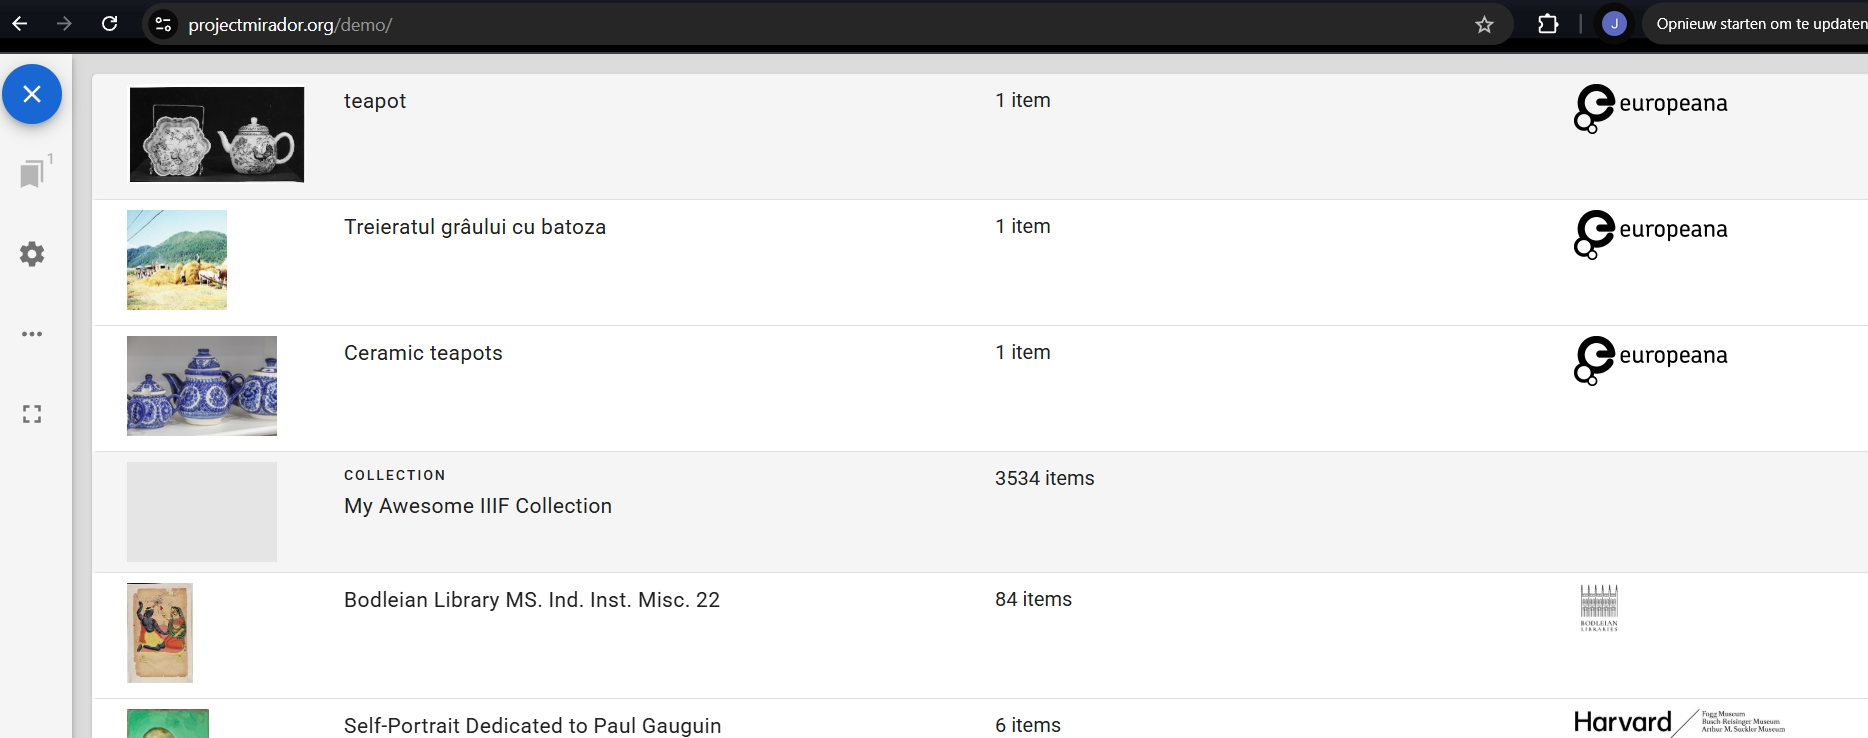

If we click on the collection (in this case the My Awesome IIIF Collection) it will load in on Mirador. Next we can select between the different manifests to see the respective images and metadata of records in our dataset.

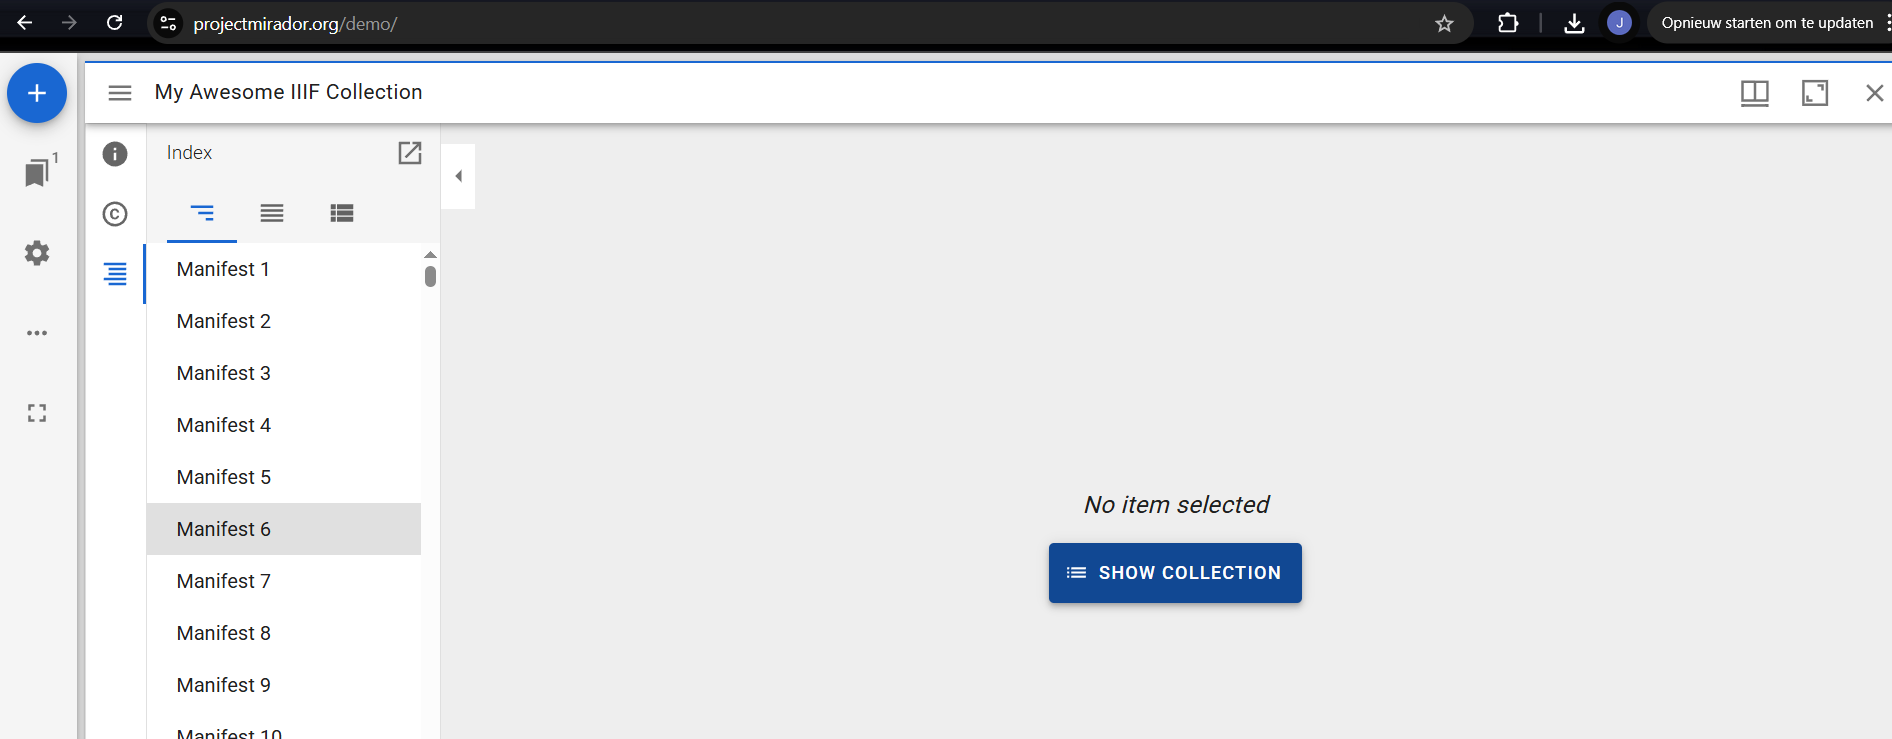

If we then click on 'show collection' and select an item at random in the list of manifests we will get a view of an image. If on the right we click on 'toggle sizebar' (the three horizontal lines) and then click on the index (the 5 horizontal lines a bit lower). We can select the collection name (in this case my awesome iiif collection). If we click on this, the collection overview bar on the right will show up. Here we can easily look at all the records individually, but in one neat interface.

remark: to set the black view, you can just select the theme in the menu bar on the left via the settings icon.

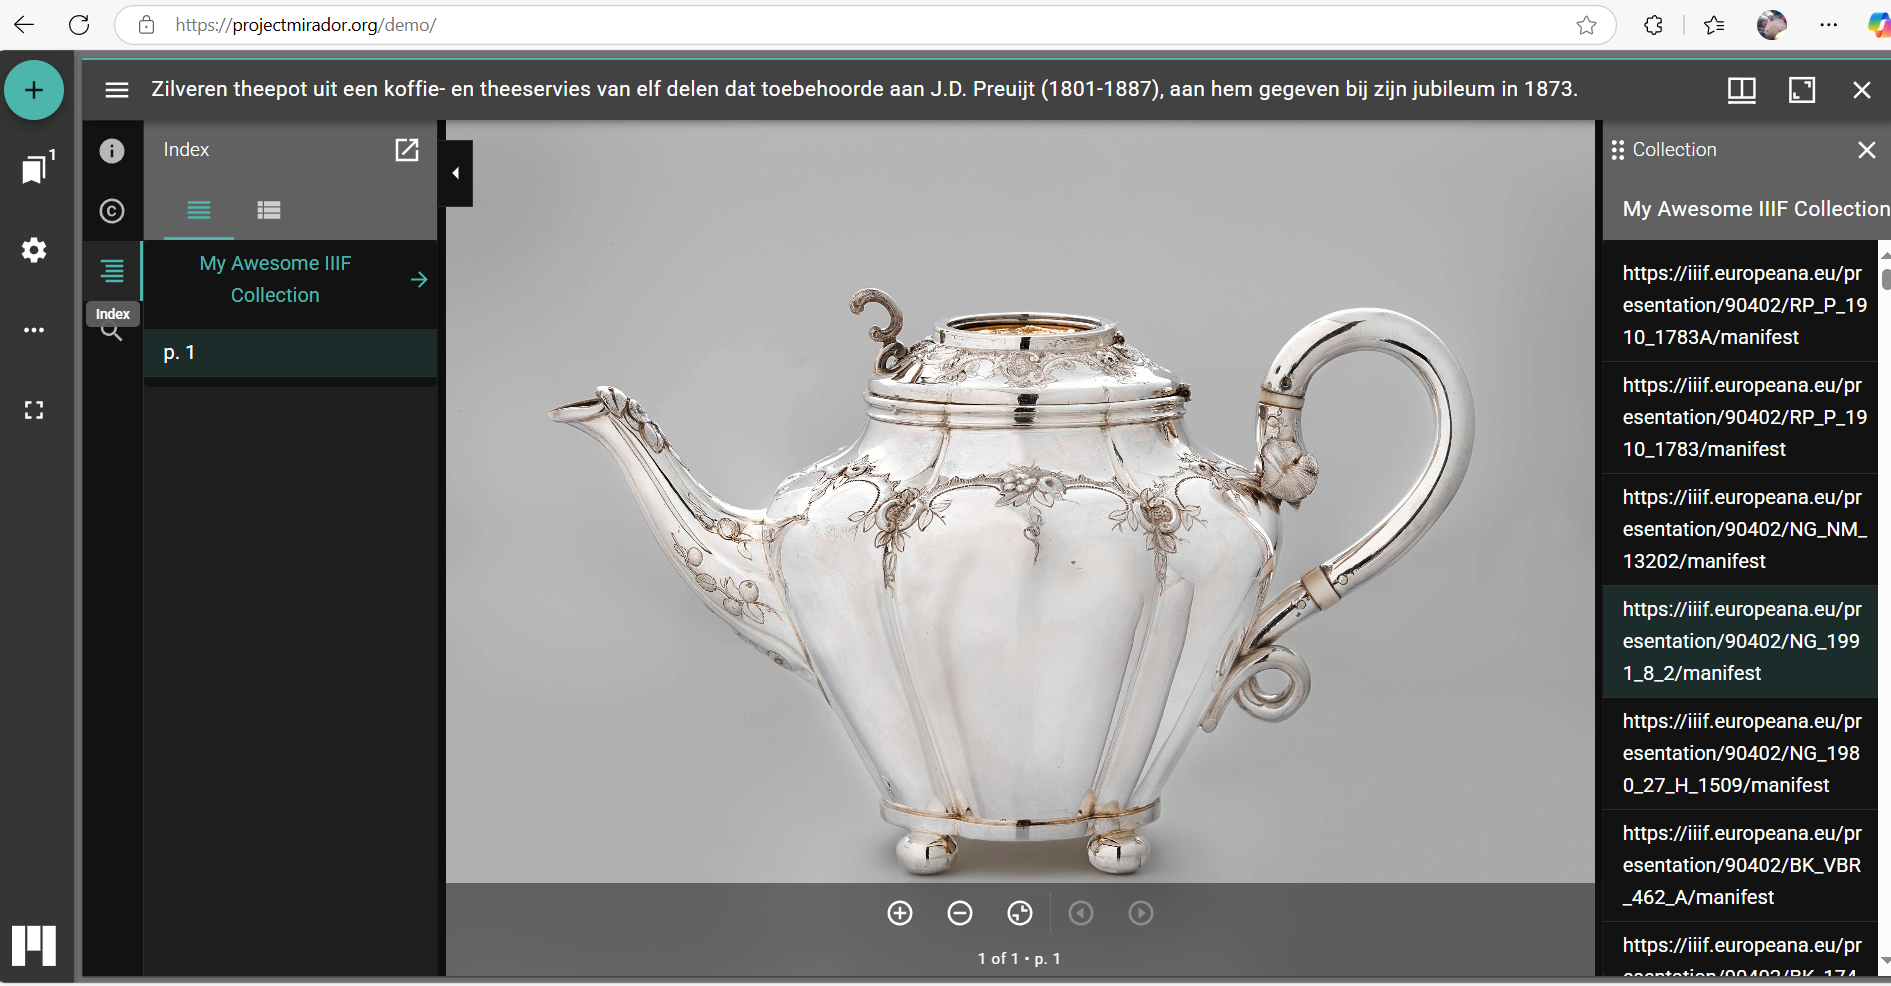

Now we can look at all the images via the Mirador viewer.

However, I was not able to solve the problem of loading Mirador with the collection via html webserver. This means that our dataset can only be properly consulted via the Mirador demo, instead of via local or web based server. I hope to solve this problem in the future.

I was able to write a html-script via Gemini that loads in the collection into a mirador viewer and can be tested via a local or webbased server. However, when we click on 'start here' in the Mirador viewer and then click on the 'awesome collection', we get stuck in a white screen.

After a long search, I concluded that the set might be too big when using a browser or a local server. This did not seem to be a problem with the demo. I tried creating subsets with 500, 100 and only 5 records. Created new collection manifest urls, but nothing seemed to work.

I found the solution! Solving the problem in Gemini: After prompting for ages I was able to find a solution. This was the case because I was able to find a new method of coding with Gemini. I kept rephrasing the problem to Gemini, but whatever I did I could not fix the white screen.

Suddenly I noticed that I can preview scripts inside of Gemini via the canvas option. Here I can choose between code view and an example view of the code. When I was clicking in the preview of this code and got to the white screen again (this time via the previewer of Gemini), it gave an error with the option to fix the code on the spot by Gemini. I choose this option and the problem got solved.

In [ ]:
# HTML Script to use the mirador viewer with our collection manifest
# Code generated by Gemini 2,5
# Authorized by Jenske Verhamme

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>My Teapot Collection (Mirador)</title>
    <link rel="stylesheet" href="https://unpkg.com/mirador@3.4.0/dist/mirador.min.css">
    <style>
        /* Make Mirador fill the entire page */
        html, body, #mirador-viewer {
            margin: 0;
            padding: 0;
            height: 100%;
            width: 100%;
            overflow: hidden; /* Prevent scrollbars */
        }
    </style>
</head>
<body>
    <div id="mirador-viewer"></div>

    <script src="https://unpkg.com/mirador@3.4.0/dist/mirador.min.js"></script>

    <script type="text/javascript">
        // --- YOUR IIIF COLLECTION MANIFEST URL ---
        // IMPORTANT: This URL should point to the manifest served by your local HTTP server.
        // It assumes you have run the Python script and are serving the 'output_first_subset' directory.
        // If you are using the original 'my-small-collection.json' directly from GitHub,
        // ensure GitHub Pages is enabled for your repository and use the correct raw URL.
        const MY_IIIF_COLLECTION_MANIFEST_URL = 'https://raw.githubusercontent.com/GuacamoleKoala/iiif-test/refs/heads/main/my-small-collection.json';

        // Initialize Mirador viewer
        Mirador.viewer({
            id: 'mirador-viewer', // ID of the HTML element where Mirador will be rendered

            // Add your collection to Mirador's catalog. This is how Mirador knows about your collection.
            catalog: [{
                manifestId: MY_IIIF_COLLECTION_MANIFEST_URL,
                provider: 'My Teapot Collection' // Custom label for your collection
            }],
            // Workspace settings for collections
            workspace: {
                type: 'mosaic', // 'mosaic' allows multiple windows; 'single' would only show one item at a time.
            },
            window: {
                // For collections, starting with the table of contents is usually best.
                defaultSidebarPanel: 'tableOfContents',
                sideBarOpenByDefault: true,
                panels: {
                    info: true,
                    toc: true, // Table of Contents panel is crucial for collections
                    annotations: true,
                    search: true
                }
            },
            // Enable debugging to see Mirador's internal logs in the browser console.
            // This is CRUCIAL for identifying any issues with your manifests.
            debug: true
        });
    </script>
</body>
</html>


## 4.1.3 Universal Viewer

i also tried a htmls script with universal viewer. I ran into similar problems as with Mirador. I reached a white screen upon uploading the dataset and running the script. Because I found a working solution in Mirador, I decided to not use Universal Viewer.

# 4.2 GITHUB

In this part I built a Github repository to share my project and have a version control available.

how to make a repository:

name of repository
link:

Overview of files

- readme

datasets
- fullwurkingscript dataset teapots
- dataset 2 (chapter one)
- final cleaned dataset

visualisations
- visualisations tableau

manual of project
- pdf chapter 1 + gist
- pdf chapter 2
- pdf chapter 3
- pdf chapter 4

overview
- exam paper

first of all thes

